# Modelo predicción precio viviendas Madrid

# *1. Contexto*

En este proyecto de ciencia de datos, hemos llevado a cabo un análisis detallado de un conjunto de datos de ventas de viviendas en Madrid.Nuestro objetivo es desarrollar un modelo predictivo preciso para estimar los precios de las viviendas. Trs realizar un exhaustivo Análisis Exploratorio de Datos (EDA), hemos obtenido una comprensión profunda de las características y relaciones clave entre las variables. Ahora, nos encontramos en una fase crucial: la construcción, evaluación y selección del modelo más adecuado para la predicción.


# *2. Librerías y configuración*

In [85]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Importing ML libraries and metrics
from math import sqrt
from tqdm import tqdm
import lightgbm as lgb
import xgboost as xgb
from lightgbm import early_stopping, log_evaluation
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Importar RFE desde scikit-learn
from sklearn.feature_selection import RFE

import shap
import pickle

In [86]:
# Ajusta las opciones de visualización
pd.set_option('display.max_rows', None)  # Muestra todas las filas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# *3. Funciones*

In [87]:
# Función que agrupa las columnas por tipo de dato

def columnas_por_tipo(df):
    # Filtrar columnas por tipo de datos
    int_columns = [col for col in df.columns if df[col].dtype.name.startswith('int')]
    float_columns = [col for col in df.columns if df[col].dtype.name.startswith('float')]
    # Lista de columnas que contienen exclusivamente los valores 0, 1 y NaN
    boolean_columns=[col for col in df.columns if set(df[col].dropna().unique()) <= {0, 1}]
    
    numeric_cols = int_columns + float_columns
    num_nobool = list(set(numeric_cols)-set(boolean_columns))
    object_columns = df.select_dtypes(include='object').columns.tolist()
    category_columns = df.select_dtypes(include='category').columns.tolist()
    cols = df.columns.tolist()

    cat_columns=list(set(category_columns) - set(boolean_columns) )
    # Obtener todas las columnas
    all_columns = set(df.columns)
    # Columnas de otros tipos
    other_columns = list(all_columns - set(int_columns) - set(float_columns) - set(object_columns) - set(category_columns))
    cols_noboolean = set(cols) - set(boolean_columns)

    # Contar el número de columnas de cada tipo
    num_int_columns = len(int_columns)
    num_float_columns = len(float_columns)
    num_object_columns = len(object_columns)
    num_category_columns = len(category_columns)
    num_other_columns = len(other_columns)

    # Mostrar los resultados
    print("Número de columnas de tipo entero:", num_int_columns)
    print("Columnas de tipo entero:", int_columns)
    print("------------------------------------------------------")
    print("Número de columnas de tipo float:", num_float_columns)
    print("Columnas de tipo float:", float_columns)
    print("------------------------------------------------------")
    print("Número de columnas de tipo object:", num_object_columns)
    print("Columnas de tipo object:", object_columns)
    print("------------------------------------------------------")
    print("Número de columnas de tipo category:", num_category_columns)
    print("Columnas de tipo category:", category_columns)
    print("------------------------------------------------------")
    print("Número de columnas de otros tipos:", num_other_columns)
    print("Columnas de otros tipos:", other_columns)

    return boolean_columns, numeric_cols, cat_columns, object_columns, other_columns, num_nobool, cols_noboolean

# *4 Carga de datos*



Para esta fase del proyecto de selección del modelo, trabajamos con dos conjuntos de datos: `train` y `test`. Ambos datasets han sido previamente depurados, eliminando valores nulos y garantizando su limpieza, lo que asegura una calidad de datos óptima para el desarrollo del modelo. Durante la fase de Análisis Exploratorio de Datos (EDA), se llevaron a cabo transformaciones adicionales y un estudio detallado de las variables, identificando patrones, distribuciones y relaciones clave. Este proceso no solo nos permitió comprender mejor los datos, sino también preparar el terreno para las siguientes etapas del modelado. Además, se aplicó la codificación *one-hot encoding* a las variables categóricas para hacerlas aptas para los algoritmos de aprendizaje automático, y se eliminaron variables con alta correlación para reducir la multicolinealidad y optimizar el rendimiento del modelo. Por último, hemos validado que las características seleccionadas tengan relevancia estadística y coherencia con el problema a resolver.



In [88]:
X_train= pd.read_csv('./data/X_train_VC.csv',sep=";",index_col=False)
X_test= pd.read_csv('./data/X_test_VC.csv',sep=";",index_col=False)

In [89]:
# Revisamos los datos del dataset
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7891 entries, 0 to 7890
Data columns (total 71 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            7891 non-null   object 
 1   m2_constr                      7891 non-null   float64
 2   estado                         7891 non-null   int64  
 3   amueblado                      7891 non-null   float64
 4   planta                         7891 non-null   float64
 5   codigo_postal                  7891 non-null   int64  
 6   certificado_energetico         7891 non-null   float64
 7   orientacion_este               7891 non-null   float64
 8   orientacion_oeste              7891 non-null   float64
 9   orientacion_sur                7891 non-null   float64
 10  orientacion_norte              7891 non-null   float64
 11  num_personas                   7891 non-null   int64  
 12  total_transacciones            7891 non-null   i

In [90]:
# Identificamos el numero de valores unicos
X_train.nunique()

url                              7891
m2_constr                         526
estado                              6
amueblado                           4
planta                             26
codigo_postal                      49
certificado_energetico              2
orientacion_este                    2
orientacion_oeste                   2
orientacion_sur                     2
orientacion_norte                   2
num_personas                      131
total_transacciones               122
viv_nuevas_transacciones           58
lineas_metro                        8
renta_bruta_media_por_persona      21
tamano_medio_del_hogar             18
tam_hogar                          21
hog_con_10                         21
hog_con_15_y_más                   17
m2_areasverdes                     21
ins_comunitaria                     3
energia                             5
eficiencia_carpinteria              9
precio_mean_b                     131
pm_tlogia_distrito                116
euro_m2_barr

# *5. Análisis de datos*

In [91]:
#Revisamos las estadisticas
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
m2_constr,7891.00,138.87,149.89,10.00,68.00,98.00,150.00,3250.00
estado,7891.00,1.39,1.52,0.00,0.00,1.00,2.00,5.00
amueblado,7891.00,0.10,0.30,0.00,0.00,0.00,0.00,1.00
planta,7891.00,2.59,2.23,-1.00,1.00,2.00,3.00,27.00
codigo_postal,7891.00,28021.26,15.13,28001.00,28009.00,28017.00,28033.00,28055.00
certificado_energetico,7891.00,0.19,0.39,0.00,0.00,0.00,0.00,1.00
orientacion_este,7891.00,0.06,0.24,0.00,0.00,0.00,0.00,1.00
orientacion_oeste,7891.00,0.05,0.21,0.00,0.00,0.00,0.00,1.00
orientacion_sur,7891.00,0.08,0.27,0.00,0.00,0.00,0.00,1.00
orientacion_norte,7891.00,0.03,0.18,0.00,0.00,0.00,0.00,1.00


## *5.1 Distribución de la variable objetivo (target)*

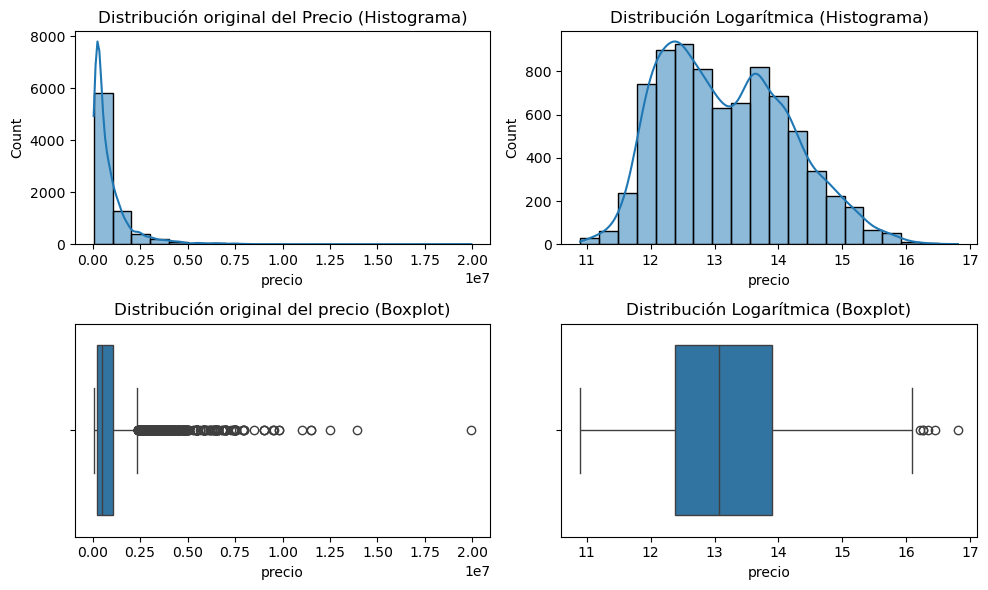

In [92]:
# Crear una figura con 2 filas y 2 columnas para los gráficos
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Primer gráfico: Histograma de la distribución original
sns.histplot(X_train["precio"], bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribución original del Precio (Histograma)")

# Segundo gráfico: Histograma de la distribución logarítmica
sns.histplot(np.log1p(X_train["precio"]), bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Distribución Logarítmica (Histograma)")

# Tercer gráfico: Boxplot de la distribución original
sns.boxplot(x=X_train["precio"], ax=axes[1, 0])
axes[1, 0].set_title("Distribución original del precio (Boxplot)")

# Cuarto gráfico: Boxplot de la distribución logarítmica
sns.boxplot(x=np.log1p(X_train["precio"]), ax=axes[1, 1])
axes[1, 1].set_title("Distribución Logarítmica (Boxplot)")

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()

La transformación logaritmica suaviza considerablemente la distribución de la variable precio.

Aplicamos la transformación logaritmica a la variable para enrenar el modelo

In [93]:

# Aplicar transformación logarítmica (evita problemas con ceros)
X_train["precio"] = np.log1p(X_train["precio"])  # log1p(x) = log(x + 1) para evitar log(0)
X_test["precio"] = np.log1p(X_test["precio"])



Revisamos la correlación entre las variables

In [94]:
# Finding out the correlation between the features
#quitamos url
corr =  X_train.drop(columns=['url']).corr()



<Axes: >

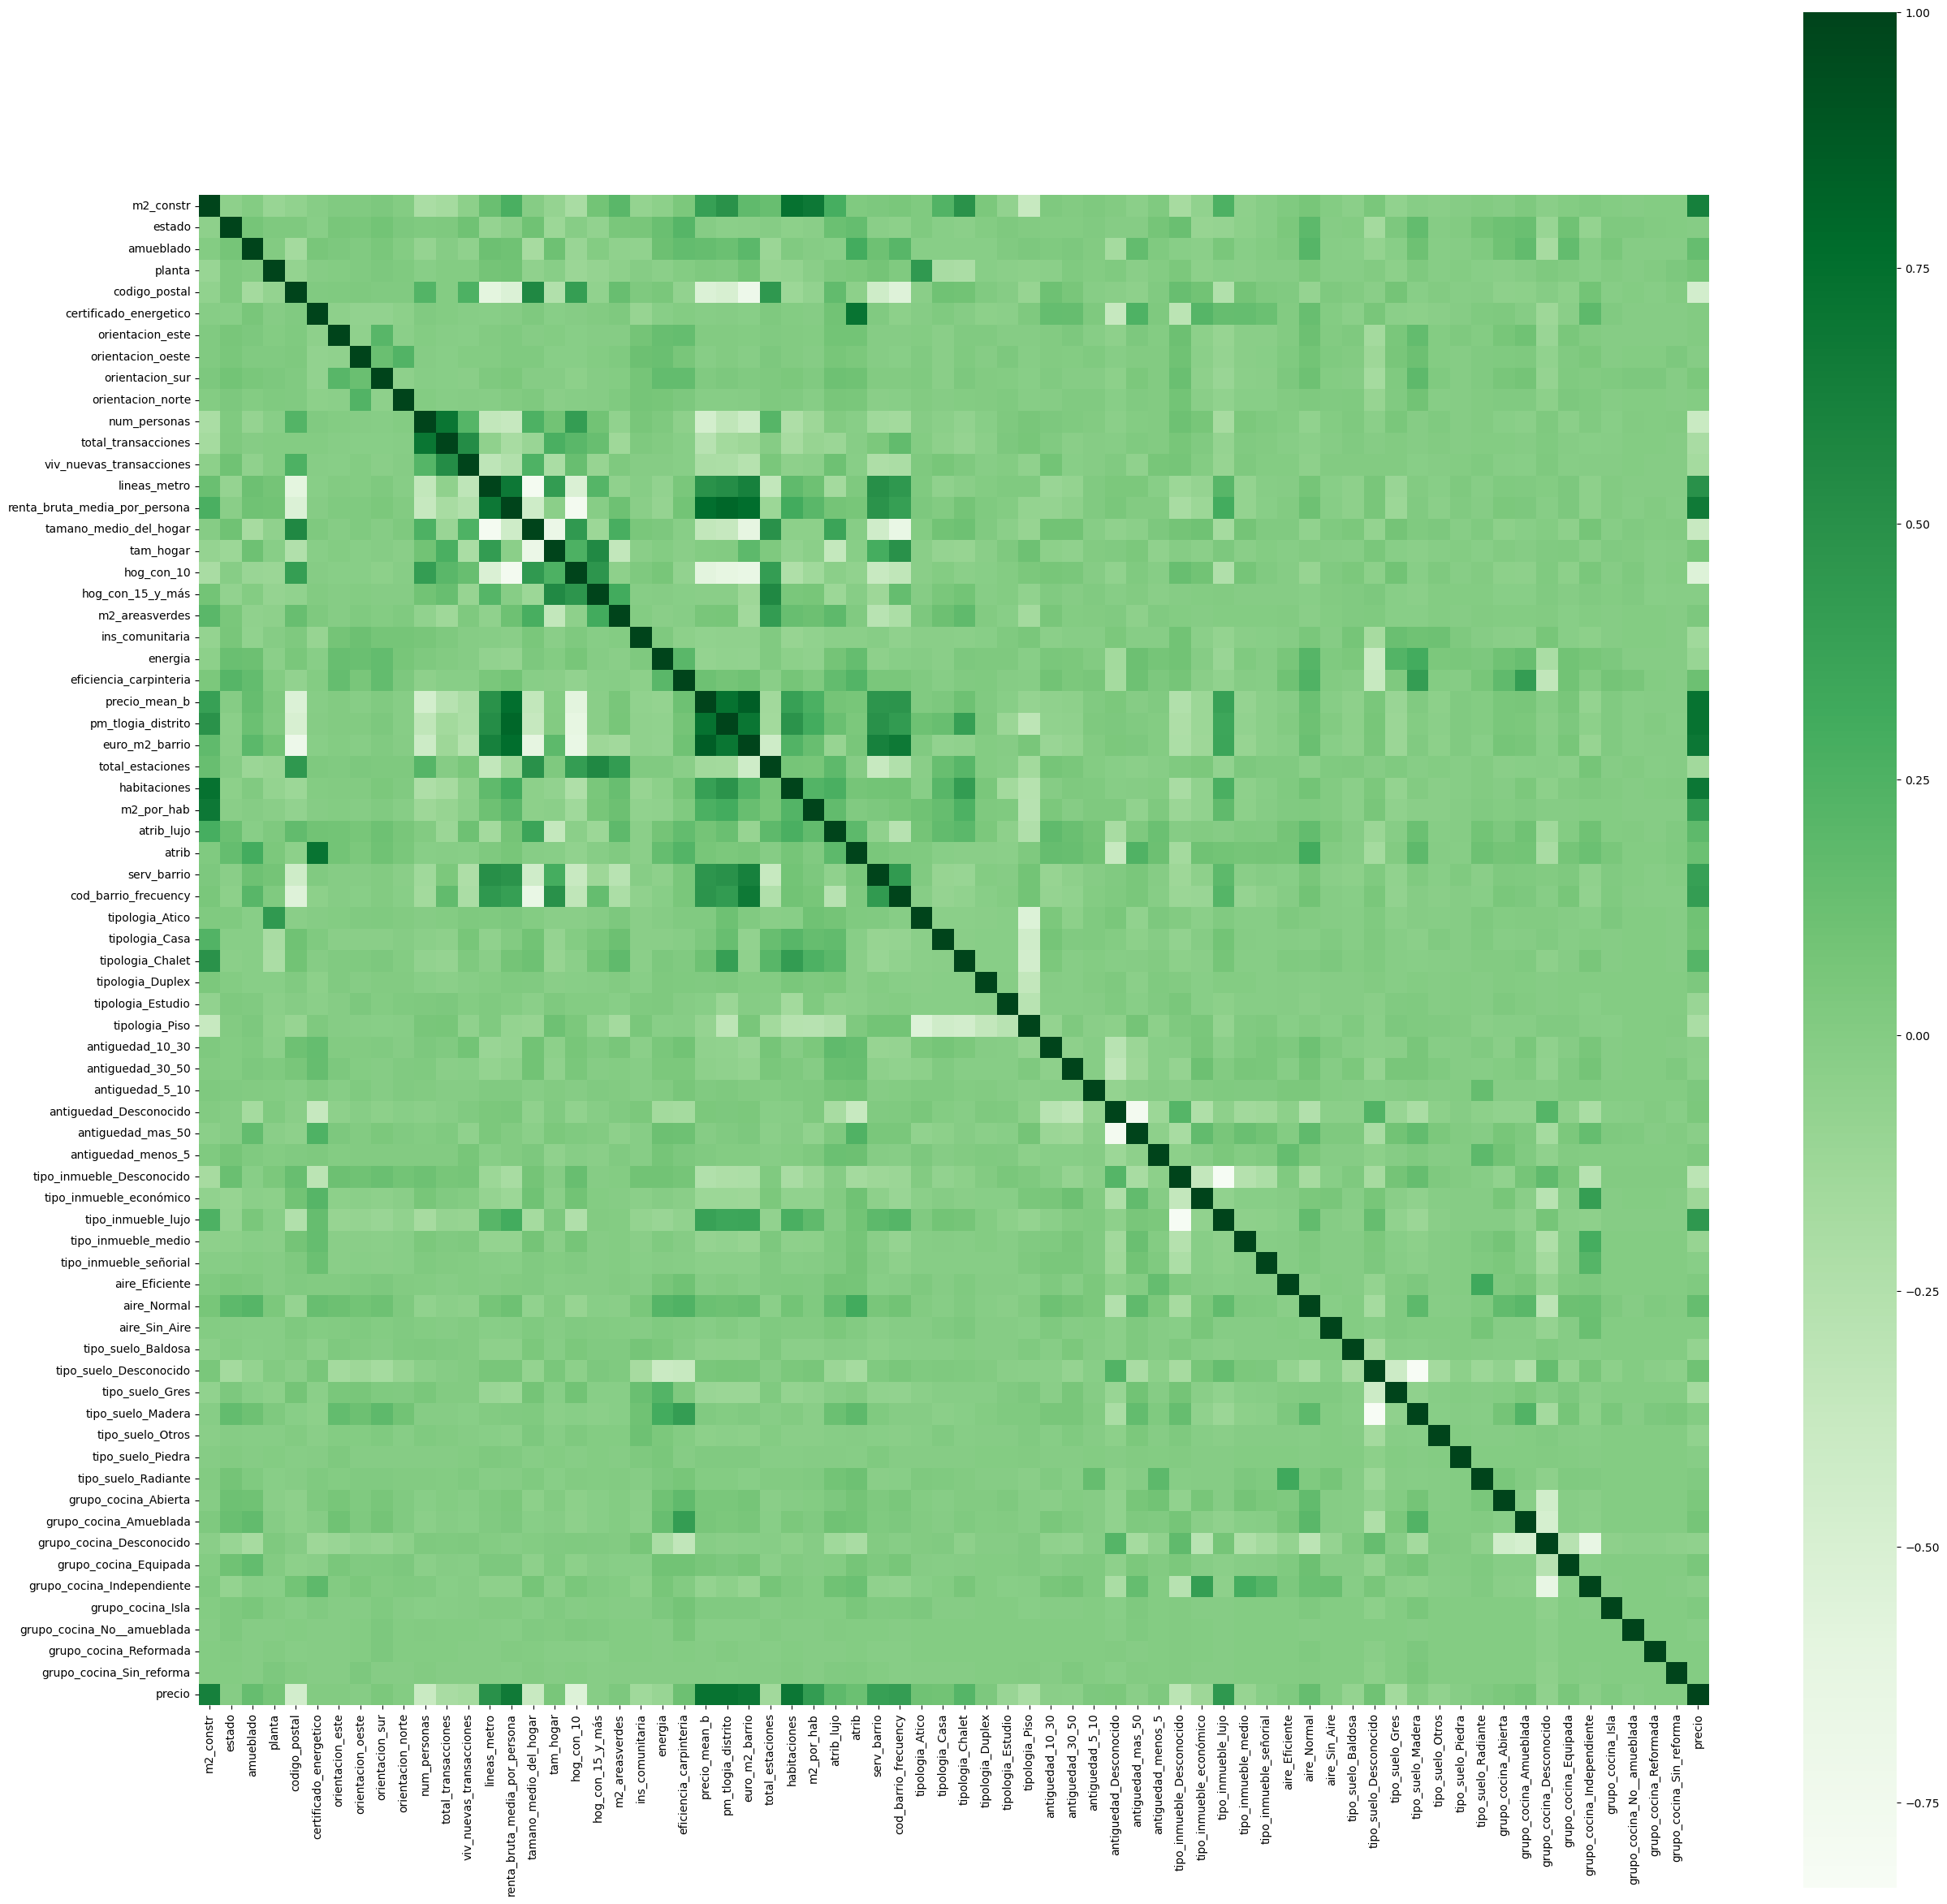

In [95]:
# Plotting the heatmap of correlation between features
plt.figure(figsize=(30,30))
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=False, annot_kws={'size':15}, cmap='Greens')

Comprobamos la correlacción de todas las varibles con la varaible objetivo

In [96]:
corr[['precio']].sort_values(by = 'precio',ascending = False).style.background_gradient()

,precio
precio,1.000000
precio_mean_b,0.727339
pm_tlogia_distrito,0.721165
habitaciones,0.688531
euro_m2_barrio,0.687737
renta_bruta_media_por_persona,0.665246
m2_constr,0.620477
lineas_metro,0.493231
tipo_inmueble_lujo,0.448059
m2_por_hab,0.418231


Comprobamos si hay variables muy correladas que aporten la misma infrmación al modelo para  eliminar al menos una de ellas

In [97]:
# Establecer un umbral para la correlación (90%)
threshold = 0.90

# Identificar pares de variables con correlación
correlations = []
already_seen = set()

for col in corr.columns:
    for row in corr.index:
        if abs(corr.loc[row, col]) > threshold and col != row:
            pair = tuple(sorted((row, col)))  # Crear pares únicos
            if pair not in already_seen:
                correlations.append((row, col, corr.loc[row, col]))
                already_seen.add(pair)  # Marcar par como ya visto

# Imprimir los resultados
print("Pares de variables con correlación mayor al 90%:")
for var1, var2, corr in correlations:
    print(f"{var1} y {var2}: {corr:.2f}")


Pares de variables con correlación mayor al 90%:


## 5.2 Extracción de la variable target en train / test

In [98]:
X_train['precio'].head()

0   12.71
1   14.12
2   13.98
3   15.52
4   13.41
Name: precio, dtype: float64

In [99]:
X_train.columns

Index(['url', 'm2_constr', 'estado', 'amueblado', 'planta', 'codigo_postal',
       'certificado_energetico', 'orientacion_este', 'orientacion_oeste',
       'orientacion_sur', 'orientacion_norte', 'num_personas',
       'total_transacciones', 'viv_nuevas_transacciones', 'lineas_metro',
       'renta_bruta_media_por_persona', 'tamano_medio_del_hogar', 'tam_hogar',
       'hog_con_10', 'hog_con_15_y_más', 'm2_areasverdes', 'ins_comunitaria',
       'energia', 'eficiencia_carpinteria', 'precio_mean_b',
       'pm_tlogia_distrito', 'euro_m2_barrio', 'total_estaciones',
       'habitaciones', 'm2_por_hab', 'atrib_lujo', 'atrib', 'serv_barrio',
       'cod_barrio_frecuency', 'tipologia_Atico', 'tipologia_Casa',
       'tipologia_Chalet', 'tipologia_Duplex', 'tipologia_Estudio',
       'tipologia_Piso', 'antiguedad_10_30', 'antiguedad_30_50',
       'antiguedad_5_10', 'antiguedad_Desconocido', 'antiguedad_mas_50',
       'antiguedad_menos_5', 'tipo_inmueble_Desconocido',
       'tipo_inmuebl

In [100]:
df_ids = X_train[['url']]
y_train=X_train['precio']
y_test=X_test['precio']
X_train = X_train.drop(columns=["url","precio"])
X_test = X_test.drop(columns=["url","precio"])


# *6.  Normalización*

Al tener unas columnas valores muy grandes y otras muy pequeños vamos a normalizar para que el modelo no dé mas peso a las primeras.Al normalizar, llevamos todas las variables a una escala similar.
Dentro de las opciones que tenemos para normalizar , utilizamos RobustScaler para reducir el impacto de los outliers, ya que es especialmente útil porque utiliza la mediana y el rango intercuartílico (IQR) para escalar los datos

In [101]:
# Normalizar con RobustScaler
scaler = RobustScaler().set_output(transform="pandas")
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [102]:
X_train.columns

Index(['m2_constr', 'estado', 'amueblado', 'planta', 'codigo_postal',
       'certificado_energetico', 'orientacion_este', 'orientacion_oeste',
       'orientacion_sur', 'orientacion_norte', 'num_personas',
       'total_transacciones', 'viv_nuevas_transacciones', 'lineas_metro',
       'renta_bruta_media_por_persona', 'tamano_medio_del_hogar', 'tam_hogar',
       'hog_con_10', 'hog_con_15_y_más', 'm2_areasverdes', 'ins_comunitaria',
       'energia', 'eficiencia_carpinteria', 'precio_mean_b',
       'pm_tlogia_distrito', 'euro_m2_barrio', 'total_estaciones',
       'habitaciones', 'm2_por_hab', 'atrib_lujo', 'atrib', 'serv_barrio',
       'cod_barrio_frecuency', 'tipologia_Atico', 'tipologia_Casa',
       'tipologia_Chalet', 'tipologia_Duplex', 'tipologia_Estudio',
       'tipologia_Piso', 'antiguedad_10_30', 'antiguedad_30_50',
       'antiguedad_5_10', 'antiguedad_Desconocido', 'antiguedad_mas_50',
       'antiguedad_menos_5', 'tipo_inmueble_Desconocido',
       'tipo_inmueble_econó

In [103]:
# Ajustar las configuraciones de pandas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.expand_frame_repr', False)  # Evitar el ajuste a nuevas líneas

#### ** Huber Regressor** :
Modelo de regresión robusto que  minimizar la función de pérdida de Huber en lugar del error cuadrático medio.
  - Es resistente a valores atípicos, ya que penaliza menos los errores grandes.
  - Ideal para datos con outliers en la variable objetivo.
  - Requiere ajustar el parámetro `epsilon`, que controla la sensibilidad a los valores atípicos.

# *7. Entrenamiento*

Para analizar cual es el modelo que mejor predice nuestra varaible objetivo (" precio de una vivienda") vamos a utilizar variso modelos de regresión

Los modelos que vamos a probar son:

**Random Forest Regressor:**  modelo basado en un conjunto de árboles de decisión que utiliza bagging para combinar múltiples predicciones y mejorar la precisión.
  - Maneja relaciones no lineales entre variables.
  - Resistente a overfitting si se configura adecuadamente.
  - Proporciona medidas de importancia de las características (`feature_importances_`).

**Gradient Boosting Regressor:** modelo basado en árboles de decisión que construye árboles de manera secuencial, donde cada nuevo árbol corrige los errores del anterior.
  - Funciona bien con datos no lineales.
  - Es sensible a hiperparámetros como `learning_rate` y `n_estimators`.
  - Puede ajustarse para evitar overfitting utilizando técnicas como regularización.

**XGBoost Regressor:**- Es una implementación avanzada de Gradient Boosting que optimiza la velocidad y el rendimiento del modelo.
  - Soporta regularización (`L1` y `L2`), lo que mejora la generalización.
  - Utiliza técnicas como paralelización y manejo eficiente de memoria.

**LGBM Regressor (LightGBM):** modelo de boosting basado en histogramas que divide los datos en "hojas" en lugar de niveles, lo que mejora la velocidad.
  - Altamente eficiente y rápido para grandes conjuntos de datos.
  - Soporta múltiples hiperparámetros para ajustar la profundidad y el número de hojas.
  - Maneja datos categóricos directamente.

**Lasso Regression:** modelo de regresión lineal que incluye regularización L1, lo que obliga a que algunos coeficientes sean exactamente cero, ayudando a la selección de características.
  - Útil para datasets con muchas variables, seleccionando solo las más relevantes.
  - Reduce la varianza, pero puede introducir un sesgo leve.
  - Controlado por el hiperparámetro `alpha`, que ajusta la fuerza de la regularización.
  
**SVR (Support Vector Regressor):** Es una extensión de las máquinas de soporte vectorial (SVM) para problemas de regresión, que busca minimizar el error dentro de un margen (`epsilon`).
  - Robusto para conjuntos de datos con alto dimensionalidad.
  - Soporta diferentes funciones núcleo (`kernel`) como lineal, radial (RBF) y polinomial.
  - Controlado por los hiperparámetros `C` (regularización) y `gamma` (influencia de los puntos).

##### Selección de hiperparametros*

In [ ]:


# Lista de modelos y sus hiperparámetros
models_params = {  
     
    "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [50, 100, 200, 300],
            #"max_depth": [None, 10, 20, 30],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10,20],
            "min_samples_leaf": [10, 20]
           # "min_samples_leaf": [1, 2,4]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.001,0.01, 0.05, 0.1],
            "max_depth": [3, 4, 5],
            "min_samples_leaf": [10, 20],
            "subsample": [0.7, 0.8]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "max_depth": [3, 4, 5, 6],
            "subsample": [0.7, 0.8, 0.9, 1.0]
        }
    },
    "LGBM Regressor": {
        "model": lgb.LGBMRegressor(),
        "params": {        
            'n_estimators': np.arange(50, 200, 50),
            'learning_rate': [0.001,0.01, 0.05],
            'max_depth': [4,6, 8],
            'num_leaves': [10, 15, 20],
            'min_child_samples': [10, 15, 20],
            'subsample': [0.5, 0.6, 0.7]
#         }
        }
    },
    "Lasso": {
        "model": Lasso(),
        "params": {
            "alpha": [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
            "max_iter": [1000, 5000, 10000],
            "tol": [1e-4, 1e-3, 1e-2]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "C": [0.1, 1, 10, 100],
            "epsilon": [0.01, 0.1, 0.2, 0.5],
            "degree": [2, 3, 4],  # Solo aplica para kernel "poly"
            "gamma": ["scale", "auto"]
        }
    }
}


##### Entrenamamiento con hiperparametros y validación cruzada 

Iteramos sobre los modelos y los hiperparametros y con RandomizedSearchCV se realiza una búsqueda aleatoria de hiperparámetros en el espacio definido por param_dist

Seleccionamos 4 particiones para hacer la validación cruzada,  20 combinaciones de hiperparametros a probar.

Especificamos uque la metris de evaluación sea "r2" y indicamos que se ajuste  automáticamente el modelo con los mejores hiperparámetros

El modelo resultante se entrena  usando los datos de entrenamiento.

Los resultados detallados como las combinaciones de hiperparámetros probadas y sus respectivas métricas, se almacenan en un DataFrame creado
 a partir de random_search.cv_results_. También se añade una columna extra (regressor) para identificar a qué modelo pertenecen esos resultados.
Este DataFrame se agrega a la lista random_search_output
El modelo con los mejores hiperparámetros para cada algoritmo (obtenido con random_search.best_estimator_) se guarda en el diccionario best_estimators bajo el nombre del modelo.

Entradas: Conjunto de datos (X_train, y_train), lista de modelos y sus hiperparámetros.

Procesamiento:

*Se realiza validación cruzada con RandomizedSearchCV.

*Se evalúan varias combinaciones de hiperparámetros.

*Se identifica y almacena el modelo con los mejores resultados.

Salidas:

*Resultados detallados en random_search_output.

*Modelos ajustados con los mejores hiperparámetros en best_estimators.

In [106]:


#cv_results = {}
feature_importance_dict = {}
random_search_output = list()
best_estimators = {}

# Validación cruzada con KFold y búsqueda de hiperparámetros
for name, info in models_params.items():
    print(name)
    model = info["model"]
    param_dist = info["params"]
    
    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        model, param_dist, cv=4, n_iter=20, 
        scoring="r2", random_state=42, n_jobs=-1, return_train_score=True,verbose=1,refit=True
    )
    random_search.fit(X_train, y_train)
    # Resultados del Random Search
    df_output = pd.DataFrame(random_search.cv_results_)
    df_output['regressor'] = name
    random_search_output.append(df_output)
     # Modelo re-entrenado con los hiperparámetros óptimos
    best_estimators[name] = random_search.best_estimator_
  
  



 

Huber Regressor
Fitting 4 folds for each of 20 candidates, totalling 80 fits


c:\Users\extas\anaconda3\envs\Nuclio\Lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Random Forest
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Gradient Boosting
Fitting 4 folds for each of 20 candidates, totalling 80 fits
XGBoost
Fitting 4 folds for each of 20 candidates, totalling 80 fits
LGBM Regressor
Fitting 4 folds for each of 20 candidates, totalling 80 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1638
[LightGBM] [Info] Number of data points in the train set: 7891, number of used features: 64
[LightGBM] [Info] Start training from score 13.179076
Lasso
Fitting 4 folds for each of 20 candidates, totalling 80 fits
SVR
Fitting 4 folds for each of 20 candidates, totalling 80 fits


In [107]:
pd.set_option('display.max_colwidth', None) 

Concatenamos todos los resultado para cada modelo, como resultado obtenemos un DataFrame .

Componemos el dataframe df_results con las siguietes columnas:

'regressor': Identifica el modelo o regresor asociado con los resultados.

'rank_test_score': Rango del modelo basado en sus puntajes de validación cruzada (mejor modelo tendrá rango 1).

'mean_train_score': Puntaje promedio en los datos de entrenamiento (valores obtenidos durante la validación cruzada).

'mean_test_score': Puntaje promedio en los datos de prueba.

'std_test_score': Desviación estándar de los puntajes en los datos de prueba.

'params': Detalles de los hiperparámetros evaluados.

split_test_score_columns: Agrega las columnas específicas para los puntajes individuales por partición de la validación cruzada.

##### Dataframe unificado con el resultado de los modelos

In [108]:
# Contatenamos todos los resultados para cada modelo
df_results = pd.concat(random_search_output).reset_index(drop = True)
#split_test_score_columns = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']
#Definimosuna lista con las columnas de la puntuación de la validación cruzada por partición (split0_test_score, split1_test_score, etc.).
#Estas columnas contienen las métricas evaluadas (en este caso, el coeficiente de determinación R^2) en cada partición del proceso de validación cruzada
split_test_score_columns = ['split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score']
df_results = df_results[
    ['regressor', 'rank_test_score', 'mean_train_score', 'mean_test_score', 'std_test_score', 'params']
    + split_test_score_columns
]
df_results.sample(20)

,regressor,rank_test_score,mean_train_score,mean_test_score,std_test_score,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score
75,XGBoost,17,0.77,0.77,0.00,"{'subsample': 0.9, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01}",0.76,0.76,0.77,0.77
74,XGBoost,6,0.95,0.92,0.01,"{'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2}",0.91,0.92,0.92,0.92
94,LGBM Regressor,15,0.16,0.16,0.00,"{'subsample': 0.5, 'num_leaves': 20, 'n_estimators': 100, 'min_child_samples': 15, 'max_depth': 8, 'learning_rate': 0.001}",0.16,0.15,0.15,0.16
2,Huber Regressor,18,0.80,0.79,0.09,"{'max_iter': 2000, 'epsilon': 1.0, 'alpha': 0.01}",0.83,0.64,0.87,0.83
10,Huber Regressor,4,0.82,0.81,0.08,"{'max_iter': 2000, 'epsilon': 2.0, 'alpha': 0.0001}",0.84,0.68,0.88,0.85
54,Gradient Boosting,1,0.95,0.92,0.01,"{'subsample': 0.7, 'n_estimators': 200, 'min_samples_leaf': 10, 'max_depth': 5, 'learning_rate': 0.05}",0.91,0.93,0.93,0.93
136,SVR,7,0.84,0.83,0.05,"{'kernel': 'linear', 'gamma': 'scale', 'epsilon': 0.5, 'degree': 3, 'C': 1}",0.84,0.75,0.87,0.86
95,LGBM Regressor,19,0.08,0.08,0.00,"{'subsample': 0.7, 'num_leaves': 15, 'n_estimators': 50, 'min_child_samples': 10, 'max_depth': 6, 'learning_rate': 0.001}",0.08,0.08,0.08,0.08
52,Gradient Boosting,3,0.94,0.92,0.01,"{'subsample': 0.7, 'n_estimators': 200, 'min_samples_leaf': 20, 'max_depth': 4, 'learning_rate': 0.05}",0.91,0.92,0.92,0.93
16,Huber Regressor,9,0.81,0.80,0.08,"{'max_iter': 2000, 'epsilon': 1.5, 'alpha': 0.001}",0.84,0.66,0.87,0.84


##### Elección del mejor modelo

Para cada modelo seleccionamosel que obtuvo la mejor evaluación (primer lugar) en la validación cruzada segun la metrica R2

In [109]:
# Nos quedamos con el mejor modelo de cada tipo
df_best = (
    df_results
    .query('rank_test_score == 1')
    .drop_duplicates(['regressor', 'rank_test_score'])
    .sort_values('mean_test_score', ascending = False)
    .reset_index(drop = True)
)
df_best

,regressor,rank_test_score,mean_train_score,mean_test_score,std_test_score,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score
0,Gradient Boosting,1,0.95,0.92,0.01,"{'subsample': 0.7, 'n_estimators': 200, 'min_samples_leaf': 10, 'max_depth': 5, 'learning_rate': 0.05}",0.91,0.93,0.93,0.93
1,XGBoost,1,0.96,0.92,0.01,"{'subsample': 0.7, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}",0.91,0.92,0.93,0.93
2,LGBM Regressor,1,0.93,0.92,0.01,"{'subsample': 0.7, 'num_leaves': 10, 'n_estimators': 150, 'min_child_samples': 10, 'max_depth': 6, 'learning_rate': 0.05}",0.90,0.92,0.92,0.92
3,SVR,1,0.95,0.91,0.01,"{'kernel': 'rbf', 'gamma': 'auto', 'epsilon': 0.1, 'degree': 3, 'C': 10}",0.90,0.91,0.91,0.92
4,Random Forest,1,0.94,0.91,0.01,"{'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 20}",0.89,0.91,0.91,0.91
5,Lasso,1,0.86,0.84,0.03,"{'tol': 0.01, 'max_iter': 5000, 'alpha': 0.0001}",0.84,0.80,0.86,0.86
6,Huber Regressor,1,0.83,0.82,0.07,"{'max_iter': 300, 'epsilon': 2.5, 'alpha': 0.0001}",0.84,0.70,0.88,0.85


##### Boxplot de la distribución de los puntuajes r2 en cada segmento de la validación cruzada

Extraemos las columnas definidas en split_test_score_columns del DataFrame df_best.
Estas columnas contienen los puntajes de validación cruzada (por ejemplo, split0_test_score, split1_test_score, etc.) para cada modelo

Creamos un boxplot que muestra la distribución de los puntajes r2 es decir qué tan bien el modelo es capaz de realizar predicciones, en comparación con los valores reales, para los modelos en cada partición de la validación cruzada.
Este boxplot de los puntajes R² permite visualizar gráficamente cómo varían los resultados del modelo para cada partición durante la validación cruzada.


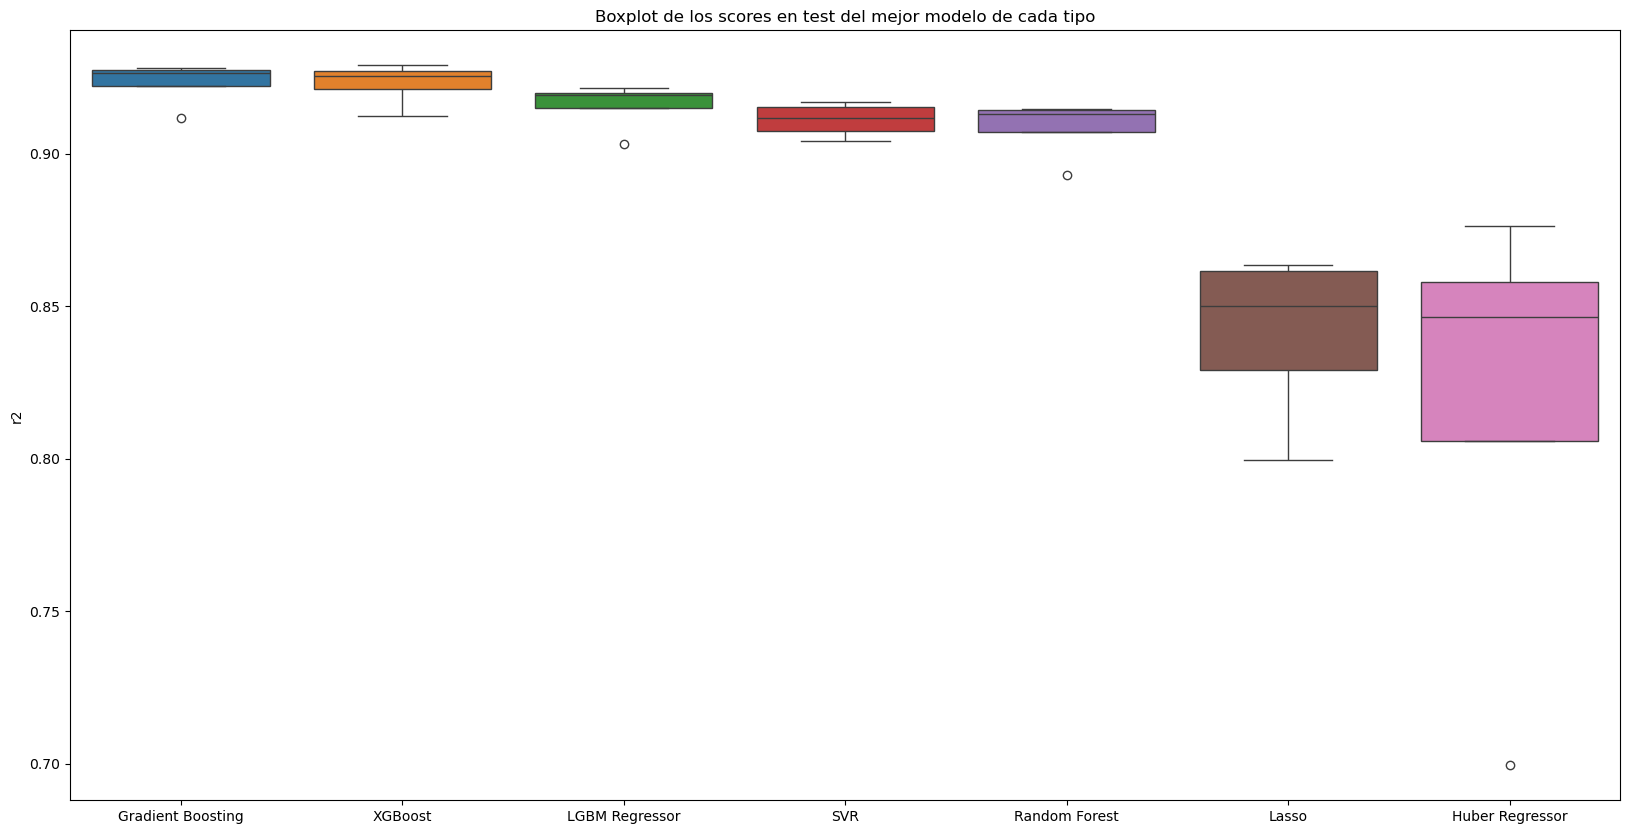

In [110]:
# Transponer el DataFrame para que cada modelo sea una columna
df_transposed = df_best[split_test_score_columns].T

# Crear el boxplot usando Seaborn
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_transposed)
plt.ylabel("r2")

plt.title("Boxplot de los scores en test del mejor modelo de cada tipo")
# Añadir etiquetas al eje x
plt.xticks(ticks=range(len(df_transposed.columns)), labels=df_best["regressor"])
plt.show()


Como podemos observar en caso de XGBoost, LGBM Regressor y Gradient Boosting son los modelos en los que los  valores de R² están cerca de 1, lo que significa que el modelo realiza predicciones precisas en comparación con los valores reales.

La consistencia del modelo: La distribución de los puntajes (rango de la caja y presencia de outliers) muestra si el modelo es estable en diferentes particiones de los datos.

Comparación entre modelos: Al observar los boxplots de diferentes modelos, puedes identificar cuál tiene una mejor precisión promedio y menor variabilidad.

Este análisis es útil para elegir el modelo más adecuado antes de aplicar el sistema predictivo en un entorno real. Es una forma clara de representar qué tan bien los modelos están aprendiendo de los datos

In [111]:
for i, r in df_best.iterrows():
    print(r.regressor, "=>", np.round(r.mean_test_score, 4), "\u00B1", np.round(r.std_test_score, 4))

Gradient Boosting => 0.9232 ± 0.0068
XGBoost => 0.923 ± 0.0063
LGBM Regressor => 0.9158 ± 0.0074
SVR => 0.9111 ± 0.0051
Random Forest => 0.9084 ± 0.009
Lasso => 0.8407 ± 0.0256
Huber Regressor => 0.8171 ± 0.0691


##### Elección del mejor modelo

In [118]:
# Escogemos el mejor modelo de todos 
best_model= best_estimators['XGBoost']
  # Predicciones en el conjunto de prueba

   # Predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)
r2_test = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2_Test: {r2_test}, MAE: {mae}, RMSE: {rmse}, Best_Params: {random_search.best_params_}")


R2_Test: 0.9246280582142736, MAE: 0.19307941366645306, RMSE: 0.2669240086363469, Best_Params: {'kernel': 'rbf', 'gamma': 'auto', 'epsilon': 0.1, 'degree': 3, 'C': 10}


##### Importancia de las caracteristicas

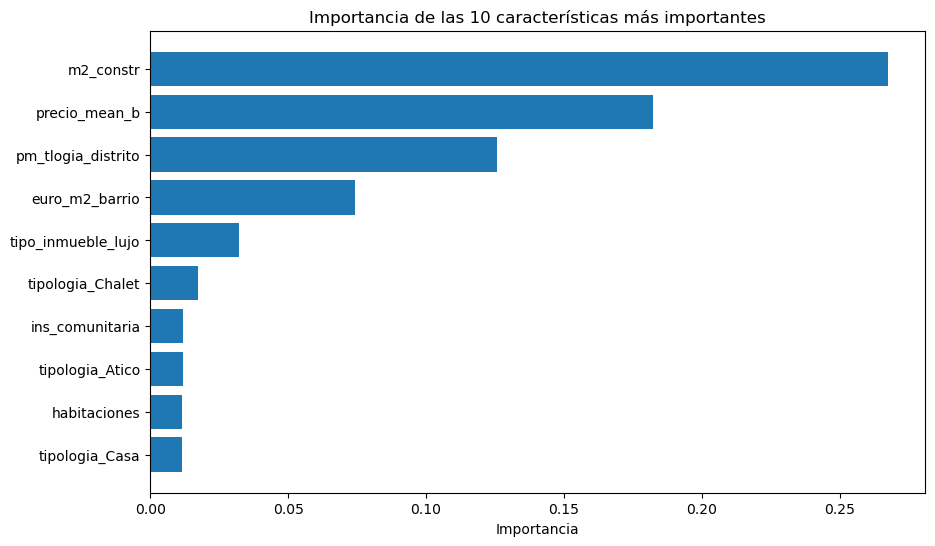

In [113]:
# Obtener la importancia de las características
importances = best_model.feature_importances_

# Ordenar las características por importancia
indices = np.argsort(importances)[::-1]

# Seleccionar las 10 características más importantes
top_n = 10
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_features = X_train.columns[top_indices]

# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances, align="center")
plt.yticks(range(top_n), top_features)
plt.xlabel("Importancia")
plt.title("Importancia de las 10 características más importantes")
plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más importante esté arriba
plt.show()

In [114]:
explainer = shap.TreeExplainer(best_model) # Instanciamos explicador
shap_values = explainer(X_train) # Se obtienen las explicaciones (SHAP values)
y_pred_raw = best_model.predict(
    X_train, 
    output_margin = True # Predicción en términos de log(odds)
)
# Comprobamos que los SHAP values suman las predicciones marginales
np.abs(shap_values.values.sum(axis = 1) + shap_values.base_values - y_pred_raw).max()

9.536743e-06

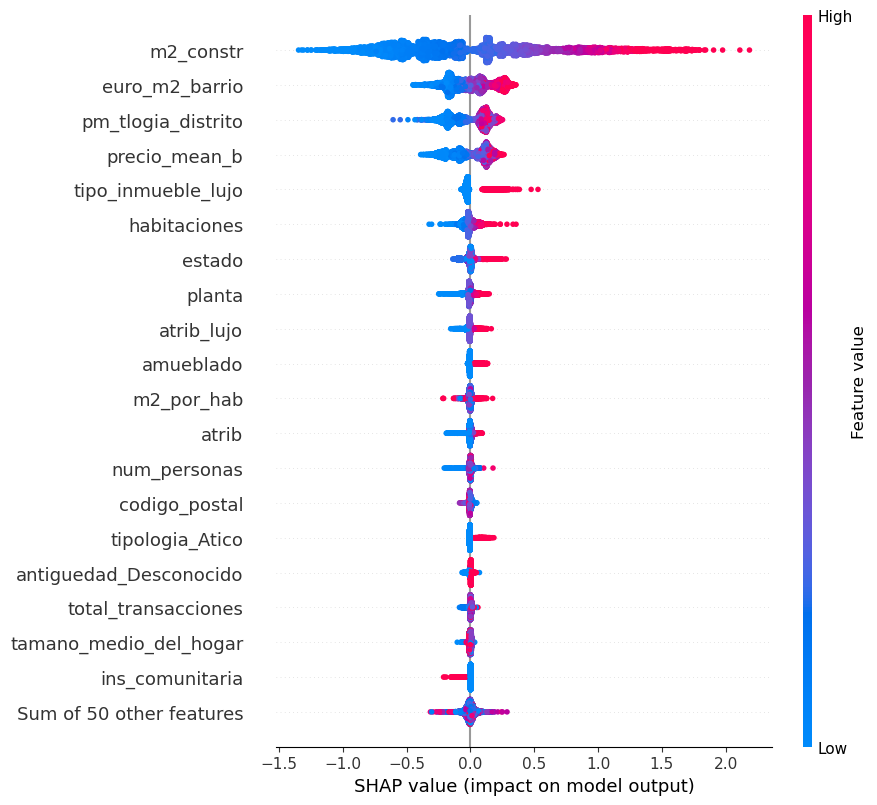

In [115]:
# Gráfico de importancia por variable para cada una de las observaciones
shap.plots.beeswarm(shap_values, max_display = 20)

Cada punto representa una observación (instancia) y muestra cómo una característica específica (en el eje vertical) influye en la predicción del modelo.
  Valores positivos aumentan la predicción.
    Valores negativos disminuyen la predicción.
      Rojo:Valores altos.
        Azul:Valores bajos.

- m2_constr es la característica más influyente en las predicciones del modelo. Valores altos (en rojo) aumentan significativamente las predicciones, mientras que valores bajos (en azul) las disminuyen
  
- cod_barrio_group:
    Contribuye significativamente, pero su efecto varía según los valores. Rojo (altos valores) parece tener un impacto negativo, mientras que azul (bajos valores) parece tener un impacto positivo.
- Otras características:
    Las características con menor importancia tienen puntos más cercanos al centro (valor SHAP cercano a 0), lo que sugiere que su contribución al modelo es mínima.


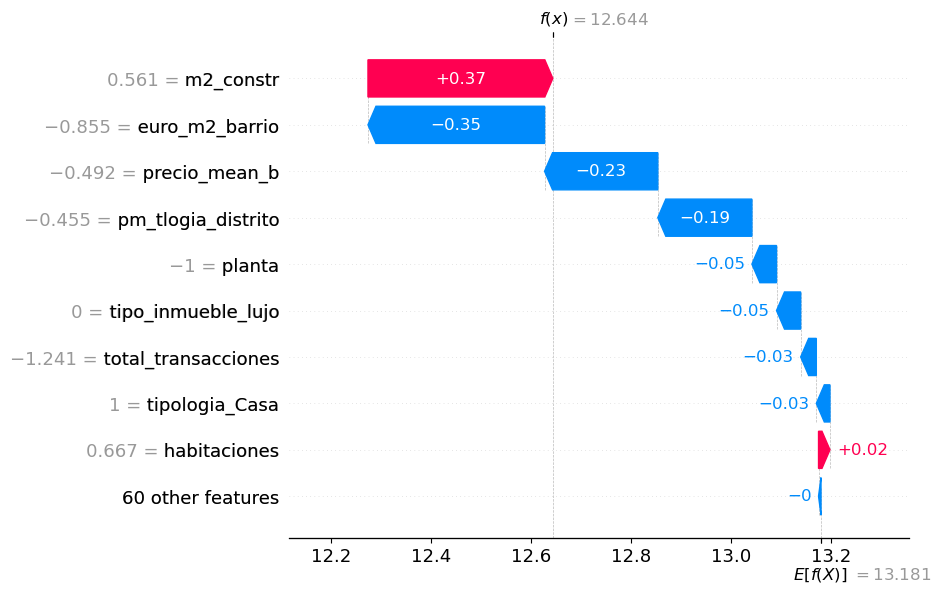

In [116]:
# Gráfico para ver cómo se pasa del explainer.expected_value al model.predict(X)[ind_obs]
ind_obs = 100
shap.plots.waterfall(shap_values[ind_obs])

Gráfico de Importancia de Características (SHAP Summary)

Características más importantes en la parte superior.
Impacto positivo o negativo de cada característica en las predicciones.

Gráfico de Predicciones vs Valores Reales: ste gráfico muestra cómo las predicciones del modelo se comparan con los valores reales del conjunto de prueba.

Es útil para detectar patrones, sesgos o errores sistemáticos.

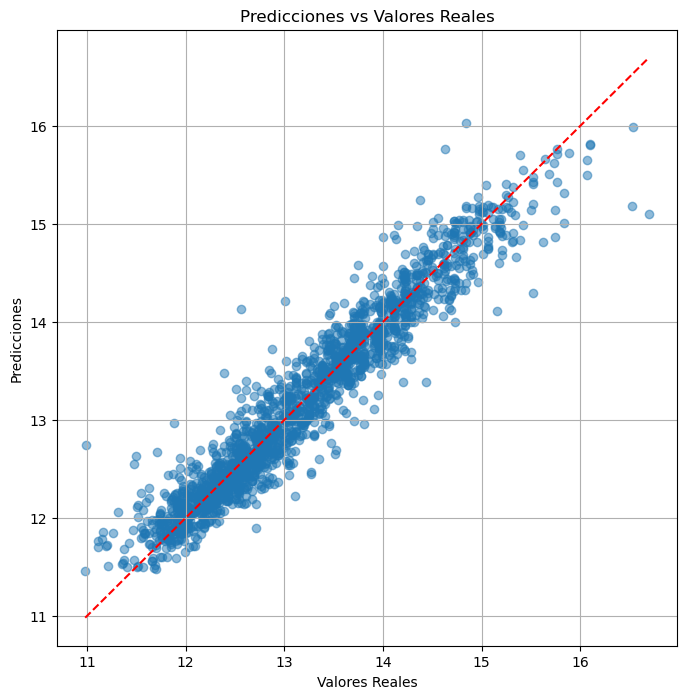

In [120]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Línea ideal (predicción perfecta)
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.grid()
plt.show()


Los puntos parecen estan bien alineados con la línea roja, lo que sugiere una alta correlación entre las predicciones y los valores reales.



In [134]:
# Revertir la normalización de X_test o valores específicos
X_test_original = scaler.inverse_transform(X_test)

In [ ]:
#Mostramos algunos de los valores outliers en la predición del conjunto de test

# Calcular errores (diferencias absolutas entre y_test y y_pred)
#errores = pd.Series(np.abs(y_train - y_pred), index=X_train.index)
errores = pd.Series(np.abs(y_test - y_pred), index=X_train.index)
# Establecer el umbral para identificar outliers (e.g., 2 desviaciones estándar)
umbral = errores.mean() + 2 * errores.std()

# Identificar índices de los outliers
outliers_indices = errores[errores > umbral].index

# Extraer IDs de las observaciones consideradas como outliers
outliers_ids = df_ids.loc[outliers_indices]

# Mostrar los IDs de los outliers
print("IDs de los outliers:")
print(outliers_ids)

# (Opcional) Extraer también las características de los outliers
#outliers_X = X_train.loc[outliers_indices]
# Convertir el array de vuelta a DataFrame utilizando las mismas columnas originales
X_test_original_df = pd.DataFrame(X_test_original, columns=X_test.columns, index=X_test.index)

# Ahora puedes usar .loc para extraer las filas correspondientes a los outliers
outliers_X = X_test_original_df.loc[outliers_indices]


print("Características de los outliers:")
print(outliers_X)

IDs de los outliers:
                                                                                                                                          url
26                                                         https://www.pisos.com/comprar/piso-villaverde_los_angeles28041-41678376162_100200/
33                                                           https://www.pisosmadrid.com.es/propiedad/4086025-piso-en-venta-en-palacio-madrid
67                                                              https://www.pisos.com/comprar/piso-hortaleza_palomas28022-47561489109_102100/
85                                                                     https://www.pisos.com/comprar/piso-guindalera28028-44193829783_102200/
186   https://www.redpiso.es/inmueble/piso-en-venta-en-calle-juan-alvarez-de-mendizabal-arguelles-moncloa-aravaca-madrid-madrid-RP71202192163
224                                                          https://www.pisos.com/comprar/piso-universidad_malasana28015-40049

2. Gráfico de Errores (Residuals):Analiza la diferencia entre los valores reales y las predicciones (residuales).

Un patrón aleatorio indica que el modelo está bien ajustado, mientras que patrones sistemáticos pueden revelar problemas como sobreajuste o falta de ajuste.

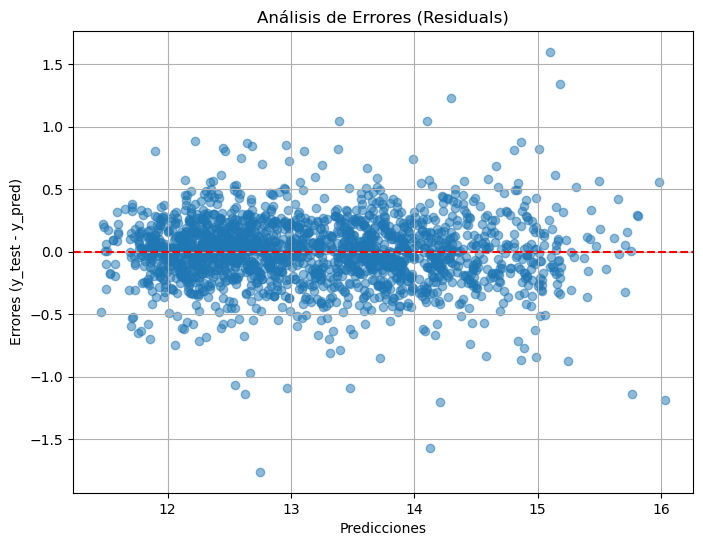

In [131]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title("Análisis de Errores (Residuals)")
plt.xlabel("Predicciones")
plt.ylabel("Errores (y_test - y_pred)")
plt.grid()
plt.show()


Los residuales deben estar distribuidos uniformemente alrededor de 0.

Patrones claros pueden señalar deficiencias en el modelo.

Distribución de los Errores: Este gráfico muestra la distribución de los errores para evaluar si tienen una forma normal.

En regresión, una distribución simétrica de los errores es deseable.

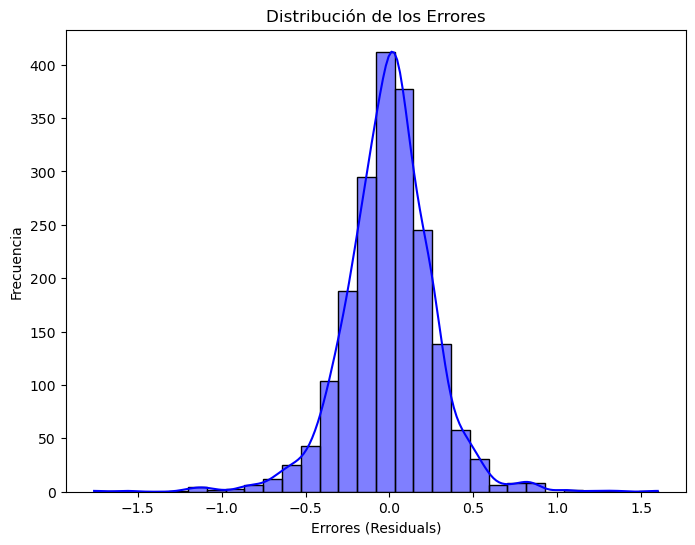

In [122]:


plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color="blue")
plt.title("Distribución de los Errores")
plt.xlabel("Errores (Residuals)")
plt.ylabel("Frecuencia")
plt.show()


La mayoría de los errores residuales (diferencia entre los valores reales y las predicciones) están concentrados alrededor de 0, lo que sujiere que el modelo está ajustando bien.

In [ ]:
Una forma de campana simétrica en el histograma sugiere que el modelo está bien ajustado.

Asimetrías o colas largas pueden indicar problemas.

In [127]:
# Revertir la normalización de X_test o valores específicos
X_test_original = scaler.inverse_transform(X_test)

In [129]:
# Calcular errores absolutos
errors = np.abs(y_test - y_pred)

# Crear un DataFrame para analizar
results_df = pd.DataFrame({
    "Valores Reales": y_test,
    "Predicciones": y_pred,
    "Errores Absolutos": errors
})

# Ordenar por los errores más grandes
results_df_sorted = results_df.sort_values(by="Errores Absolutos", ascending=False)

# Mostrar los datos con mayores errores
print(results_df_sorted.head(10))  # Los 10 datos con mayores errores


      Valores Reales  Predicciones  Errores Absolutos
1816           10.99         12.74               1.76
256            16.69         15.10               1.60
1412           12.56         14.13               1.57
840            16.52         15.18               1.34
1377           15.52         14.30               1.22
714            13.01         14.21               1.20
1426           14.85         16.03               1.19
821            14.63         15.77               1.14
1826           11.49         12.63               1.14
936            11.88         12.97               1.09


In [125]:
# Revertir características de los datos con los mayores errores
errores_mayores_indices = results_df_sorted.head(10).index  # Índices con mayores errores
X_fallos_original = scaler.inverse_transform(X_test.loc[errores_mayores_indices])


Gráfico de Curva de Aprendizaje:Evalúa cómo varía el desempeño del modelo con respecto al tamaño del conjunto de entrenamiento.

Ayuda a detectar si el modelo tiene problemas de sobreajuste o subajuste.

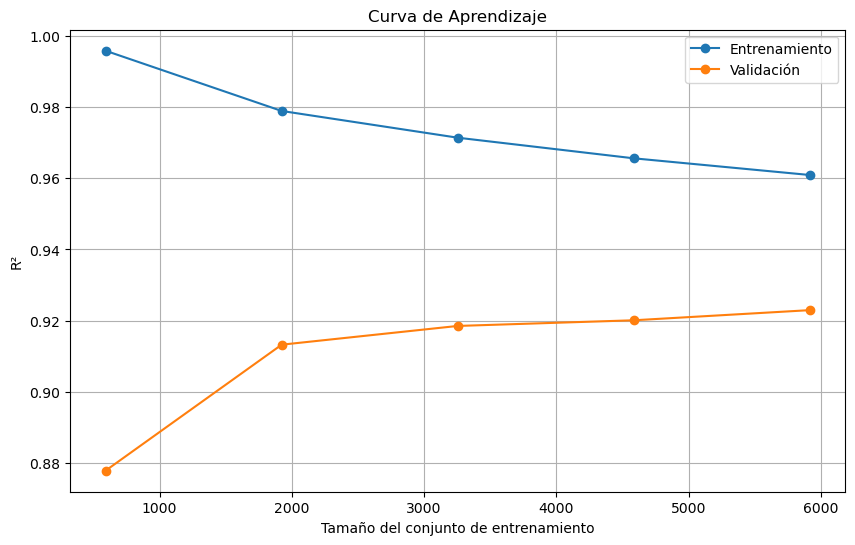

In [123]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=4, scoring="r2", n_jobs=-1
)
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Entrenamiento", marker="o")
plt.plot(train_sizes, test_scores_mean, label="Validación", marker="o")
plt.title("Curva de Aprendizaje")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("R²")
plt.legend()
plt.grid()
plt.show()


La diferencia entre la línea azul y naranja se reduce conforme aumenta el tamaño de entrenamiento, lo que indica que el modelo no está sobreajustando y tiene un buen balance.

In [117]:


# 5. Guardar el mejor modelo (según R² en test)
best_model_name = df_metrics.index[0]
best_model = models_params[best_model_name]["model"]
final_model = best_model.fit(X_train, y_train)
with open("modelo_final.pkl", "wb") as f:
    pickle.dump(final_model, f)
print(f"\nEl modelo final ({best_model_name}) ha sido guardado como 'modelo_final.pkl'.")



El modelo final (SVR) ha sido guardado como 'modelo_final.pkl'.




House Prices - Advanced Regression Techniques



Se ha escogido este tema ya que el tema de la vivienda en España en la actualidad es un tema polémico y de una gran problemática.

Nuestro objetivo es predecir el precio de venta de unas viviendas utilizando las diferentes características de las mismas. Para poder hacerlo contaremos con un dataset con 1460 viviendas localizadas en Ames Lowa (USA), distribuidas en 80 variables.

Para poder indagar más acerca esta competencia de Kaggle pulsar en el siguiente enlace

Objetivos TFM
Desarrollar un modelo de regresión avanzado que pueda predecir con precisión los precios de las viviendas. Esto puede involucrar la exploración de diferentes técnicas de regresión, como la regresión lineal, la regresión polinómica, la regresión por bosques aleatorios, la regresión por redes neuronales, etc.

Realizar un análisis exploratorio de los datos para identificar patrones, relaciones y características importantes en el conjunto de datos de precios de viviendas. Esto puede incluir la identificación de valores atípicos, la imputación de valores faltantes, la exploración de la distribución de las variables, la identificación de correlaciones entre variables, etc.

Optimizar los hiperparámetros del modelo para mejorar la precisión de las predicciones. Esto puede requerir la implementación de técnicas de validación cruzada para evaluar diferentes configuraciones de hiperparámetros y seleccionar la que mejor se ajuste al conjunto de datos.

Realizar un análisis para evaluar cómo afectan las diferentes variables del modelo a las predicciones de los precios de las viviendas. Esto puede ayudar a identificar las variables más importantes y a proporcionar información sobre cómo los cambios en las variables afectan los precios de las viviendas.

Desarrollar visualizaciones que ayuden a comunicar los resultados del modelo y las principales conclusiones del análisis exploratorio de los datos. Esto puede incluir la creación de gráficos de dispersión, diagramas de caja, mapas de calor, diagramas de barras, etc.

Poner en práctica todos los conocimientos adquiridos durante la realización del Máster

Una vez definidos los objetivos a conseguir con nuestro TFM cargamos todas las librerías que son necesarias para nuestro trabajo

# Avoid warnings
import warnings
warnings.filterwarnings('ignore')

# Análisis exploratorio de datos:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import style
style.use("ggplot")
import missingno
from scipy import stats
from scipy.stats import shapiro, norm, skew, boxcox
from scipy.special import boxcox1p
import re
from collections import OrderedDict

# Preprocesamiento de datos:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline


# Modelización:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn import tree

from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor

from sklearn.pipeline import make_pipeline

from sklearn.neighbors import KNeighborsRegressor

from sklearn.inspection import permutation_importance

from sklearn.svm import SVR
import xgboost as xgb

# Visualización:
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import plotly.graph_objs as go

# Recuperar datos
import requests
ÍNDICE

1. Lectura de Datos
2. Análisis exploratorio (EDA)
2.1 Primer vistazo a los datos
2.2 Variable target
2.3 Variables numéricas
2.3.1 Variables numéricas discretas
2.3.2 Variables numéricas continuas
2.4 Variables categóricas
2.5 Valores nulos
3. Preprocesado y análisis de datos
3.1 Nulos variables numéricas
3.2 Nulos variables categóricas
3.3 Convertir variables categóricas a numéricas
4. Feature Engineering
4.1 Primeros pasos
4.2 Creación de nuevas categorías
4.3 Transformación logarítmica de la variable target ('SalePrice')
4.4 Transformación Box-Cox de las variables excesivamente asimétricas
4.5 Escalado de variables numéricas
4.6 Variables Dummies
5. Modelos
5.1 Estrategias
5.2 Regresión Lineal
5.3 Regresión Ridge
5.4 Regresión Lasso
5.5 Modelo de los K vecinos más cercanos
5.6 Árboles de decisión
5.7 Modelo Random Forest
5.8 Modelo Regresor de vectores de apoyo (SVR)
5.9 Modelo Gradient Boosting Regressor
5.10 Modelo Stacked Regressor
6. Predicción
6.1 Valores
6.2 Características más importantes del modelo
6.3 Exportación modelo final (Stacked Regressor)
CONCLUSIONES
BIBLIOGRAFÍA

1. Lectura de Datos
En primer lugar importamos los dos datasets (train y test) y los almacenamos en dos dataframes de Pandas.

# Leer los datasets
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
# Comprobar el tamaño del df Train
train.shape
(1460, 81)
# Comprobar el tamaño del df Test
test.shape
(1459, 80)
# Mostramos el tamaño
print('Tamaño de tabla de valores entrenamiento:',train.shape[0])
print('Tamaño de tabla para predicciones:',test.shape[0])
Tamaño de tabla de valores entrenamiento: 1460
Tamaño de tabla para predicciones: 1459
El dataset de train está compuesto por 81 columnas y 1460 entradas. Vamos a visualizar el nombre de sus colmunas.

print(train.columns.values)
['Id' 'MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle'
 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'MasVnrArea'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF'
 '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual'
 'TotRmsAbvGrd' 'Functional' 'Fireplaces' 'FireplaceQu' 'GarageType'
 'GarageYrBlt' 'GarageFinish' 'GarageCars' 'GarageArea' 'GarageQual'
 'GarageCond' 'PavedDrive' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'PoolQC' 'Fence' 'MiscFeature'
 'MiscVal' 'MoSold' 'YrSold' 'SaleType' 'SaleCondition' 'SalePrice']
Y los primeros 5 valores de cada una de ellas

train.head(5)
Id	MSSubClass	MSZoning	LotFrontage	LotArea	Street	Alley	LotShape	LandContour	Utilities	...	PoolArea	PoolQC	Fence	MiscFeature	MiscVal	MoSold	YrSold	SaleType	SaleCondition	SalePrice
0	1	60	RL	65.0	8450	Pave	NaN	Reg	Lvl	AllPub	...	0	NaN	NaN	NaN	0	2	2008	WD	Normal	208500
1	2	20	RL	80.0	9600	Pave	NaN	Reg	Lvl	AllPub	...	0	NaN	NaN	NaN	0	5	2007	WD	Normal	181500
2	3	60	RL	68.0	11250	Pave	NaN	IR1	Lvl	AllPub	...	0	NaN	NaN	NaN	0	9	2008	WD	Normal	223500
3	4	70	RL	60.0	9550	Pave	NaN	IR1	Lvl	AllPub	...	0	NaN	NaN	NaN	0	2	2006	WD	Abnorml	140000
4	5	60	RL	84.0	14260	Pave	NaN	IR1	Lvl	AllPub	...	0	NaN	NaN	NaN	0	12	2008	WD	Normal	250000
5 rows × 81 columns

Este es un resumen de todas nuestras variables:

SalePrice: Es el precio de la propiedad en dólares. Esta es nuestra variable target.
MSSubClass: La clase de edificio.
MSZoning: La clasificación general por zonas
LotFrontage: la longitd en pies lineales de calle conectada con la propiedad
LotArea: Tamaño del lote en pies cuadrados
Street: Tipo de acceso por carretera
Alley: Tipo de acceso al callejón
LotShape: Forma general de la propiedad
LandContour: Planitud de la propiedad
Utilities: Tipos de servicios disponibles
LotConfig: Configuración de la parcela
LandSlope: Pendiente de la propiedad
Neighborhood: Ubicación física dentro de los límites de la ciudad de Ames
Condition1: Proximidad a carretera principal o ferrocarril
Condition2: Proximidad a carretera principal o ferrocarril (si existe una segunda)
BldgType: Tipo de vivienda
HouseStyle: Estilo de la vivienda
OverallQual: Calidad general de materiales y acabados
OverallCond: Estado de conservación general
YearBuilt: Fecha de construcción original
YearRemodAdd: Fecha de remodelación
RoofStyle: Tipo de tejado
RoofMatl: Material del tejado
Exterior1st: Revestimiento exterior de la casa
Exterior2nd: Revestimiento exterior de la casa (si hay más de un material)
MasVnrType: Tipo de revestimiento de mampostería
MasVnrArea: Área del revestimiento de mampostería en pies cuadrados
ExterQual: Calidad del material exterior
ExterCond: Estado actual del material en el exterior
Foundation: Tipo de cimentación
BsmtQual: Altura del sótano
BsmtCond: Estado general del sótano
BsmtExposure: Muros del sótano a nivel de jardín o con salida al exterior
BsmtFinType1: Calidad de la superficie acabada del sótano
BsmtFinSF1: Tipo 1 pies cuadrados acabados
BsmtFinType2: Calidad de la segunda superficie acabada (si existe)
BsmtFinSF2: Pies cuadrados acabados de tipo 2
BsmtUnfSF: Pies cuadrados sin terminar de la superficie del sótano
TotalBsmtSF: Superficie total del sótano en pies cuadrados
Heating: Tipo de calefacción
HeatingQC: Estado y calidad de la calefacción
CentralAir: Aire acondicionado central
Electrical: Sistema eléctrico
1stFlrSF: Pies cuadrados del primer piso
2ndFlrSF: Pies cuadrados del segundo piso
LowQualFinSF: Superficie de acabados de baja calidad en pies cuadrados (en todas las plantas)
GrLivArea: Superficie habitable por encima del nivel del suelo en pies cuadrados
BsmtFullBath: Baños completos del sótano
BsmtHalfBath: Medios baños del sótano
FullBath: Baños completos sobre rasante
HalfBath: Medios baños sobre rasante
Bedroom: Número de habitaciones sobre rastante
Kitchen: Número de cocinas
KitchenQual: Calidad de las cocinas
TotRmsAbvGrd: Número total de habitaciones sobre raante (no incluye baños)
Functional: Rating de funcionalidad de la vivienda
Fireplaces: Número de chimeneas
FireplaceQu: Calidad de las chimeneas
GarageType: Ubicación del garaje
GarageYrBlt: Fecha de construcción del garaje
GarageFinish: Acabado interior del garaje
GarageCars: Tamaño del garaje en capacidad de coches
GarageArea: Tamaño del garaje en pies cuadrados
GarageQual: Calidad del garaje
GarageCond: Estado del garaje
PavedDrive: Calzada pavimentada
WoodDeckSF: Superficie de la cubierta de madera en pies cuadrados
OpenPorchSF: Área de porche abierto en pies cuadrados
EnclosedPorch: Superficie del porche cerrado en pies cuadrados
3SsnPorch: Superficie del porche 3Estaciones en pies cuadrados
ScreenPorch: Área de porche vidriado en pies cuadrados
PoolArea: Área de la piscina en pies cuadrados
PoolQC: Calidad de la piscina
Fence: Calidad de la valla
MiscFeature: Característica miscelánea no incluida en otras categorías
MiscVal: Valor de la característica miscelánea
MoSold: Mes de venta
YrSold: Año de venta
SaleType: Tipo de venta
SaleCondition: Condición de venta
Podemos observar que se podrían empezar a agrupar en los siguientes grupos:

'Id'
Variable Target: 'SalePrice'
Información del lote: 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope'
Información de construcción: 'MSSubClass', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical'
Información de la vivienda: '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu'
Información del garaje: 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond'
Información de la terraza y porche: 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'
Información de la piscina y la cerca: 'PoolArea', 'PoolQC', 'Fence'
Información diversa: 'MiscFeature', 'MiscVal'
Información de la venta: 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'

2. Análisis exploratorio (EDA)

2.1 Primer vistazo a los datos
Creamos una función para simplificar el análisis de las características generales de los datos. Esta función devuelve los tipos, recuentos, distintos, recuentos nulos, proporción de faltantes y valores únicos de cada campo/característica.

Una vez que se han calculado estas estadísticas para cada columna, se concatena todo en un único dataframe utilizando el método "concat". Luego, la función crea una lista de nombres de columna para el dataframe resumen y asigna esta lista como el atributo "columns" del dataframe resumen. Finalmente, se devuelve el dataframe resumen.

La función también establece algunas opciones de visualización de pandas para asegurarse de que todas las columnas se muestren en el resumen y de que los números se muestren con dos decimales.

def dataframe_summary(train):
    """Generamos una función que nos genera un sumario del dataframe, incluyendo tipos de datos, valores únicos..."""
    
    obs = train.shape[0] #Número de filas
    types = train.dtypes #Tipos de datos
    counts = train.apply(lambda x: x.count()) #Número total
    distincts = train.apply(lambda x: x.nunique()) #Valores únicos
    nulls = train.isnull().sum() #Número total de nulos
    missing_ratio = (nulls / obs) * 100 #Porcentaje de missings respecto al total
    skewness = train.select_dtypes(include='number').skew() #Asimetría
    kurtosis = train.select_dtypes(include='number').kurt() #Curtosis
    top_vals = train.apply(lambda x: x.value_counts(dropna=False).index[0]) #Valores más repetidos
    top_counts = train.apply(lambda x: x.value_counts(dropna=False).iloc[0]) #La moda de cada variable
    top_percent = (top_counts / obs) * 100 #Porcentaje del que más se repite
    
    #Concatenamos todos
    summary_df = pd.concat([types, counts, distincts, nulls, missing_ratio, top_vals, top_counts, top_percent, skewness, kurtosis], axis=1)
    
    #Creamos las columnas
    summary_df.columns = ["Type", "Count", "Distinct", "Missing", "Missing_Ratio", "Most_Common", "Most_Common_Count", "Most_Common_Percent", "Skewness", "Kurtosis"]
    
    return summary_df

pd.set_option('display.max_columns', None) #Mostramos todas las columnas
pd.options.display.float_format = '{:.2f}'.format #Mostramos solamente dos decimales
HTML(dataframe_summary(train).to_html(classes=["table-bordered", "table-striped", "table-hover"])) #Aplicamos formato HTML
Type	Count	Distinct	Missing	Missing_Ratio	Most_Common	Most_Common_Count	Most_Common_Percent	Skewness	Kurtosis
Id	int64	1460	1460	0	0.00	1	1	0.07	0.00	-1.20
MSSubClass	int64	1460	15	0	0.00	20	536	36.71	1.41	1.58
MSZoning	object	1460	5	0	0.00	RL	1151	78.84	NaN	NaN
LotFrontage	float64	1201	110	259	17.74	NaN	259	17.74	2.16	17.45
LotArea	int64	1460	1073	0	0.00	7200	25	1.71	12.21	203.24
Street	object	1460	2	0	0.00	Pave	1454	99.59	NaN	NaN
Alley	object	91	2	1369	93.77	NaN	1369	93.77	NaN	NaN
LotShape	object	1460	4	0	0.00	Reg	925	63.36	NaN	NaN
LandContour	object	1460	4	0	0.00	Lvl	1311	89.79	NaN	NaN
Utilities	object	1460	2	0	0.00	AllPub	1459	99.93	NaN	NaN
LotConfig	object	1460	5	0	0.00	Inside	1052	72.05	NaN	NaN
LandSlope	object	1460	3	0	0.00	Gtl	1382	94.66	NaN	NaN
Neighborhood	object	1460	25	0	0.00	NAmes	225	15.41	NaN	NaN
Condition1	object	1460	9	0	0.00	Norm	1260	86.30	NaN	NaN
Condition2	object	1460	8	0	0.00	Norm	1445	98.97	NaN	NaN
BldgType	object	1460	5	0	0.00	1Fam	1220	83.56	NaN	NaN
HouseStyle	object	1460	8	0	0.00	1Story	726	49.73	NaN	NaN
OverallQual	int64	1460	10	0	0.00	5	397	27.19	0.22	0.10
OverallCond	int64	1460	9	0	0.00	5	821	56.23	0.69	1.11
YearBuilt	int64	1460	112	0	0.00	2006	67	4.59	-0.61	-0.44
YearRemodAdd	int64	1460	61	0	0.00	1950	178	12.19	-0.50	-1.27
RoofStyle	object	1460	6	0	0.00	Gable	1141	78.15	NaN	NaN
RoofMatl	object	1460	8	0	0.00	CompShg	1434	98.22	NaN	NaN
Exterior1st	object	1460	15	0	0.00	VinylSd	515	35.27	NaN	NaN
Exterior2nd	object	1460	16	0	0.00	VinylSd	504	34.52	NaN	NaN
MasVnrType	object	1452	4	8	0.55	None	864	59.18	NaN	NaN
MasVnrArea	float64	1452	327	8	0.55	0.00	861	58.97	2.67	10.08
ExterQual	object	1460	4	0	0.00	TA	906	62.05	NaN	NaN
ExterCond	object	1460	5	0	0.00	TA	1282	87.81	NaN	NaN
Foundation	object	1460	6	0	0.00	PConc	647	44.32	NaN	NaN
BsmtQual	object	1423	4	37	2.53	TA	649	44.45	NaN	NaN
BsmtCond	object	1423	4	37	2.53	TA	1311	89.79	NaN	NaN
BsmtExposure	object	1422	4	38	2.60	No	953	65.27	NaN	NaN
BsmtFinType1	object	1423	6	37	2.53	Unf	430	29.45	NaN	NaN
BsmtFinSF1	int64	1460	637	0	0.00	0	467	31.99	1.69	11.12
BsmtFinType2	object	1422	6	38	2.60	Unf	1256	86.03	NaN	NaN
BsmtFinSF2	int64	1460	144	0	0.00	0	1293	88.56	4.26	20.11
BsmtUnfSF	int64	1460	780	0	0.00	0	118	8.08	0.92	0.47
TotalBsmtSF	int64	1460	721	0	0.00	0	37	2.53	1.52	13.25
Heating	object	1460	6	0	0.00	GasA	1428	97.81	NaN	NaN
HeatingQC	object	1460	5	0	0.00	Ex	741	50.75	NaN	NaN
CentralAir	object	1460	2	0	0.00	Y	1365	93.49	NaN	NaN
Electrical	object	1459	5	1	0.07	SBrkr	1334	91.37	NaN	NaN
1stFlrSF	int64	1460	753	0	0.00	864	25	1.71	1.38	5.75
2ndFlrSF	int64	1460	417	0	0.00	0	829	56.78	0.81	-0.55
LowQualFinSF	int64	1460	24	0	0.00	0	1434	98.22	9.01	83.23
GrLivArea	int64	1460	861	0	0.00	864	22	1.51	1.37	4.90
BsmtFullBath	int64	1460	4	0	0.00	0	856	58.63	0.60	-0.84
BsmtHalfBath	int64	1460	3	0	0.00	0	1378	94.38	4.10	16.40
FullBath	int64	1460	4	0	0.00	2	768	52.60	0.04	-0.86
HalfBath	int64	1460	3	0	0.00	0	913	62.53	0.68	-1.08
BedroomAbvGr	int64	1460	8	0	0.00	3	804	55.07	0.21	2.23
KitchenAbvGr	int64	1460	4	0	0.00	1	1392	95.34	4.49	21.53
KitchenQual	object	1460	4	0	0.00	TA	735	50.34	NaN	NaN
TotRmsAbvGrd	int64	1460	12	0	0.00	6	402	27.53	0.68	0.88
Functional	object	1460	7	0	0.00	Typ	1360	93.15	NaN	NaN
Fireplaces	int64	1460	4	0	0.00	0	690	47.26	0.65	-0.22
FireplaceQu	object	770	5	690	47.26	NaN	690	47.26	NaN	NaN
GarageType	object	1379	6	81	5.55	Attchd	870	59.59	NaN	NaN
GarageYrBlt	float64	1379	97	81	5.55	NaN	81	5.55	-0.65	-0.42
GarageFinish	object	1379	3	81	5.55	Unf	605	41.44	NaN	NaN
GarageCars	int64	1460	5	0	0.00	2	824	56.44	-0.34	0.22
GarageArea	int64	1460	441	0	0.00	0	81	5.55	0.18	0.92
GarageQual	object	1379	5	81	5.55	TA	1311	89.79	NaN	NaN
GarageCond	object	1379	5	81	5.55	TA	1326	90.82	NaN	NaN
PavedDrive	object	1460	3	0	0.00	Y	1340	91.78	NaN	NaN
WoodDeckSF	int64	1460	274	0	0.00	0	761	52.12	1.54	2.99
OpenPorchSF	int64	1460	202	0	0.00	0	656	44.93	2.36	8.49
EnclosedPorch	int64	1460	120	0	0.00	0	1252	85.75	3.09	10.43
3SsnPorch	int64	1460	20	0	0.00	0	1436	98.36	10.30	123.66
ScreenPorch	int64	1460	76	0	0.00	0	1344	92.05	4.12	18.44
PoolArea	int64	1460	8	0	0.00	0	1453	99.52	14.83	223.27
PoolQC	object	7	3	1453	99.52	NaN	1453	99.52	NaN	NaN
Fence	object	281	4	1179	80.75	NaN	1179	80.75	NaN	NaN
MiscFeature	object	54	4	1406	96.30	NaN	1406	96.30	NaN	NaN
MiscVal	int64	1460	21	0	0.00	0	1408	96.44	24.48	701.00
MoSold	int64	1460	12	0	0.00	6	253	17.33	0.21	-0.40
YrSold	int64	1460	5	0	0.00	2009	338	23.15	0.10	-1.19
SaleType	object	1460	9	0	0.00	WD	1267	86.78	NaN	NaN
SaleCondition	object	1460	6	0	0.00	Normal	1198	82.05	NaN	NaN
SalePrice	int64	1460	663	0	0.00	140000	20	1.37	1.88	6.54
Nuestro conjunto consta de tres tipos de datos:
  - Float
  - Integer
  - Object    
En conjunto, nos encontramos con un total de 81 variables:
  - 43 características de tipo categórico
  - 38 características numéricas de las cuales 1 es nuestra variable target "SalePrice" y otra es el "Id".        
Hay algunas características que tienen asignado el tipo de datos de manera incorrecta como por ejemplo: MSSubClass y OverallCond deberían ser tipos de datos objeto.
Nulos: Los datos tienen 19 características con nulos, cinco de ellas categóricas y con más de un 47% de ratios perdidos. Tendremos que pensar en como tratar esos nulos, o directamente eliminarlas:
  - PoolQC
  - MiscFeature
  - Alley
  - Fence
  - FireplaceQu
Tenemos categorías con una alta correlación con 'SalePrice', con una correlación menor, sesgadas para la derecha etc, todo esto lo analizaremos más en detalle más adelante.
# Convertimos estas 2 a tipo objeto
train[['MSSubClass', 'OverallCond']] = train[['MSSubClass', 'OverallCond']].astype('object')
test[['MSSubClass', 'OverallCond']] = test[['MSSubClass', 'OverallCond']].astype('object')
Ya que no es necesaria para el proceso de predicción almacenaremos nuestra variable "Id" en unos datasets a parte y la eliminamos de nuestros datasets principales.

#Almacenamos ID
train_ID = train['Id']
test_ID = test['Id']

#Eliminamos Id
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)
train.head(3)
MSSubClass	MSZoning	LotFrontage	LotArea	Street	Alley	LotShape	LandContour	Utilities	LotConfig	LandSlope	Neighborhood	Condition1	Condition2	BldgType	HouseStyle	OverallQual	OverallCond	YearBuilt	YearRemodAdd	RoofStyle	RoofMatl	Exterior1st	Exterior2nd	MasVnrType	MasVnrArea	ExterQual	ExterCond	Foundation	BsmtQual	BsmtCond	BsmtExposure	BsmtFinType1	BsmtFinSF1	BsmtFinType2	BsmtFinSF2	BsmtUnfSF	TotalBsmtSF	Heating	HeatingQC	CentralAir	Electrical	1stFlrSF	2ndFlrSF	LowQualFinSF	GrLivArea	BsmtFullBath	BsmtHalfBath	FullBath	HalfBath	BedroomAbvGr	KitchenAbvGr	KitchenQual	TotRmsAbvGrd	Functional	Fireplaces	FireplaceQu	GarageType	GarageYrBlt	GarageFinish	GarageCars	GarageArea	GarageQual	GarageCond	PavedDrive	WoodDeckSF	OpenPorchSF	EnclosedPorch	3SsnPorch	ScreenPorch	PoolArea	PoolQC	Fence	MiscFeature	MiscVal	MoSold	YrSold	SaleType	SaleCondition	SalePrice
0	60	RL	65.00	8450	Pave	NaN	Reg	Lvl	AllPub	Inside	Gtl	CollgCr	Norm	Norm	1Fam	2Story	7	5	2003	2003	Gable	CompShg	VinylSd	VinylSd	BrkFace	196.00	Gd	TA	PConc	Gd	TA	No	GLQ	706	Unf	0	150	856	GasA	Ex	Y	SBrkr	856	854	0	1710	1	0	2	1	3	1	Gd	8	Typ	0	NaN	Attchd	2003.00	RFn	2	548	TA	TA	Y	0	61	0	0	0	0	NaN	NaN	NaN	0	2	2008	WD	Normal	208500
1	20	RL	80.00	9600	Pave	NaN	Reg	Lvl	AllPub	FR2	Gtl	Veenker	Feedr	Norm	1Fam	1Story	6	8	1976	1976	Gable	CompShg	MetalSd	MetalSd	None	0.00	TA	TA	CBlock	Gd	TA	Gd	ALQ	978	Unf	0	284	1262	GasA	Ex	Y	SBrkr	1262	0	0	1262	0	1	2	0	3	1	TA	6	Typ	1	TA	Attchd	1976.00	RFn	2	460	TA	TA	Y	298	0	0	0	0	0	NaN	NaN	NaN	0	5	2007	WD	Normal	181500
2	60	RL	68.00	11250	Pave	NaN	IR1	Lvl	AllPub	Inside	Gtl	CollgCr	Norm	Norm	1Fam	2Story	7	5	2001	2002	Gable	CompShg	VinylSd	VinylSd	BrkFace	162.00	Gd	TA	PConc	Gd	TA	Mn	GLQ	486	Unf	0	434	920	GasA	Ex	Y	SBrkr	920	866	0	1786	1	0	2	1	3	1	Gd	6	Typ	1	TA	Attchd	2001.00	RFn	2	608	TA	TA	Y	0	42	0	0	0	0	NaN	NaN	NaN	0	9	2008	WD	Normal	223500

2.2 Variable target
Hacemos un primer análisis rápido de nuestra variable target

# Mostrar algunas características de la variable target
print(train['SalePrice'].describe())
# Imprimir la distribución
plt.figure(figsize=(9, 8))
sns.displot(train['SalePrice'], color='g', bins=100, alpha=0.4, kde=True);
count     1460.00
mean    180921.20
std      79442.50
min      34900.00
25%     129975.00
50%     163000.00
75%     214000.00
max     755000.00
Name: SalePrice, dtype: float64
<Figure size 900x800 with 0 Axes>

Observamos que el 50% de los valores se sitúan por debajo de 163000, que casi coincide con la media de todos los valores (180921). También observamos que un 75% de los valores se encuentran situados en cantidades inferiores a 214000.

También obervamos que nuestra variable target tiene una distribución muy similar a otras variables categóricas como son:

- LotFrontage, TotalBsmtSF, BsmtHalfBath, FullBath, KitchenAbvGr y PoolArea.
# Crear una figura con cinco subtramas y establecer su tamaño
fig, axs = plt.subplots(1, 6, figsize=(20, 5))

# Generar un histograma para cada variable y mostrarlo en su subtrama correspondiente
sns.histplot(train['LotFrontage'], ax=axs[0])
sns.histplot(train['TotalBsmtSF'], ax=axs[1])
sns.histplot(train['BsmtHalfBath'], ax=axs[2])
sns.histplot(train['FullBath'], ax=axs[3])
sns.histplot(train['KitchenAbvGr'], ax=axs[4])
sns.histplot(train['PoolArea'], ax=axs[5])
<AxesSubplot: xlabel='PoolArea', ylabel='Count'>

Ahora vamos a separar a las variables entre numéricas y categóricas para un mejor análisis

# Separación de variables numéricas y categóricas.
cat_var = train.select_dtypes(include=['object'])
num_var = train.select_dtypes(exclude=['object'])

2.3 Variables numéricas
# Generamos un resumen estadístico y las numéricas y las trasponemos
display(num_var.describe().transpose())
count	mean	std	min	25%	50%	75%	max
LotFrontage	1201.00	70.05	24.28	21.00	59.00	69.00	80.00	313.00
LotArea	1460.00	10516.83	9981.26	1300.00	7553.50	9478.50	11601.50	215245.00
OverallQual	1460.00	6.10	1.38	1.00	5.00	6.00	7.00	10.00
YearBuilt	1460.00	1971.27	30.20	1872.00	1954.00	1973.00	2000.00	2010.00
YearRemodAdd	1460.00	1984.87	20.65	1950.00	1967.00	1994.00	2004.00	2010.00
MasVnrArea	1452.00	103.69	181.07	0.00	0.00	0.00	166.00	1600.00
BsmtFinSF1	1460.00	443.64	456.10	0.00	0.00	383.50	712.25	5644.00
BsmtFinSF2	1460.00	46.55	161.32	0.00	0.00	0.00	0.00	1474.00
BsmtUnfSF	1460.00	567.24	441.87	0.00	223.00	477.50	808.00	2336.00
TotalBsmtSF	1460.00	1057.43	438.71	0.00	795.75	991.50	1298.25	6110.00
1stFlrSF	1460.00	1162.63	386.59	334.00	882.00	1087.00	1391.25	4692.00
2ndFlrSF	1460.00	346.99	436.53	0.00	0.00	0.00	728.00	2065.00
LowQualFinSF	1460.00	5.84	48.62	0.00	0.00	0.00	0.00	572.00
GrLivArea	1460.00	1515.46	525.48	334.00	1129.50	1464.00	1776.75	5642.00
BsmtFullBath	1460.00	0.43	0.52	0.00	0.00	0.00	1.00	3.00
BsmtHalfBath	1460.00	0.06	0.24	0.00	0.00	0.00	0.00	2.00
FullBath	1460.00	1.57	0.55	0.00	1.00	2.00	2.00	3.00
HalfBath	1460.00	0.38	0.50	0.00	0.00	0.00	1.00	2.00
BedroomAbvGr	1460.00	2.87	0.82	0.00	2.00	3.00	3.00	8.00
KitchenAbvGr	1460.00	1.05	0.22	0.00	1.00	1.00	1.00	3.00
TotRmsAbvGrd	1460.00	6.52	1.63	2.00	5.00	6.00	7.00	14.00
Fireplaces	1460.00	0.61	0.64	0.00	0.00	1.00	1.00	3.00
GarageYrBlt	1379.00	1978.51	24.69	1900.00	1961.00	1980.00	2002.00	2010.00
GarageCars	1460.00	1.77	0.75	0.00	1.00	2.00	2.00	4.00
GarageArea	1460.00	472.98	213.80	0.00	334.50	480.00	576.00	1418.00
WoodDeckSF	1460.00	94.24	125.34	0.00	0.00	0.00	168.00	857.00
OpenPorchSF	1460.00	46.66	66.26	0.00	0.00	25.00	68.00	547.00
EnclosedPorch	1460.00	21.95	61.12	0.00	0.00	0.00	0.00	552.00
3SsnPorch	1460.00	3.41	29.32	0.00	0.00	0.00	0.00	508.00
ScreenPorch	1460.00	15.06	55.76	0.00	0.00	0.00	0.00	480.00
PoolArea	1460.00	2.76	40.18	0.00	0.00	0.00	0.00	738.00
MiscVal	1460.00	43.49	496.12	0.00	0.00	0.00	0.00	15500.00
MoSold	1460.00	6.32	2.70	1.00	5.00	6.00	8.00	12.00
YrSold	1460.00	2007.82	1.33	2006.00	2007.00	2008.00	2009.00	2010.00
SalePrice	1460.00	180921.20	79442.50	34900.00	129975.00	163000.00	214000.00	755000.00
Existen dos tipos de características numéricas en nuestro dataset:

        - Discretas: aquellas que solo puede tomar un conjunto limitado de valores aislados y separados, generalmente enteros
        - Continuas: pueden tomar cualquier valor dentro de un intervalo o rango específico.

Al contar con características numéricas discretas es mejor separarlas y analizarlas de manera independiente, ya que a veces tienden a analizarse de una manera más similar a las categóricas

# Generamos histograma para ver la distribución de todas las variables numéricas
num_var.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);


2.3.1 Variables numéricas discretas
Consideramos que las variables discretas son las que tienen un número de valores diferentes igual o menor a 15

# Creamos una lista con las variables discretas
discrete_cols = []
for col in num_var.columns:
    if num_var[col].dtype == 'int64' and len(num_var[col].unique()) <= 15:
        discrete_cols.append(col)
        
print(discrete_cols)
['OverallQual', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'PoolArea', 'MoSold', 'YrSold']
# Convertir las columnas numéricas a float64
for col in discrete_cols:
    train[col] = train[col].astype('float64')
Generamos una matriz de correlación entre las variables discretas para ver la correlación que pueden tener entre ellas.

corr_matrix_disc = train[discrete_cols + ['SalePrice']].corr()

# Visualiza la matriz de correlación con un mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_disc, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación entre variables discretas', fontsize=16)
plt.show()

Observamos una gran correlación positiva entre 3 variables principalmente respecto a SalePrice, que son:

    - TotRmsAbvGrd: 0.53
    - Fireplaces: 0.47
    - GarageCars: 0.64
    - FullBath: 0.56


Son tres variables que en un primer momento podríamos haber pensado que podrían tener una gran correlación con el precio de venta de la vivienda, ya que normalmente cuantas más habitaciones tiene una vivienda más cara es, y lo mismo con el garaje, baños y con las chimeneas.

A su vez observamos una gran correlación entre estas variables:

- TotRmsAbvGr y BeedroomAbvGr: 0.68
- OverallQual y GarageCars: 0.6
- Fullbath y OveralQuall y TotRmsAbvGr: 0.55

Podríamos presuponer de una manera directa que el número total de habitaciones y el número total de dormitorios tendrían una relación bastante directo. De la misma manera, el número de GarageCars podría implicar que cuantos más coches mejor será la casa por lo tanto mejor Calidad General tendrá. Mismo caso con el número total de baños.

Vamos a generar ahora un boxplot para analizar una a una todas las variables

# Crear una matriz de subtramas para mostrar los gráficos
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

# Recorrer las variables discretas y crear un gráfico para cada una
for i, var in enumerate(discrete_cols):
    row = i // 4
    col = i % 4
    sns.boxplot(data=train, x=var, y='SalePrice', ax=axs[row, col], palette='Purples_r')
    axs[row, col].set_xlabel(var, fontsize=12)
    axs[row, col].set_ylabel('SalePrice', fontsize=12)
    axs[row, col].tick_params(axis='x', labelsize=10)
    axs[row, col].tick_params(axis='y', labelsize=10)

# Ajustar la disposición de los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

OverallQual: se observa una relación lineal muy potente entre las dos variables. Cuanto mayor es la calidad general mayor es el precio

BsmtFullBath, BsmtHalfBath y HalfBath: Se observa una relación lineal ligera, ya que aumenta ligeramente el precio conforme más valor tienen estas categorías. Por ejemplo si el número de baños es 0, el valor será menor.

FullBath: Hay una relación muy directa entre el número total de baños y el precio, a más baños, más precio.
BedroomAbvGr: No se observa una relación clara entre el número de dormitorios sobre rasante y el precio de venta de la vivienda. Los precios más altos se encuentran en viviendas con 0, 4 u 8 dormitorios, mientras que los precios más bajos corresponden a viviendas con 2 o 6 dormitorios.
KitchenAbvGr: Existe una relación inversa entre el número de cocinas sobre rasante y el precio de venta de la vivienda. El precio medio disminuye a medida que aumenta el número de cocinas, siendo el más alto para viviendas con una sola cocina.
TotRmsAbvGrd: Existe una relación no lineal entre el número de habitaciones totales sobre rasante y el precio de venta de la vivienda. El precio medio aumenta hasta las 11 habitaciones y luego disminuye ligeramente.
Fireplaces: Existe una relación directa entre el número de chimeneas en la vivienda y el precio de venta. A medida que aumenta el número de chimeneas, también aumenta el precio de venta.
GarageCars: Observamos una relación no lineal, ya que aumenta el precio hasta los 3 GarageCars, pero disminuye ligeramente en el 4.
PoolArea: Existe una relación directa entre el tamaño de la piscina y el precio de venta de la vivienda. A medida que aumenta el área de la piscina, también aumenta el precio de venta, siendo la superficie de 555 sqft la que presenta el precio medio más alto.
MoSold: No se observa una relación clara entre el mes de venta de la vivienda y el precio de venta.
YrSold: No se observa una relación clara entre el año de venta de la vivienda y el precio de venta.
Ahora pasamos a analizar el resto de variables numéricas, con el mismo esquema de análisis.


2.3.2 Variables numéricas continuas
De la misma manera que hemos creado las discretas, ahora creamos las continuas

#Creamos una variable con solamente las numéricas continuas excluyendo la variable target
continuous_cols = []

for col in train.columns:
    if train[col].dtype == 'int64' and col not in discrete_cols and col != 'SalePrice':
        continuous_cols.append(col)
        
print(continuous_cols)
['LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal']
# Calcular la matriz de correlaciones elimiando los nulos para poder ver todas las categorías
corr_matrix_cont = train[continuous_cols + ['SalePrice']].dropna().corr()

# Crear el heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_cont, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación para variables continuas', fontsize=10)
plt.show()

Observamos una gran cantidad de variables muy correlacionadas, vamos a estudiarlas en más profundidad.

# Calculamos la matriz de correlación entre todas las variables numéricas y "SalePrice", y se seleccionan todas las filas excepto la última (que es "SalePrice").
train_num_corr = num_var.corr()["SalePrice"][:-1]

# Seleccionamos las variables que tienen una correlación absoluta mayor que 0.5 y se ordenan de forma descendente
golden_features_list = train_num_corr[abs(train_num_corr)> 0.5].sort_values(ascending=False)

# Mostramos el número de variables seleccionadas y la lista de estas variables, formateando los valores de correlación a tres decimales y mostrando el índice de las variables (en lugar de los nombres).
print("Existen {} valores fuertemente correlacionados con la variable objetivo SalePrice:\n{}".format(len(golden_features_list),
golden_features_list.apply(lambda x: '{:.3f}'.format(x)).to_string(index=True)))
Existen 10 valores fuertemente correlacionados con la variable objetivo SalePrice:
OverallQual     0.791
GrLivArea       0.709
GarageCars      0.640
GarageArea      0.623
TotalBsmtSF     0.614
1stFlrSF        0.606
FullBath        0.561
TotRmsAbvGrd    0.534
YearBuilt       0.523
YearRemodAdd    0.507
Observamos que tenemos unas cuantas características con una correlación positiva muy alta (mayor a 0,50), es decir, si aumenta su valor, aumenta el precio de la venta:

  - OverallQual     0.791
  - GrLivArea       0.709
  - GarageCars      0.640
  - GarageArea      0.623
  - TotalBsmtSF     0.614
  - 1stFlrSF        0.606
  - FullBath        0.561
  - TotRmsAbvGrd    0.534
  - YearBuilt       0.523
  - YearRemodAdd    0.507
Ausencia de correlación en algunas variables que presumiblemente iban a tener más relación como ´LotArea

Algunas que tienen una correlación negativa como 'EnclosedPorch' o 'ScreenPorch'.
Muchas variables con una correlación casi de 0, es decir, no se puede observar una relación lineal entre las dos variables.
Vamos a estudiar más en profundidad las 4 que observamos con más correlación respecto a nuestra variable target

GrLivArea y TotRomsAbvGrdE

Podemos analizar de manera conjunta estas dos variables ya que creemos que están intimamente relacionadas. Generaremos un scatterplot para cada una de ellas, mostrando su correlación y los outliers con los que cuentan.

# Calculamos los outliers de GrLivArea
outliers_grlivarea = train[np.abs(train['GrLivArea'] - train['GrLivArea'].mean()) > 5*train['GrLivArea'].std()]

# Graficamos GrLivArea
fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train, color='b', ax=ax[0])
sns.scatterplot(x='GrLivArea', y='SalePrice', data=outliers_grlivarea, color='r', ax=ax[0])
sns.regplot(x='GrLivArea', y='SalePrice', data=train.drop(outliers_grlivarea.index), scatter=False, color='orange', ax=ax[0])
ax[0].text(x=3000, y=750000, s='Correlation with SalePrice: {:6.4f}'.format(train.GrLivArea.corr(train['SalePrice'])))
ax[0].text(x=3000, y=700000, s='Correlation without Outliers: {:6.4f}'.format(train.drop(outliers_grlivarea.index).GrLivArea.corr(train.drop(outliers_grlivarea.index)['SalePrice'])))
ax[0].legend(['All data', 'Outliers', 'Without outliers'])

# Calculamos los outliers de TotRomsAbvGrd
outliers_totrooms = train[np.abs(train['TotRmsAbvGrd'] - train['TotRmsAbvGrd'].mean()) > 5*train['TotRmsAbvGrd'].std()]

# Graficamos TotRomsAbvGrd
sns.scatterplot(x='TotRmsAbvGrd', y='SalePrice', data=train, color='b', ax=ax[1])
sns.scatterplot(x='TotRmsAbvGrd', y='SalePrice', data=outliers_totrooms, color='r', ax=ax[1])
sns.regplot(x='TotRmsAbvGrd', y='SalePrice', data=train.drop(outliers_totrooms.index), scatter=False, color='orange', ax=ax[1])
ax[1].text(x=12, y=750000, s='Correlation with SalePrice: {:6.4f}'.format(train.TotRmsAbvGrd.corr(train['SalePrice'])))
ax[1].text(x=12, y=700000, s='Correlation without Outliers: {:6.4f}'.format(train.drop(outliers_totrooms.index).TotRmsAbvGrd.corr(train.drop(outliers_totrooms.index)['SalePrice'])))
ax[1].legend(['All data', 'Outliers', 'Without outliers'])

#Mostramos el número total de outliers
print(f"Número total de outliers de GrLivArea: {len(outliers_grlivarea)}")
print(f"Número total de outliers de TotRmsAbvGrd: {len(outliers_totrooms)}")

plt.show()
Número total de outliers de GrLivArea: 4
Número total de outliers de TotRmsAbvGrd: 0

Identificamos 4 outliers en la categoría 'GrLivArea' y observamos claramente como conforme aumenta su valor, aumenta el precio de la vivienda, lo mismo en 'TotRmsAbvGrd' pero sin encontrar outliers en este caso. Eliminaremos solamente dos de estos. Los que tengan un valor de GrLivArea superior a 4000 y un SalePrice inferior a 3000

# Eliminamos algunos outliers
train = train.drop(train[(train.GrLivArea>4000) & (train.SalePrice<300000)].index)
Ahora vamos a compararlas con la variable 'OverallQual', la cual nos parece una variable importante a la hora de predecir el precio.

#Ploetamos la relación entre estas dos variables y la calidad general de la vivienda
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(x='GrLivArea', y='TotRmsAbvGrd', hue='OverallQual', data=train, ax=ax)
ax.set_title('Relación de GrLivArea vs TotRmsAbvGrd con OverallQual')
plt.show()

Observamos la gran relación, a más número de habitaciones y a mayor valor de GrLivArea mayor calidad de la vivienda, probablemente nos relaciona que probablemente las viviendas más grandes, tienen mejor puntuación en calidad, que probablemente esté relacionada también con acabados, baños, ausencia o no de piscina o chimenea etc.

GarageCars y GarageArea

Vamos a analizar estas dos variables que aunque una es numérica continua y otra discreta pueden tener mucha correlación entre ambas

# Calculamos la correlación entre ambas y SalePrice
train[['GarageCars', 'GarageArea', 'SalePrice']].corr()
GarageCars	GarageArea	SalePrice
GarageCars	1.00	0.89	0.64
GarageArea	0.89	1.00	0.63
SalePrice	0.64	0.63	1.00
Observamos un problema de colinealidad entre estas dos variables, con una correlación positiva enorme entre ambas. Vamos a tratarlo generando una variable a partir de ellas dos más adelante y eliminando estas dos variables.

Vamos a ver ahora la relación de ambas con 'SalePrice'

# Generamos los gráficos de relación con 'SalePrice'
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))
sns.scatterplot(x='GarageCars', y='SalePrice', data=train, ax=ax1, color='blue')
sns.scatterplot(x='GarageArea', y='SalePrice', data=train, ax=ax2, color='blue')
ax1.set_title('GarageCars vs SalePrice')
ax2.set_title('GarageArea vs SalePrice')
plt.show()

# Calculamos la correlación entre las variables
corr1 = train['GarageCars'].corr(train['SalePrice'])
corr2 = train['GarageArea'].corr(train['SalePrice'])
print('Correlación entre GarageCars y SalePrice:', corr1)
print('Correlación entre GarageArea y SalePrice:', corr2)

plt.show()

Correlación entre GarageCars y SalePrice: 0.6410470076412771
Correlación entre GarageArea y SalePrice: 0.6292174507181136
# Generamos un boxplot de cada de las variables
fig = plt.figure(figsize=(20,5))
# GarageCars
fig1 = fig.add_subplot(131)
sns.boxplot(data=train, x='GarageCars', ax=fig1)
#GarageArea
fig2 = fig.add_subplot(132)
sns.boxplot(data=train, x='GarageArea', ax=fig2)
#GarageArea/GarageCars
fig3 = fig.add_subplot(133)
sns.boxplot(data=train, x='GarageCars', y='GarageArea', ax=fig3)

plt.show()

A partir del boxplot siguiente, podemos observar que más de 3 plazas de aparcamiento y más de 900 de superficie podrían ser outliers, ya que cuentan con poquísimas observaciones.

Aunque hay una relación entre ellos, lo más probable es que con un menor número de plazas de aparcamiento, puede haber más superficie de garaje para otros fines, razón por la cual la correlación entre ellos es 0,89 y no 1.

Vamos a crear una variable compuesta por ambas para ver si conseguimos una mejor correlación y así eliminamos la colinealidad. Probaremos dividiendo y multiplicando.

# Seleccionar variables
df = train[['SalePrice', 'GarageArea', 'GarageCars']]

# Crear variables compuestas
df['GarageAreaByCar'] = train.GarageArea/train.GarageCars
df['GarageArea_x_Car'] = train.GarageArea*train.GarageCars

# Gráfico de dispersión y regresión
fig = plt.figure(figsize=(18, 6))
fig1 = fig.add_subplot(121); sns.regplot(x='GarageAreaByCar', y='SalePrice', data=df); plt.legend(['Outliers'])
plt.text(x=-100, y=750000, s='Correlación con SalePrice: {:6.4f}'.format(df.GarageArea.corr(df['SalePrice'])))
print('                                                                 Outliers:',(df.GarageArea>=1200).sum())
df = df.loc[df.GarageArea<1200]
sns.regplot(x='GarageAreaByCar', y='SalePrice', data=df); plt.title('Garage Area')
plt.text(x=-100, y=700000, s='Correlación sin Outliers: {:6.4f}'.format(df.GarageArea.corr(df['SalePrice'])))

fig2 = fig.add_subplot(122); sns.regplot(x='GarageArea_x_Car', y='SalePrice', data=df); plt.legend(['Outliers'])
plt.text(x=-100, y=750000, s='Correlación con SalePrice: {:6.4f}'.format(df.GarageArea_x_Car.corr(df['SalePrice'])))
print('                                                                 Outliers:',(df.GarageArea_x_Car>=3700).sum())
df = df.loc[df.GarageArea_x_Car<3700]
sns.regplot(x='GarageArea_x_Car', y='SalePrice', data=df); plt.title('Garage Area Multiply By Cars is the best!')
plt.text(x=-100, y=700000, s='Correlación sin Outliers: {:6.4f}'.format(df.GarageArea_x_Car.corr(df['SalePrice'])))
plt.show()

# Eliminar variables creadas
del df
                                                                 Outliers: 4
                                                                 Outliers: 1

Como podemos observar la variable 'GarageAreaByCar' no nos sirve para mucho ya que tiene una correlación casi inexistente con 'SalePrice'. En cambio 'GarageArea_x_Car' tiene una correlación más alta que cualquiera de las dos variables por separado. Hemos generado una variable que nos multiplica el área de garajes por el número de coches.

Consideraremos que todos los valores mayores a 3700 son outliers, luego los eliminaremos, y comprobamos que mejora la correlación de nuestra variable en 0,004.

# Creamos la nueva variable
train['GarageArea_x_Car'] = train.GarageArea*train.GarageCars
test['GarageArea_x_Car'] = test.GarageArea*test.GarageCars
# Eliminamos outliers
train = train[train.GarageArea * train.GarageCars < 3700]
YearBuilt y YearRemodAdd

Observaremos conjuntamente estas dos variables ya que son variables relacionadas con el tiempo

# Imprimimos su relación con la variable 'SalePrice'
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))
sns.scatterplot(x='YearBuilt', y='SalePrice', data=train, ax=ax1, color='blue')
sns.scatterplot(x='YearRemodAdd', y='SalePrice', data=train, ax=ax2, color='blue')
ax1.set_title('YearBuilt vs SalePrice')
ax2.set_title('YearRemodAdd vs SalePrice')

# Calculamos la correlación entre las variables
corr1 = train['YearBuilt'].corr(train['SalePrice'])
corr2 = train['YearRemodAdd'].corr(train['SalePrice'])
print('Correlación entre YearBuilt y SalePrice:', corr1)
print('Correlación entre YearRemodAdd y SalePrice:', corr2)

plt.show()
Correlación entre YearBuilt y SalePrice: 0.522779797478191
Correlación entre YearRemodAdd y SalePrice: 0.506911973483905

Se observa ligeramente un aumento del precio conforme la vivienda o la reforma se ha hecho más reciente, tiene una correlación moderada ambas variables de alrededor del 0.50.

Para poder observarlo de una manera más detallada vamos a crear otro gráfico que nos relacione a las 3.

# Creamos un df con estas 3 columnas solamente
df = train[['SalePrice', 'YearBuilt', 'YearRemodAdd']]

fig = plt.figure(figsize=(20,10))
fig1 = fig.add_subplot(121); sns.scatterplot(y = df['SalePrice'], x = df['YearBuilt'], hue=df['YearRemodAdd'], palette= 'YlOrRd')
plt.text(x=3700, y=600000, s='YearBuilt Correlation with SalePrice: {:1.4f}'.format(df.YearBuilt.corr(df['SalePrice'])))

fig1.set_xlim(left=df['YearBuilt'].min(), right=df['YearBuilt'].max())

plt.show()

En este gráfico si que podemos observar que conforme la reforma o la construcción de la vivienda es más reciente el precio es mayor, aumenta significativamente. Se observa una relación bastante clara. También se observa que las casas con el precio más caro suelen ser las que se han reformado recientemente, lo cual tiene bastante sentido

TotalBsmtSF y 1stFlrSF

Vamos a analizar estas dos categorías que tienen una gran correlación con SalePrice

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Definición de un outlier
outlier = (train['TotalBsmtSF'] > 3000) & (train['SalePrice'] < 300000)

# Gráfico de dispersión con las columnas TotalBsmtSF y SalePrice antes de eliminar los valores atípicos
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=train, color='b', ax=ax[0])

# Gráfico de regresión con las columnas TotalBsmtSF y SalePrice después de eliminar los valores atípicos
sns.regplot(x='TotalBsmtSF', y='SalePrice', data=train, scatter=False, color='orange', ax=ax[0])

# Agregar texto con los coeficientes de correlación
ax[0].text(x=2000, y=750000, s='Correlación con SalePrice: {:6.4f}'.format(train.TotalBsmtSF.corr(train['SalePrice'])))

# Gráfico de dispersión con las columnas 1stFlrSF y SalePrice antes de eliminar los valores atípicos
sns.scatterplot(x='1stFlrSF', y='SalePrice', data=train, color='b', ax=ax[1])

# Gráfico de regresión con las columnas 1stFlrSF y SalePrice después de eliminar los valores atípicos
sns.regplot(x='1stFlrSF', y='SalePrice', data=train, scatter=False, color='orange', ax=ax[1])

# Agregar texto con los coeficientes de correlación
ax[1].text(x=1000, y=750000, s='Correlación con SalePrice: {:6.4f}'.format(train['1stFlrSF'].corr(train['SalePrice'])))

# Agregar puntos rojos para indicar los outliers en el gráfico de dispersión de TotalBsmtSF y SalePrice
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=train[outlier], color='red', ax=ax[0])
ax[0].text(x=4000, y=270000, s='Outlier')

plt.show()

Observamos un outlier en TotalBsmtSF, ya que tenemos un valor con un TotalBsmtSF superior a 3000 y con un SalePrice inferior a 300000. Visualizamos también que tiene una gran correlación con SalePrice (0.65) y que se ve claramente como a mayor valor en TotalBsmtSF mayor será el SalePrice. A su vez se observa una gran cantidad de ceros, que seguramente coincidan con viviendas que no tienen garaje

Por la parte de 1stFlrSF, de la misma manera se observa la gran correlación que tienen con SalePrice (0.63) y como conforme aumenta su valor aumenta proporcionalmente el valor de la vivienda.

Pasaremos ahora a analizar las variables categóricas


2.4 Variables categóricas
2.4.1 Análisis general

En primer lugar haremos un análisis general de todas las variables categóricas del dataset.

# Creamos una lista con el nombre de todas las columnas categóricas y lo mostramos
cat_vars = train.select_dtypes(include=['object']).columns.tolist()
print(cat_vars)
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
# Mostramos un análisis rápido estadístico de estas
train[cat_vars].describe().T
count	unique	top	freq
MSSubClass	1454	15	20	535
MSZoning	1454	5	RL	1146
Street	1454	2	Pave	1449
Alley	91	2	Grvl	50
LotShape	1454	4	Reg	921
LandContour	1454	4	Lvl	1309
Utilities	1454	2	AllPub	1453
LotConfig	1454	5	Inside	1047
LandSlope	1454	3	Gtl	1377
Neighborhood	1454	25	NAmes	224
Condition1	1454	9	Norm	1257
Condition2	1454	8	Norm	1440
BldgType	1454	5	1Fam	1216
HouseStyle	1454	8	1Story	723
OverallCond	1454	9	5	817
RoofStyle	1454	6	Gable	1138
RoofMatl	1454	7	CompShg	1429
Exterior1st	1454	15	VinylSd	514
Exterior2nd	1454	16	VinylSd	503
MasVnrType	1446	4	None	863
ExterQual	1454	4	TA	904
ExterCond	1454	5	TA	1277
Foundation	1454	6	PConc	644
BsmtQual	1417	4	TA	646
BsmtCond	1417	4	TA	1305
BsmtExposure	1416	4	No	950
BsmtFinType1	1417	6	Unf	428
BsmtFinType2	1416	6	Unf	1250
Heating	1454	6	GasA	1422
HeatingQC	1454	5	Ex	737
CentralAir	1454	2	Y	1359
Electrical	1453	5	SBrkr	1328
KitchenQual	1454	4	TA	732
Functional	1454	7	Typ	1354
FireplaceQu	766	5	Gd	377
GarageType	1373	6	Attchd	868
GarageFinish	1373	3	Unf	604
GarageQual	1373	5	TA	1305
GarageCond	1373	5	TA	1320
PavedDrive	1454	3	Y	1334
PoolQC	6	3	Ex	2
Fence	281	4	MnPrv	157
MiscFeature	53	4	Shed	48
SaleType	1454	9	WD	1265
SaleCondition	1454	6	Normal	1195
Contamos con muchas variables con nulos y muchas con una frecuencia bajísima del elemento más repetido, es decir estará más repartido. Vamos a generar un gráfico para cada una de ellas mirando su distribución para sacar conclusiones.

# Convertimos las variables categóricas al tipo de datos category
for var in cat_vars:
    train[var] = train[var].astype('category')

# Creamos un subplot para cada variable
fig, axs = plt.subplots(11, 4, figsize=(25, 60))
for i, var in enumerate(cat_vars):
    try:
        sns.countplot(x=var, data=train, ax=axs[i//4, i%4])
    except IndexError:
        break

plt.tight_layout()
plt.show()

Tenemos algunas categoras tremendamente desbalanceadas en su distribución de valores

Las categorías "Utilities", "GarageQual", "GarageCond", "Street", "RoofMtl", 'SaleType'... tienen casi la totalidad de sus registros en un sólo valor.
"PoolQC" tiene una distribución de registros similar en cada uno de sus dos diferentes valores
El resto de categorías presentan una distribución más equilibrada, con valores más o menos repetidos.
Ahora mostraremos su distribució respecto a SalePrice

# Ploteamos la distribución de todas respecto a SalePrice

fig, axs = plt.subplots(11, 4, figsize=(25, 60))
for i, var in enumerate(cat_vars):
    try:
        sns.stripplot(x=var, y='SalePrice', data=train, ax=axs[i//4, i%4], size=3)
    except IndexError:
        pass

plt.tight_layout()
plt.show()

A simple vista podemos observar la diferencia de valor en 'SalePrice' dependiendo de la variable de cada categoría:

    - En algunas categorías como 'LotShape' o 'Fence' parece que no afecta demasiado. 
    - En otras como 'OverallCond','OverallQual', 'GarageCond', 'GarageQual' a primera vista observamos que afecta muchísimo

Vamos a comprobar la correlación entre variables en nuestro dataset. La correlación es una medida estadística que nos permite conocer el grado de asociación que existe entre dos o más variables. Esta medida nos va a indicar si existe una relación lineal entre las variables, y si es así, nos indica la dirección y la intensidad de dicha relación.

Gracias a la correlación podremos comprobar las categorías que están muy ligadas a nuestra variable target (SalePrices), y por tanto identificar cuales serán las que influyen de una manera más directa en ella.

En nuestro caso, cuanto más claro sea el cuadrado, mayor será la correlación entre dos variables.

# Calculamos la matriz de correlación para las variables categóricas
corrmat_cat = train.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat_cat, vmax=.8, square=True);

Gran correlación de SalePrice con GrLivArea, 1stFlrSF, 2ndFlrSF, TotalBsmtSF... Nos esperábamos esta correlación ya que tiene bastante sentido que cuanto mayor sea el valor de estas categorías mayor sea el precio de venta de la vivienda
Altísima correlación entre GarageCars y GarageArea. Entendible, en el futuro crearemos una variable compuesta por ellas dos.
Muy alta correlación entre variables de tiempo (YearBuilt y GarageYrtBlt). Tiene mucho sentido ya que entiendo que cuando se construye una vivienda normalmente se construye también su garaje.
Altísima correlación entre GrLivArea y TotRmsAbvGrd. Tiene mucho sentido, a mayor tamanõ de una vivienda, mayor numero de habitaciones.
Ahora vamos a mostrar las variables que tienen una correlación mayor a 0.26 con SalePrice. Consideramos que 0.26 es una medida que nos muestra ya una correlatividad importante entre los dos valores. Para ello seleccionaremos las columnas que tengan una correlación respecto a SalePrice mayor a 0.26, generaremos un nuevo dataframe y las ordenaremos por orden de correlación. A continuación, mostraremos una representación visual de la matriz de correlación con las variables seleccionadas utilizando un mapa de calor, donde los valores más oscuros indican una mayor correlación positiva y los valores más claros indican una menor correlación o una correlación negativa. Además, eliminaremos las celdas superiores para evitar la duplicación de información y mostraremos el valor de correlación en cada celda. Finalmente, eliminaremos las variables intermedias creadas (corr, dropSelf y top_corr) para liberar memoria y evitar confusiones en futuros cálculos.

# Generamos la matriz de correlación
corr = train[train.SalePrice>1].corr()
# Creamos el nuevo df
top_corr_cols = corr[abs((corr.SalePrice)>=.26)].SalePrice.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
# Creamos la matriz triangular
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
# Imprimimos
plt.figure(figsize=(20, 20))
# Ajustamos parámetros
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.4)

plt.show()
# Eliminamos variables
del corr, dropSelf, top_corr

Podemos ver que la variable target 'SalePrice' tiene la mayor correlación con la variable 'OverallQual' (0,80), seguida de. GrLivArea (0,73) y de la nueva categoría que creamos anteriormente ('GarageArea_x_Car'). Esto parece lógico, ya que de hecho esperamos que la calidad general y el tamaño de la superficie habitable influyan más en nuestros juicios de valor sobre una propiedad.

Del gráfico anterior también se desprende claramente que la multicolinealidad es un problema. Tendremos que tratarla de alguna de estas tres maneras:

    - Eliminando una o más variables de las que estén altamente correlacionadas.
    - Combinando dos o más variables  altamente correlacionadas en una nueva variable (Feature Engineering)
    - Utilizar técnicas de regularización, como la regresión ridge o la regresión Lasso, que reducen los coeficientes de las variables con alta correlación en el modelo.

La correlación entre GarageCars y GarageArea es muy alta (0,89) como hemos visto antes, y además tienen una correlación muy alta también con SalePrice. La trataremos quedándonos solamente con la variable compuesta creada anteriormente y eliminando estas dos categorías.
Entre TotalBsmtSF y 1stFlrSF encontramos una correlación de 0,80 y una correlación con el precio de venta similar (0,65 y 0,63). Seguramente creemos variables compuestas y las eliminemos también.
YearBuilt tiene un poco más de correlación con SalePrice (0,52) que GarageYrBlt (0,49), y una alta correlación entre ellos (0,83)
Entre TotRmsAbvGrd y GrLivArea hay una correlación de 0.83, pero TotRmsAbvGrd sólo tiene 0,51 de correlación con SalePrice.
Vamos a analizar más profundamente estas variables

OverallQual y OverallCond

Sin llevarnos ningún tipo de sorpresa observamos que hay una relación muy directa entre la calidad general y el estado general y el precio de venta, a mayor calidad general o mejor estado, mayor es el precio.

El crecimiento del precio de venta respecto a 'OverallQual' es exponencial y la correlación con 'SalePrice' es altísima (0.80), en cambio 'verallCond' casi no tiene correlación con 'SalePrice'

Convertiremos el tipo de categoría a numérica, ya que observamos que ambas categorías podría ser tratadas como si fuesen numéricas.

# Convertimos el tipo de variable a numérica
train["OverallQual"] = train["OverallQual"].astype(int)
test["OverallQual"] = test["OverallQual"].astype(int)

train["OverallCond"] = train["OverallCond"].astype(int)
test["OverallCond"] = test["OverallCond"].astype(int)
# Creamos el gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
sns.boxplot(x='OverallQual', y='SalePrice', data=train, ax=ax1)
sns.boxplot(x='OverallCond', y='SalePrice', data=train, ax=ax2)
ax1.set_xlabel('Overall Quality', fontsize=12)
ax1.set_ylabel('SalePrice', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.set_xlabel('Overall Condition', fontsize=12)
ax2.set_ylabel('SalePrice', fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=10)

# Calculamos la correlación entre ambas y SalePrice
train[['OverallQual', 'OverallCond', 'SalePrice']].corr()
OverallQual	OverallCond	SalePrice
OverallQual	1.00	-0.09	0.80
OverallCond	-0.09	1.00	-0.08
SalePrice	0.80	-0.08	1.00

MSZoning y Neighborhood
Vamos a analizar estas dos variables de manera independiente y luego vamos a compararlas entre ellas porque creo que van a tener una gran relación en sus valores.

# Calcular el valor medio de SalePrice para cada barrio
neighborhood_means = train.groupby('Neighborhood')['SalePrice'].mean().sort_values()
# Crear un objeto de tipo "OrderedDict" que asocia cada barrio con su valor medio de SalePrice
neighborhood_order = OrderedDict(zip(neighborhood_means.index, neighborhood_means.values))

# Calcular el valor medio de SalePrice para MSZoning
mszoning_means = train.groupby('MSZoning')['SalePrice'].mean().sort_values()
# Crear un objeto de tipo "OrderedDict" que asocia MSZoning con su valor medio de SalePrice
mszoning_order = OrderedDict(zip(mszoning_means.index, mszoning_means.values))

# Creamos el gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
sns.boxplot(x='MSZoning', y='SalePrice', data=train, ax=ax1, order=mszoning_order.keys())
sns.boxplot(x='Neighborhood', y='SalePrice', data=train, ax=ax2, order=neighborhood_order.keys())
ax1.set_xlabel('MSZoning', fontsize=12)
ax1.set_ylabel('SalePrice', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.set_xlabel('Neighborhood', fontsize=12)
ax2.set_ylabel('SalePrice', fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=10)
# Rotamos los valores del eje X de Neighborhood
plt.xticks(rotation=90)
plt.show()

Viendo estos gráficos observamos algunas cosas:

Las viviendas de tipo FV (Floating Village Residential) y RL (Residential Low Density) tienen un precio mucho más elevado que el resto de tipos.
Tanto las viviendas de tipo RL como RM tienen muchos valores fuera del límite máximo.
Probablemente sea interesante a futuro simplicar esta característica y por ejemplo reducirla a Residencial o No Residencial.
La diferencia de precio por barrio es realmente importante:
NoRidge, NridgHt y StoneBr tienen una media de SalePrice superior al 70% respecto al valor medio
MeadowV, IDOTRR y BrDale tienen una media de SalePrice inferior al 40% respecto al valor medio
# Generamos un gráfico relacionando las dos variables y SalePrice
fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(data=train, x='Neighborhood', y='SalePrice', hue='MSZoning', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
ax.set_xlabel('Neighborhood', fontsize=12)
ax.set_ylabel('SalePrice', fontsize=12)
ax.legend(fontsize=10)
plt.title('Relación entre Neighborhood, MSZoning y SalePrice', fontsize=14)
plt.show()

Observamos que los barrios con el precio medio más alto por vivienda son los que tienen la casi totalidad de sus viviendas de tipo RL o FV
Algunos barrios ('MeadowV', 'BrDale', 'Blueste', 'IDOTRR'), tienen la mayoría de sus valores asociados a RM(Residential Medium Density), y con un SalePrice muy bajo, lo cual nos puede indicar que se puede puede tratar de un barrio residencial del extrarradio con un valor de vivienda bajo.
Haremos una última comprobación para ver el precio medio de venta por barrio comparado con la media y observamos la grandísima diferencia por barrios, luego el barrio en el que se encuentre una vivienda influirá de una manera muy directa en el precio de venta.

# Calculamos la media de SalePrice
global_mean_price = train['SalePrice'].mean()

# Agrupamos por barrio y calculamos la media de SalePrice
neighborhood_mean_price = train.groupby('Neighborhood')['SalePrice'].mean()

# Calculamos el porcentaje de aumento respecto al promedio general
percent_increase = ((neighborhood_mean_price / global_mean_price) - 1) * 100

print(percent_increase)
Neighborhood
Blmngtn     7.69
Blueste   -24.01
BrDale    -42.25
BrkSide   -31.01
ClearCr    17.47
CollgCr     9.40
Crawfor    16.40
Edwards   -29.64
Gilbert     6.58
IDOTRR    -44.37
MeadowV   -45.52
Mitchel   -13.77
NAmes     -19.53
NPkVill   -21.14
NWAmes      4.48
NoRidge    85.30
NridgHt    75.24
OldTown   -29.14
SWISU     -21.20
Sawyer    -24.40
SawyerW     3.10
Somerst    24.56
StoneBr    71.60
Timber     33.88
Veenker    31.96
Name: SalePrice, dtype: float64
Heating y HeatingQC
Vamos a analizar tanto el tipo de calefación como la calidad de la misma. Estas variables luego las convertiremos a numéricas las dos.

# Creamos el gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
sns.boxplot(x='Heating', y='SalePrice', data=train, ax=ax1)
sns.boxplot(x='HeatingQC', y='SalePrice', data=train, ax=ax2)
ax1.set_xlabel('Heating', fontsize=12)
ax1.set_ylabel('SalePrice', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.set_xlabel('HeatingQC', fontsize=12)
ax2.set_ylabel('SalePrice', fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=10)

Y también calculando su precio medio por valor

heatingqc_means = train.groupby('HeatingQC')['SalePrice'].mean()
print(heatingqc_means)
HeatingQC
Ex   215041.45
Fa   123919.49
Gd   156858.87
Po    87000.00
TA   142371.62
Name: SalePrice, dtype: float64
heating_means = train.groupby('Heating')['SalePrice'].mean()
print(heating_means)
Heating
Floor    72500.00
GasA    182052.90
GasW    166632.17
Grav     75271.43
OthW    125750.00
Wall     92100.00
Name: SalePrice, dtype: float64
Observamos que hay una relación importante entre HeatingQC y SalePrice, habiendo unas diferencias mayores de 50.000 dólares dependiendo del grado. Nos parece una relación lógica, a mejor calefación mayor precio.
Estas diferencias duplican casi el valor de una calidad a otra
Observamos también muchos valores fuera de rango en sus puntos máximos
También nos afecta de una manera importante el tipo de calefación con el que contamos respecto al precio. Si tenemos una vivienda con calefación de gas el precio va a ser sensiblemente mayor a cualquier otro tipo de calefación.
OthW y Wall tienen todos sus valores en un rango muy acotado, seguramente sea por el poco número de registros con los que cuentan.
FloorFurnace tiene el valor más bajo de precio de venta, probablemente se asocie con viviendas sin sotano
Vamos a convertir ahora las dos variables a numéricas para una mejor interpretación en el futuro.

Empezaremos con HeatingQC con estos valores:

- 5: Ex (215041.45)
- 4: Gd (156858.87)
- 3: TA (142506.58)    
- 2: Fa (123919.49)
- 1: Po (87000.00)
# Mapeamos primero HeatingQC
# Creamos un diccionario para reemplazar los nombres
heatingqc_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}

# Remplazamos los nombres con los valores numéricos
train['HeatingQC'] = train['HeatingQC'].replace(heatingqc_dict)
test['HeatingQC'] = test['HeatingQC'].replace(heatingqc_dict)

# Convertimos la variable a tipo numérico
train['HeatingQC'] = pd.to_numeric(train['HeatingQC'])
test['HeatingQC'] = test['HeatingQC'].replace(heatingqc_dict)
Realizamos una relación entre las dos variables y SalePrice y observamos datos interesantes:

El tipo de calefacción de gas con mayor precio medio de venta de vivienda (GasA) es justo el que aglutina la mayor parte de los valores de HeatingQC altos, luego quizás, depende del tipo de calefacción el mantenimiento habrá sido de una manera u otra, y esto ha afectado a su precio.
OthW, Wall, Grav y Floor, apenas cuentas con valores, y los que cuentan son de un valor muy bajo.
Las dos calefaciones con gas son las que aglutinan la mayoria de los valores del dataset.
#Creamos el gráfico
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(data=train, x='Heating', y='SalePrice', hue='HeatingQC', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
ax.set_xlabel('Heating', fontsize=12)
ax.set_ylabel('SalePrice', fontsize=12)
ax.legend(fontsize=10)
plt.title('Relación entre Heating, HeatingQC y SalePrice', fontsize=14)
plt.show()

Repetimos el proceso también convirtiendo 'Heating' en numérica con estos valores:

- 6: GasA (182065.51)
- 5: GasW (166632.17)
- 4: OthW (125750.00)    
- 3: Wall (92100.00)
- 2: Grav (75271.43)
- 1: Floor (72500.00)
# Creamos un diccionario para reemplazar los nombres
heating_dict = {'GasA': 6, 'GasW': 5, 'OthW': 4, 'Wall': 3, 'Grav': 2, 'Floor': 1}

# Remplazamos los nombres con los valores numéricos
train['Heating'] = train['Heating'].replace(heating_dict)
test['Heating'] = test['Heating'].replace(heating_dict)

# Convertimos la variable a tipo numérico
train['Heating'] = pd.to_numeric(train['Heating'])
test['Heating'] = test['Heating'].replace(heating_dict)
CentralAir
Comprobamos que la presencia de CentralAir afecta enormemente al precio de la venta, siendo de casi el doble si tiene o no tiene. Convertimos también a numérica esta variable:

        1: Y (186238.28)
        2: N (105264.07)
centralair_means = train.groupby('CentralAir')['SalePrice'].mean()
print(centralair_means)
CentralAir
N   105264.07
Y   186238.28
Name: SalePrice, dtype: float64
# Mostramos la distribución
sns.set(font_scale=0.8)
sns.boxplot(x='CentralAir', y='SalePrice', data=train)
plt.title('Distribución de precios de venta por CentralAir')
plt.show()

# Creamos un diccionario para reemplazar los nombres
CentralAir_dict = {'Y': 1, 'N': 0}

# Remplazamos los nombres con los valores numéricos
train['CentralAir'] = train['CentralAir'].replace(CentralAir_dict)
test['CentralAir'] = test['CentralAir'].replace(CentralAir_dict)

# Convertimos la variable a tipo numérico
train['CentralAir'] = pd.to_numeric(train['CentralAir'])
test['CentralAir'] = pd.to_numeric(test['CentralAir'])
FireplacesQu
Analizamos esta categoría ya que su prima hermana Fireplaces tiene una alta correlación (0.47) con nuestra variable target SalePrice, luego esta quizás también la tenga.

Observamos de la misma manera que con HeatingQC, que el estado de la chimenea afecta de una manera muy importante a su valor, cuanto en mejor estado esté, mayor será el precio de la vivienda. Una calificación de Ex es casi el doble que TA.

La convertimos a variable numérica con esta conversión:

5: Ex (337712.50)
4: Gd (226566.30)
3: TA (205844.40)
2: Fa (167298.48)
1: Po (129764.15)
fireplacesqu_means = train.groupby('FireplaceQu')['SalePrice'].mean()
print(fireplacesqu_means)
FireplaceQu
Ex   337712.50
Fa   167298.48
Gd   226566.30
Po   129764.15
TA   205844.40
Name: SalePrice, dtype: float64
sns.set(font_scale=0.8)
sns.boxplot(x='FireplaceQu', y='SalePrice', data=train)
plt.title('Distribución de SalePrices por FireplacesQu')
plt.show()

# Creamos un diccionario para reemplazar los nombres
FireplaceQu_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}

# Remplazamos los nombres con los valores numéricos
train['FireplaceQu'] = train['FireplaceQu'].replace(FireplaceQu_dict)
test['FireplaceQu'] = test['FireplaceQu'].replace(FireplaceQu_dict)

# Convertimos la variable a tipo numérico
train['FireplaceQu'] = pd.to_numeric(train['FireplaceQu'])
test['FireplaceQu'] = pd.to_numeric(test['FireplaceQu'])
HouseStyle
Considero bastante importante analizar la variable HouseStyle, además de analizarla luego la compararemos con MsZoning ya que podemos intuir que puede haber algún tipo de relación entre ellas.

Las viviendas con un HouseStyle de 2.5Fin tienen un valor medio de más de 220000 dólares, con una diferencia de más de 50000 dólares respecto al tercer tipo más caro. Se puede observar que los tipos que tienen un precio de venta más caro son los que implican una casa de mayor tamaño.

Además la convertimos a variable numérica con esta conversión:

- 8: 2.5Fin (220000.00)
- 7: 2Story (210221.86)
- 6: 1Story (176020.97)
- 5: SLvl (166703.38)
- 4: 2.5Unf (157354.55)
- 3: SFoyer (135074.49)
- 2: 1.5Fin (143116.74)
- 1: 1.5Unf (110150.00)
# Calculamos la media para cada valor
HouseStyle_means = train.groupby('HouseStyle')['SalePrice'].mean()
print(HouseStyle_means)
HouseStyle
1.5Fin   143116.74
1.5Unf   110150.00
1Story   176020.97
2.5Fin   220000.00
2.5Unf   157354.55
2Story   210244.99
SFoyer   135074.49
SLvl     166703.38
Name: SalePrice, dtype: float64
#Mostramos el gráfico
sns.set(font_scale=0.8)
sns.boxplot(x='HouseStyle', y='SalePrice', data=train)
plt.title('Distribución de precios de venta por HouseStyle')
plt.show()

Realizamos una comparación relacionando el HouseStyle con MSZoning y con SalePrice y observamos que las viviendas del tipo RL o FV son las que están asociadas a los HouseStyles más caros. Pero tampoco observamos una distribución muy cribada para poder determinar nada con esta gráfico

#Graficamos la relación
sns.scatterplot(data=train, x='HouseStyle', y='SalePrice', hue='MSZoning')
plt.xticks(rotation=90)
plt.title('Relación entre HouseStyle, MSZoning y SalePrice')
plt.show()

No seguiremos analizando variables categóricas ya que son demasiadas, pasaremos a limpiar de nulos todas las categorías del modelo


2.5 Valores nulos
Una vez analizadas todas las características pasaremos al preprocesado y limpieza de los datos.

Comprobamos el número de nulos con los que contamos en el dataset

# Comprobar el número total de nulos en nuestro dataset train
train.isna().sum().sum()
6940
Observamos rapidamente algunas características de las variables

# Misma comprobación para test
test.isna().sum().sum()
7001
# Observamos algunas estadísticas de las categóricas
cat_var.describe()
MSSubClass	MSZoning	Street	Alley	LotShape	LandContour	Utilities	LotConfig	LandSlope	Neighborhood	Condition1	Condition2	BldgType	HouseStyle	OverallCond	RoofStyle	RoofMatl	Exterior1st	Exterior2nd	MasVnrType	ExterQual	ExterCond	Foundation	BsmtQual	BsmtCond	BsmtExposure	BsmtFinType1	BsmtFinType2	Heating	HeatingQC	CentralAir	Electrical	KitchenQual	Functional	FireplaceQu	GarageType	GarageFinish	GarageQual	GarageCond	PavedDrive	PoolQC	Fence	MiscFeature	SaleType	SaleCondition
count	1460	1460	1460	91	1460	1460	1460	1460	1460	1460	1460	1460	1460	1460	1460	1460	1460	1460	1460	1452	1460	1460	1460	1423	1423	1422	1423	1422	1460	1460	1460	1459	1460	1460	770	1379	1379	1379	1379	1460	7	281	54	1460	1460
unique	15	5	2	2	4	4	2	5	3	25	9	8	5	8	9	6	8	15	16	4	4	5	6	4	4	4	6	6	6	5	2	5	4	7	5	6	3	5	5	3	3	4	4	9	6
top	20	RL	Pave	Grvl	Reg	Lvl	AllPub	Inside	Gtl	NAmes	Norm	Norm	1Fam	1Story	5	Gable	CompShg	VinylSd	VinylSd	None	TA	TA	PConc	TA	TA	No	Unf	Unf	GasA	Ex	Y	SBrkr	TA	Typ	Gd	Attchd	Unf	TA	TA	Y	Gd	MnPrv	Shed	WD	Normal
freq	536	1151	1454	50	925	1311	1459	1052	1382	225	1260	1445	1220	726	821	1141	1434	515	504	864	906	1282	647	649	1311	953	430	1256	1428	741	1365	1334	735	1360	380	870	605	1311	1326	1340	3	157	49	1267	1198
Observaciones

- Tenemos outliers en bastantes categorías, tanto por su parte superior como por su parte inferior.
- Tenemos algunas variables con un número de missings muy alto, tenemos que pensar como actuar con ellas.
- Hay algunas variables con solamente dos tipos de valores, y que la mayoría tienen una cantidad de valores únicos inferiores a 6
- Tenemos más nulos en el conjunto de datos de test que en el de train. 

Ahora vamos a verlo de una manera más detallada. Para ello imprimimos las categorías con nulos y que % del total de registro suponen. Es una manera útil de visualizarlo. Además graficaremos mediante una gráfica 'missingno' el resultado. Esta gráfica es una herramienta de visualización que se utiliza para visualizar datos faltantes en un conjunto de datos.

# Obtener el número total de filas en el DataFrame
total_rows = len(train)

# Iterar a través de cada columna en el DataFrame
for col in train.columns:
    # Verificar si la columna contiene valores nulos
    if train[col].isnull().sum() > 0:
        # Calcular el porcentaje de valores nulos en esa columna
        null_percentage = (train[col].isnull().sum() / total_rows) * 100
        # Imprimir el nombre de la columna, el número de valores nulos y el porcentaje de valores nulos en esa columna
        print("\n{}: {} ({}%)".format(col, train[col].isnull().sum(), round(null_percentage, 2)))
LotFrontage: 258 (17.74%)

Alley: 1363 (93.74%)

MasVnrType: 8 (0.55%)

MasVnrArea: 8 (0.55%)

BsmtQual: 37 (2.54%)

BsmtCond: 37 (2.54%)

BsmtExposure: 38 (2.61%)

BsmtFinType1: 37 (2.54%)

BsmtFinType2: 38 (2.61%)

Electrical: 1 (0.07%)

FireplaceQu: 688 (47.32%)

GarageType: 81 (5.57%)

GarageYrBlt: 81 (5.57%)

GarageFinish: 81 (5.57%)

GarageQual: 81 (5.57%)

GarageCond: 81 (5.57%)

PoolQC: 1448 (99.59%)

Fence: 1173 (80.67%)

MiscFeature: 1401 (96.35%)
# Extraigo los nombres de la columnas que presentan valores nulos.
null_cols = (train.isna()).sum()[train.isna().sum() > 0].index

# Matriz gráfica donde los espacios en blanco representan valores nulos
missingno.matrix(train[null_cols])
<AxesSubplot: >

El resultado de este análisis indica la cantidad de valores faltantes o "missing" para cada variable en el conjunto de datos y nos muestra las siguientes observaciones:

19 categorías tienen valores nulos
De estas 19, solamente tres son numéricas: LotFrontage, MasVnrArea y GarageYrBlt, el resto categóricas
Hay algunas categorías que tienen un valor de missings demasiado importante. Consideramos eliminar todas aquellas categorías que tengan un valor de missings superior al 30%, y que en nuestro caso son:
Alley, FireplaceQu, PoolQC, Fence y MiscFeature
Hay algunas categorías con un número de missings muy bajo, tendremos que tratarlos de una manera diferente
Repetimos el mismo análisis para los missings de nuestro dataset de test

# Obtener el número total de filas en el DataFrame test
total_rows_test = len(test)

# Iterar a través de cada columna en el DataFrame
for col in test.columns:
    # Verificar si la columna contiene valores nulos
    if test[col].isnull().sum() > 0:
        # Calcular el porcentaje de valores nulos en esa columna
        null_percentage_test = (train[col].isnull().sum() / total_rows) * 100
        # Imprimir el nombre de la columna, el número de valores nulos y el porcentaje de valores nulos en esa columna
        print("\n{}: {} ({}%)".format(col, test[col].isnull().sum(), round(null_percentage, 2)))
MSZoning: 4 (96.35%)

LotFrontage: 227 (96.35%)

Alley: 1352 (96.35%)

Utilities: 2 (96.35%)

Exterior1st: 1 (96.35%)

Exterior2nd: 1 (96.35%)

MasVnrType: 16 (96.35%)

MasVnrArea: 15 (96.35%)

BsmtQual: 44 (96.35%)

BsmtCond: 45 (96.35%)

BsmtExposure: 44 (96.35%)

BsmtFinType1: 42 (96.35%)

BsmtFinSF1: 1 (96.35%)

BsmtFinType2: 42 (96.35%)

BsmtFinSF2: 1 (96.35%)

BsmtUnfSF: 1 (96.35%)

TotalBsmtSF: 1 (96.35%)

BsmtFullBath: 2 (96.35%)

BsmtHalfBath: 2 (96.35%)

KitchenQual: 1 (96.35%)

Functional: 2 (96.35%)

FireplaceQu: 730 (96.35%)

GarageType: 76 (96.35%)

GarageYrBlt: 78 (96.35%)

GarageFinish: 78 (96.35%)

GarageCars: 1 (96.35%)

GarageArea: 1 (96.35%)

GarageQual: 78 (96.35%)

GarageCond: 78 (96.35%)

PoolQC: 1456 (96.35%)

Fence: 1169 (96.35%)

MiscFeature: 1408 (96.35%)

SaleType: 1 (96.35%)

GarageArea_x_Car: 1 (96.35%)
# Extraigo los nombres de la columnas que presentan valores nulos.
null_cols_test = (test.isna()).sum()[test.isna().sum() > 0].index

# Matriz gráfica donde los espacios en blanco representan valores nulos
missingno.matrix(test[null_cols_test])
<AxesSubplot: >

Tenemos más categorías con missings en nuestro conjunto de test que en nuestro conjunto de train
Observando los dos gráficos anteriores se ve que faltan muchas variables.
Antes de proceder a un análisis más profundo, tenemos que echar un vistazo a estas variables que faltan durante el proceso de EDA. Después de eso, voy a aplicar la ingeniería de características para hacer frente a los valores que faltan y hacer más variables correlacionadas para hacer un modelo de predicción precisa.


3. Preprocesado y análisis de datos

3.1 Nulos variables numéricas
De cara al tratamiento de los missings vamos a seguir con la estrategia de juntar los datasets de train y test, limpiarlos y luego volver a separarlos.

# Hacemos una intersección entre Train y Test seleccionando solamente las columnas compartidas (asi nos quitamnos SalePrice)
common_cols = train.columns.intersection(test.columns)
# Almacenamos en un nuevo dataframe la columna SalePrice 
df = train[['SalePrice']]
# Concatenamos los dos datasets
total_data = pd.concat([train[common_cols], test[common_cols]])
# Comprobamos tamaños
print("Tamaño de total_data:", total_data.shape)
print("Tamaño de train:", train.shape)
print("Tamaño de test:", test.shape)
Tamaño de total_data: (2913, 80)
Tamaño de train: (1454, 81)
Tamaño de test: (1459, 80)
#Separación de columnas numéricas y categóricas.
cat_cols= total_data.select_dtypes(include=['object','category']).columns
num_cols = total_data.select_dtypes(exclude=['object','category']).columns
En primer lugar comprobaremos que las categorías con un valor muy alto de nulos, estas entradas de NaN se tratan de datos perdidos, no de por ejemplo la ausencia de este elemento (por ejemplo en PoolQC, Fence...)

Comenzaremos por los nulos de las variables numéricas.

# Almacenamos todas las columnas con nulos en una variable
cols_connulos_num = total_data[num_cols].isna().any()
cols_connulos_num = cols_connulos_num[cols_connulos_num == True].index
# Mostramos el total de nulos
total_data[cols_connulos_num].isna().sum()
LotFrontage          485
MasVnrArea            23
BsmtFinSF1             1
BsmtFinSF2             1
BsmtUnfSF              1
TotalBsmtSF            1
BsmtFullBath           2
BsmtHalfBath           2
FireplaceQu         1418
GarageYrBlt          159
GarageCars             1
GarageArea             1
GarageArea_x_Car       1
dtype: int64
# Mostramos su información estadística
train[cols_connulos_num].describe()
LotFrontage	MasVnrArea	BsmtFinSF1	BsmtFinSF2	BsmtUnfSF	TotalBsmtSF	BsmtFullBath	BsmtHalfBath	FireplaceQu	GarageYrBlt	GarageCars	GarageArea	GarageArea_x_Car
count	1196.00	1446.00	1454.00	1454.00	1454.00	1454.00	1454.00	1454.00	766.00	1373.00	1454.00	1454.00	1454.00
mean	69.71	102.47	438.89	46.74	566.06	1051.70	0.42	0.06	3.46	1978.44	1.76	469.94	965.14
std	23.16	179.45	432.84	161.62	440.71	414.66	0.52	0.24	0.74	24.70	0.74	208.48	685.33
min	21.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	1.00	1900.00	0.00	0.00	0.00
25%	59.00	0.00	0.00	0.00	223.00	795.00	0.00	0.00	3.00	1961.00	1.00	328.50	336.00
50%	69.00	0.00	382.00	0.00	475.00	990.50	0.00	0.00	4.00	1980.00	2.00	478.00	948.00
75%	80.00	164.00	711.00	0.00	807.50	1296.75	1.00	0.00	4.00	2002.00	2.00	576.00	1152.00
max	313.00	1600.00	2188.00	1474.00	2336.00	3206.00	3.00	2.00	5.00	2010.00	4.00	1220.00	3660.00
Tenemos 3 categorías con una cantidad muy alta de nulos, y el resto con unos nulos casi residuales. Vamos a mostrar los valores únicos de cada una de estas columnas para ver como procedemos

# Mostramos los datos de 'LotFrontage'
total_data['LotFrontage'].value_counts()
60.00     276
80.00     137
70.00     133
50.00     117
75.00     105
         ... 
138.00      1
182.00      1
168.00      1
313.00      1
133.00      1
Name: LotFrontage, Length: 128, dtype: int64
# Mostramos los datos de 'FireplaceQu'
total_data['FireplaceQu'].value_counts()
4.00    741
3.00    591
2.00     74
1.00     46
5.00     43
Name: FireplaceQu, dtype: int64
Probamos a comparar los nulos de esta variable con Fireplaces para ver que valor tienen. Observamos que es un 0, es decir NaN -> ausencia de chimenea

# Comparamos los nulos de FireplaceQu con Fireplaces
total_data[total_data['FireplaceQu'].isnull()][['Fireplaces','FireplaceQu']]
Fireplaces	FireplaceQu
0	0.00	NaN
5	0.00	NaN
10	0.00	NaN
12	0.00	NaN
15	0.00	NaN
...	...	...
1452	0.00	NaN
1453	0.00	NaN
1454	0.00	NaN
1455	0.00	NaN
1457	0.00	NaN
1418 rows × 2 columns

# Mostramos los datos de 'GarageYrBlt'
total_data['GarageYrBlt'].value_counts()
2005.00    142
2006.00    115
2007.00    114
2004.00     99
2003.00     92
          ... 
1908.00      1
1896.00      1
1933.00      1
1906.00      1
1919.00      1
Name: GarageYrBlt, Length: 103, dtype: int64
# Comparamos los nulos de GarageYrBlt con YearBuilt, GarageCars y GarageArea
total_data[total_data['GarageYrBlt'].isnull()][['GarageYrBlt','YearBuilt','GarageCars','GarageArea']]
GarageYrBlt	YearBuilt	GarageCars	GarageArea
39	NaN	1955	0.00	0.00
48	NaN	1920	0.00	0.00
78	NaN	1968	0.00	0.00
88	NaN	1915	0.00	0.00
89	NaN	1994	0.00	0.00
...	...	...	...	...
1433	NaN	1916	0.00	0.00
1449	NaN	1970	0.00	0.00
1453	NaN	1970	0.00	0.00
1454	NaN	1970	0.00	0.00
1457	NaN	1992	0.00	0.00
159 rows × 4 columns

En el caso de 'MasVnrArea' y 'LotFrontage' vamos a rellenar sus nulos por la media de sus valores
Para la columna 'GarageYrBlt' hemos comparado la misma con 3 categorías que podían tener mucha relación, 'YearBuilt','GarageCars','GarageArea', observando que siempre que no tenemos año de construcción del garaje corresponde con que el valor en 'GarageCars' y 'GarageArea' es cero, vamos a rellenar sus nulos por ceros.
Para 'FireplaceQu' hemos comparado con Fireplaces, y siempre que hay un NaN hay un cero en Fireplaces, luego rellenaremos por 0.
# Rellenamos con la media
total_data['MasVnrArea'] = total_data['MasVnrArea'].fillna(train['MasVnrArea'].mean())
total_data['LotFrontage'] = total_data['LotFrontage'].fillna(train['LotFrontage'].mean())

# Rellenamos con 0's
total_data['GarageYrBlt'] = total_data['GarageYrBlt'].fillna("0")
total_data['FireplaceQu'] = total_data['FireplaceQu'].fillna("0")
Para el resto de columnas con nulos, debido a su bajo número (1 o 2) sustituiremos esos valores por su moda

# Rellenamos por la media
total_data['BsmtFinSF1'] = total_data['BsmtFinSF1'].fillna(total_data['BsmtFinSF1'].mean())
total_data['BsmtFinSF2'] = total_data['BsmtFinSF2'].fillna(total_data['BsmtFinSF2'].mean())
total_data['BsmtUnfSF'] = total_data['BsmtUnfSF'].fillna(total_data['BsmtUnfSF'].mean())
total_data['TotalBsmtSF'] = total_data['TotalBsmtSF'].fillna(total_data['TotalBsmtSF'].mean())
total_data['BsmtFullBath'] = total_data['BsmtFullBath'].fillna(total_data['BsmtFullBath'].mean())
total_data['BsmtHalfBath'] = total_data['BsmtHalfBath'].fillna(total_data['BsmtHalfBath'].mean())
total_data['GarageCars'] = total_data['GarageCars'].fillna(total_data['GarageCars'].mean())
total_data['GarageArea'] = total_data['GarageArea'].fillna(total_data['GarageArea'].mean())
total_data['GarageArea_x_Car'] = total_data['GarageArea_x_Car'].fillna(total_data['GarageArea_x_Car'].mean())
Comprobamos que ya no tenemos nulos en las columnas numéricas

total_data[cols_connulos_num].isna().sum()
LotFrontage         0
MasVnrArea          0
BsmtFinSF1          0
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
BsmtFullBath        0
BsmtHalfBath        0
FireplaceQu         0
GarageYrBlt         0
GarageCars          0
GarageArea          0
GarageArea_x_Car    0
dtype: int64
Ya tenemos limpiados los nulos de las columnas numéricas. Ahora pasaremos a las categóricas


3.2 Nulos variables categóricas
# Creamos una lista de columnas solamente con las categóricas
cols_connulos_cat = total_data[cat_cols].isna().any()
cols_connulos_cat = cols_connulos_cat[cols_connulos_cat == True].index
# Visualizamos el total de nulos por columna
total_data[cols_connulos_cat].isna().sum()
MSZoning           4
Alley           2715
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2904
Fence           2342
MiscFeature     2809
SaleType           1
dtype: int64
# Las visualizamos más en detalle
total_data[cols_connulos_cat].describe()
MSZoning	Alley	Utilities	Exterior1st	Exterior2nd	MasVnrType	BsmtQual	BsmtCond	BsmtExposure	BsmtFinType1	BsmtFinType2	Electrical	KitchenQual	Functional	GarageType	GarageFinish	GarageQual	GarageCond	PoolQC	Fence	MiscFeature	SaleType
count	2909	198	2911	2912	2912	2889	2832	2831	2831	2834	2833	2912	2912	2911	2756	2754	2754	2754	9	571	104	2912
unique	5	2	2	15	16	4	4	4	4	6	6	5	4	7	6	3	5	5	3	4	4	9
top	RL	Grvl	AllPub	VinylSd	VinylSd	None	TA	TA	No	Unf	Unf	SBrkr	TA	Typ	Attchd	Unf	TA	TA	Ex	MnPrv	Shed	WD
freq	2260	120	2910	1024	1013	1741	1280	2600	1901	849	2487	2665	1489	2711	1721	1229	2598	2648	4	329	94	2523
Observamos que seguramente tengamos que tratar de una manera muy diferente cada una de las diferentes categorías. En primer lugar teníamos 4 categorías con una cantidad enorme de valores nulos (+1000 nulls):

- Alley
- PoolQC
- Fence
- MiscFeature 

Vamos a empezar analizandolas.

Categorías con una cantidad de nulos demasiado grande
Alley: Observamos que Alley solamente tiene 2 valores únicos y que probablemente sus NaN significa que no existe callejón

# Mostramos la distribución
total_data['Alley'].value_counts()
Grvl    120
Pave     78
Name: Alley, dtype: int64
PoolQC: Misma estrategia que la anterior, hacemos una comparación con la variable "PoolArea" con la cual guarda una gran relación y observamos que los NaN corresponden con 0s, es decir, cuando no existe hay un NaN

# Mostramos la distribución
total_data['PoolQC'].value_counts()
Ex    4
Gd    3
Fa    2
Name: PoolQC, dtype: int64
# Comprobamos con PoolArea
total_data[total_data['PoolQC'].isnull()][['PoolArea','PoolQC']]
PoolArea	PoolQC
0	0.00	NaN
1	0.00	NaN
2	0.00	NaN
3	0.00	NaN
4	0.00	NaN
...	...	...
1454	0.00	NaN
1455	0.00	NaN
1456	0.00	NaN
1457	0.00	NaN
1458	0.00	NaN
2904 rows × 2 columns

Fence: Observamos que Fence solamente tiene 4 valores únicos y que probablemente sus NaN significa que no existe verja

# Mostramos la distribución
total_data['Fence'].value_counts()
MnPrv    329
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64
MiscFeature: Observamos que MiscFeature solamente tiene 4 valores únicos y que probablemente sus NaN significa que no existe esa categoría extra

# Mostramos la distribución
total_data['MiscFeature'].value_counts()
Shed    94
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64
Consideramos que los nulos en estas 4 categorías se debe a la falta de esa estructura, luego vamos a sustituir en estos casos el nulo por el valor "None". Otra estrategia a utilizar hubiera sido eliminarlas por completo ya que muchas de ellas tienen más de un 30% de valores missings, pero consideramos que esta estrategia es más adecuada para nuestros modelos.

# Sustituimos por None
total_data["Alley"].fillna("None", inplace=True)
total_data["PoolQC"].fillna("None", inplace=True)
total_data["Fence"].fillna("None", inplace=True)
total_data["MiscFeature"].fillna("None", inplace=True)
# Comprobamos los que nos quedan
total_data[cols_connulos_cat].isna().sum()
MSZoning          4
Alley             0
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType       24
BsmtQual         81
BsmtCond         82
BsmtExposure     82
BsmtFinType1     79
BsmtFinType2     80
Electrical        1
KitchenQual       1
Functional        2
GarageType      157
GarageFinish    159
GarageQual      159
GarageCond      159
PoolQC            0
Fence             0
MiscFeature       0
SaleType          1
dtype: int64
Ahora iremos analizando una a una el resto de variables con missings

MasVnrType
# Mostramos la distribución
total_data['MasVnrType'].value_counts()
None       1741
BrkFace     877
Stone       246
BrkCmn       25
Name: MasVnrType, dtype: int64
# Comprobamos si la categoría tiene valores nulos, a que se corresponden con otra muy relacionada
total_data[total_data['MasVnrType'].isnull()][['MasVnrArea','MasVnrType']]
MasVnrArea	MasVnrType
234	102.47	NaN
529	102.47	NaN
650	102.47	NaN
936	102.47	NaN
973	102.47	NaN
977	102.47	NaN
1243	102.47	NaN
1278	102.47	NaN
231	102.47	NaN
246	102.47	NaN
422	102.47	NaN
532	102.47	NaN
544	102.47	NaN
581	102.47	NaN
851	102.47	NaN
865	102.47	NaN
880	102.47	NaN
889	102.47	NaN
908	102.47	NaN
1132	102.47	NaN
1150	198.00	NaN
1197	102.47	NaN
1226	102.47	NaN
1402	102.47	NaN
No detectamos ningún patrón

# Calculamos su moda
total_data['MasVnrType'].mode()
0    None
Name: MasVnrType, dtype: object
Como no podemos asociar ningún valor a MasVnrType respecto a MasVnrArea, así que lo que haremos será reemplazar sus nulos por su moda.

total_data['MasVnrType'] = total_data['MasVnrType'].fillna(total_data['MasVnrType'].mode().iloc[0])
Basement ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2')
Tenemos unas cuantas categorías que podrían estar relacionadas con Basement con nulos, vamos a ver como las podemos tratar.# Visualizamos el total de nulos de cada una total_data[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1', 'BsmtFinType2']].isna().sum()

# Visualizamos el total de nulos de cada una
total_data[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
 'BsmtFinType2']].isna().sum()
BsmtQual        81
BsmtCond        82
BsmtExposure    82
BsmtFinType1    79
BsmtFinType2    80
dtype: int64
Comparamos las variables relacionadas con el Basement con las que no tienen nulos.

total_data[total_data['BsmtQual'].isnull()][['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1',
                        'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]
BsmtQual	BsmtCond	BsmtExposure	BsmtFinType1	BsmtFinType2	BsmtFinSF1	BsmtFinSF2	BsmtUnfSF	TotalBsmtSF
17	NaN	NaN	NaN	NaN	NaN	0.00	0.00	0.00	0.00
39	NaN	NaN	NaN	NaN	NaN	0.00	0.00	0.00	0.00
90	NaN	NaN	NaN	NaN	NaN	0.00	0.00	0.00	0.00
102	NaN	NaN	NaN	NaN	NaN	0.00	0.00	0.00	0.00
156	NaN	NaN	NaN	NaN	NaN	0.00	0.00	0.00	0.00
...	...	...	...	...	...	...	...	...	...
1343	NaN	NaN	NaN	NaN	NaN	0.00	0.00	0.00	0.00
1344	NaN	NaN	NaN	NaN	NaN	0.00	0.00	0.00	0.00
1364	NaN	NaN	NaN	NaN	NaN	0.00	0.00	0.00	0.00
1431	NaN	NaN	NaN	NaN	NaN	0.00	0.00	0.00	0.00
1444	NaN	NaN	NaN	NaN	NaN	0.00	0.00	0.00	0.00
81 rows × 9 columns

Observamos que probablemente datos que faltan pueden deberse a que no hay sótano, comparando con el resto de categorías, cuando tenemos un nulo se corresponde a un 0.
Sustituiremos en este caso todos los nulos por "No_Bsmt"
# Creamos un bucle para cuando tenga un nulo lo sustituya por No_Bsmt
for col in ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
 'BsmtFinType2']:
    total_data[col].fillna('No_Bsmt',inplace=True)
# Comprobamos si se han rellenado
total_data[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
 'BsmtFinType2']].isna().sum()
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
dtype: int64
Garage
Seguimos con la misma estrategia que con Basement. Intentamos observar y tratar conjuntamente todas las categorías relacionadas con Garage

# Visualizamos el total de nulos de cada una
total_data[['GarageType','GarageFinish','GarageQual','GarageCond']].isna().sum()
GarageType      157
GarageFinish    159
GarageQual      159
GarageCond      159
dtype: int64
Las comparamos con el resto de categorías sin nulos relacionadas con Garage

total_data[total_data['GarageType'].isnull()][['GarageType','GarageFinish','GarageQual','GarageCond','GarageYrBlt','GarageCars']]
GarageType	GarageFinish	GarageQual	GarageCond	GarageYrBlt	GarageCars
39	NaN	NaN	NaN	NaN	0	0.00
48	NaN	NaN	NaN	NaN	0	0.00
78	NaN	NaN	NaN	NaN	0	0.00
88	NaN	NaN	NaN	NaN	0	0.00
89	NaN	NaN	NaN	NaN	0	0.00
...	...	...	...	...	...	...
1433	NaN	NaN	NaN	NaN	0	0.00
1449	NaN	NaN	NaN	NaN	0	0.00
1453	NaN	NaN	NaN	NaN	0	0.00
1454	NaN	NaN	NaN	NaN	0	0.00
1457	NaN	NaN	NaN	NaN	0	0.00
157 rows × 6 columns

Comprobamos que cuando el valor es NaN en las variables 'GarageCars' y 'GarageYrBlt' es 0, luego no exite garaje en esa vivienda, por tanto rellenaremos los nulos con "No_Garage"

# Creamos un bucle para cuando tenga un nulo lo sustituya por No_Garage
for col in ['GarageType','GarageFinish','GarageQual','GarageCond']:
    total_data[col].fillna('No_Garage',inplace=True)
# Comprobamos si quedan nulos
total_data[['GarageType','GarageFinish','GarageQual','GarageCond']].isna().sum()
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64
Resto variables categóricas
Para el resto de variables categóricas tanto en el dataset de train como en el de test, debido a su bajo número y a la alta frecuencia de su moda se sustituirán por esta misma

# Las localizamos
total_data[cols_connulos_cat].isna().sum()
MSZoning        4
Alley           0
Utilities       2
Exterior1st     1
Exterior2nd     1
MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      1
KitchenQual     1
Functional      2
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
SaleType        1
dtype: int64
# Creamos un bucle para cuando tenga un nulo lo sustituya por su moda
for col in ['Electrical','MSZoning','Utilities','Exterior1st','Exterior2nd','KitchenQual','Functional','SaleType']:
    total_data[col].fillna(train[col].mode().iloc[0], inplace=True)
# Número total de valores nulos en el conjunto de datos
print(total_data.isnull().sum().sum())
0
Ya tenemos nuestro dataset limpio de nulos!


3.3 Convertir variables categóricas a numéricas
Codificamos algunas características categóricas como números ordenados cuando hay información en el orden. Luego cambiamos los tipos de categóricas a numéricas. De esta manera nos servirán de una manera mucho más eficaz para el modelado.

total_data = total_data.replace({"Alley": {"Grvl": 1, "Pave": 2, "None": 0},
                                 "BsmtCond": {"No_Bsmt": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
                                 "BsmtExposure" : {"No_Bsmt" : 0, "Mn" : 1, "Av": 2, "Gd" : 3, "No" : 0},
                                 "BsmtFinType1" : {"No_Bsmt" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                                 "BsmtFinType2" : {"No_Bsmt" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                                 "BsmtQual" : {"No_Bsmt" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                                 "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                                 "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                                 "GarageCond" : {"No_Garage" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                                 "GarageQual" : {"No_Garage" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                                 "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                                 "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
                                 "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                                 "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                                 "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                                 "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                                 "Street" : {"Grvl" : 1, "Pave" : 2},
                                 "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}
                                })
# Las convertimos a int32
total_data[["Alley", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "BsmtQual", "ExterCond", "ExterQual", "GarageCond", "GarageQual", "PoolQC", "Functional", "KitchenQual", "LandSlope", "LotShape", "PavedDrive", "Street", "Utilities"]] = total_data[["Alley", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "BsmtQual", "ExterCond", "ExterQual", "GarageCond", "GarageQual", "PoolQC", "Functional", "KitchenQual", "LandSlope", "LotShape", "PavedDrive", "Street", "Utilities"]].astype("int32")
# Observamos los tipos de cada categoría
total_data.info()
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2913 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MSSubClass        2913 non-null   object 
 1   MSZoning          2913 non-null   object 
 2   LotFrontage       2913 non-null   float64
 3   LotArea           2913 non-null   int64  
 4   Street            2913 non-null   int32  
 5   Alley             2913 non-null   int32  
 6   LotShape          2913 non-null   int32  
 7   LandContour       2913 non-null   object 
 8   Utilities         2913 non-null   int32  
 9   LotConfig         2913 non-null   object 
 10  LandSlope         2913 non-null   int32  
 11  Neighborhood      2913 non-null   object 
 12  Condition1        2913 non-null   object 
 13  Condition2        2913 non-null   object 
 14  BldgType          2913 non-null   object 
 15  HouseStyle        2913 non-null   object 
 16  OverallQual       2913 non-null   int64  
 17  OverallCond       2913 non-null   int64  
 18  YearBuilt         2913 non-null   int64  
 19  YearRemodAdd      2913 non-null   int64  
 20  RoofStyle         2913 non-null   object 
 21  RoofMatl          2913 non-null   object 
 22  Exterior1st       2913 non-null   object 
 23  Exterior2nd       2913 non-null   object 
 24  MasVnrType        2913 non-null   object 
 25  MasVnrArea        2913 non-null   float64
 26  ExterQual         2913 non-null   int32  
 27  ExterCond         2913 non-null   int32  
 28  Foundation        2913 non-null   object 
 29  BsmtQual          2913 non-null   int32  
 30  BsmtCond          2913 non-null   int32  
 31  BsmtExposure      2913 non-null   int32  
 32  BsmtFinType1      2913 non-null   int32  
 33  BsmtFinSF1        2913 non-null   float64
 34  BsmtFinType2      2913 non-null   int32  
 35  BsmtFinSF2        2913 non-null   float64
 36  BsmtUnfSF         2913 non-null   float64
 37  TotalBsmtSF       2913 non-null   float64
 38  Heating           2913 non-null   int64  
 39  HeatingQC         2913 non-null   int64  
 40  CentralAir        2913 non-null   int64  
 41  Electrical        2913 non-null   object 
 42  1stFlrSF          2913 non-null   int64  
 43  2ndFlrSF          2913 non-null   int64  
 44  LowQualFinSF      2913 non-null   int64  
 45  GrLivArea         2913 non-null   int64  
 46  BsmtFullBath      2913 non-null   float64
 47  BsmtHalfBath      2913 non-null   float64
 48  FullBath          2913 non-null   float64
 49  HalfBath          2913 non-null   float64
 50  BedroomAbvGr      2913 non-null   float64
 51  KitchenAbvGr      2913 non-null   float64
 52  KitchenQual       2913 non-null   int32  
 53  TotRmsAbvGrd      2913 non-null   float64
 54  Functional        2913 non-null   int32  
 55  Fireplaces        2913 non-null   float64
 56  FireplaceQu       2913 non-null   object 
 57  GarageType        2913 non-null   object 
 58  GarageYrBlt       2913 non-null   object 
 59  GarageFinish      2913 non-null   object 
 60  GarageCars        2913 non-null   float64
 61  GarageArea        2913 non-null   float64
 62  GarageQual        2913 non-null   int32  
 63  GarageCond        2913 non-null   int32  
 64  PavedDrive        2913 non-null   int32  
 65  WoodDeckSF        2913 non-null   int64  
 66  OpenPorchSF       2913 non-null   int64  
 67  EnclosedPorch     2913 non-null   int64  
 68  3SsnPorch         2913 non-null   int64  
 69  ScreenPorch       2913 non-null   int64  
 70  PoolArea          2913 non-null   float64
 71  PoolQC            2913 non-null   int32  
 72  Fence             2913 non-null   object 
 73  MiscFeature       2913 non-null   object 
 74  MiscVal           2913 non-null   int64  
 75  MoSold            2913 non-null   float64
 76  YrSold            2913 non-null   float64
 77  SaleType          2913 non-null   object 
 78  SaleCondition     2913 non-null   object 
 79  GarageArea_x_Car  2913 non-null   float64
dtypes: float64(20), int32(18), int64(18), object(24)
memory usage: 1.6+ MB

4. Feature Engineering

4.1 Primeros pasos
Para una interpretación más fácil y adecuada, vamos a convertir todas las variables numéricas que están en pies o en pies cuadrados al sistema métrico decimal, a metros o metros cuadrados

1 pie (ft) = 0,3048 metros (m)

1 pie cuadrado (sqft) = 0.092903 metros cuadrados (m2)

1 acre = 4046.86 metros cuadrados (m2)

En nuestro caso no crearemos nuevas variables para los m o m2, sino que convertiremos las actuales.

Para este proceso generaremos un nuevo dataset con todos estos cambios

# Duplicamos los datasets pero mantienendo el mismo orden de columnas
total_data_proc = total_data.copy().reindex(columns=total_data.columns)
# Convertir LotFrontage a metros
total_data_proc['LotFrontage'] = total_data_proc['LotFrontage'] * 0.3048

# Convertir LotArea a metros cuadrados
total_data_proc['LotArea'] = total_data_proc['LotArea'] * 0.092903

# Convertir MasVnrArea a metros cuadrados
total_data_proc['MasVnrArea'] = total_data_proc['MasVnrArea'] * 0.092903

# Convertir BsmtFinSF1 a metros cuadrados
total_data_proc['BsmtFinSF1'] = total_data_proc['BsmtFinSF1'] * 0.092903

# Convertir BsmtFinSF2 a metros cuadrados
total_data_proc['BsmtFinSF2'] = total_data_proc['BsmtFinSF2'] * 0.092903

# Convertir TotalBsmtSF a metros cuadrados
total_data_proc['TotalBsmtSF'] = total_data_proc['TotalBsmtSF'] * 0.092903

# Convertir 1stFlrSF a metros cuadrados
total_data_proc['1stFlrSF'] = total_data_proc['1stFlrSF'] * 0.092903

# Convertir 2ndFlrSF a metros cuadrados
total_data_proc['2ndFlrSF'] = total_data_proc['2ndFlrSF'] * 0.092903

# Convertir LowQualFinSF a metros cuadrados
total_data_proc['LowQualFinSF'] = total_data_proc['LowQualFinSF'] * 0.092903

# Convertir GrLivArea a metros cuadrados
total_data_proc['GrLivArea'] = total_data_proc['GrLivArea'] * 0.092903

# Convertir GarageArea a metros cuadrados
total_data_proc['GarageArea'] = total_data_proc['GarageArea'] * 0.092903

# Convertir WoodDeckSF a metros cuadrados
total_data_proc['WoodDeckSF'] = total_data_proc['WoodDeckSF'] * 0.092903

# Convertir OpenPorchSF a metros cuadrados
total_data_proc['OpenPorchSF'] = total_data_proc['OpenPorchSF'] * 0.092903

# Convertir EnclosedPorch a metros cuadrados
total_data_proc['EnclosedPorch'] = total_data_proc['EnclosedPorch'] * 0.092903

# Convertir 3SsnPorch a metros cuadrados
total_data_proc['3SsnPorch'] = total_data_proc['3SsnPorch'] * 0.092903

# Convertir ScreenPorch a metros cuadrados
total_data_proc['ScreenPorch'] = total_data_proc['ScreenPorch'] * 0.092903

# Convertir PoolArea a metros cuadrados
total_data_proc['PoolArea'] = total_data_proc['PoolArea'] * 0.092903
Volvemos a separar los datasets en train y test para poder comparar los resultados de las nuevas variables con la variable target SalePrice

# Separamos total_data en dos DataFrames separados, train y test, según la longitud del DataFrame original train.
train = total_data.iloc[:len(train), :]
test = total_data.iloc[len(train):, :]
# Le añadimos la variable target
train.loc[:, 'SalePrice'] = df['SalePrice']
Una vez convertidas vamos a crear nuevas variables con las cuales podamos enriquecer nuestro modelo. Para este paso duplicaremos nuestro dataset y añadiremos las nuevas columnas a él en este.

# Duplicamos los datasets
train_proc = train.copy()
test_proc = test.copy()
train.head()
MSSubClass	MSZoning	LotFrontage	LotArea	Street	Alley	LotShape	LandContour	Utilities	LotConfig	LandSlope	Neighborhood	Condition1	Condition2	BldgType	HouseStyle	OverallQual	OverallCond	YearBuilt	YearRemodAdd	RoofStyle	RoofMatl	Exterior1st	Exterior2nd	MasVnrType	MasVnrArea	ExterQual	ExterCond	Foundation	BsmtQual	BsmtCond	BsmtExposure	BsmtFinType1	BsmtFinSF1	BsmtFinType2	BsmtFinSF2	BsmtUnfSF	TotalBsmtSF	Heating	HeatingQC	CentralAir	Electrical	1stFlrSF	2ndFlrSF	LowQualFinSF	GrLivArea	BsmtFullBath	BsmtHalfBath	FullBath	HalfBath	BedroomAbvGr	KitchenAbvGr	KitchenQual	TotRmsAbvGrd	Functional	Fireplaces	FireplaceQu	GarageType	GarageYrBlt	GarageFinish	GarageCars	GarageArea	GarageQual	GarageCond	PavedDrive	WoodDeckSF	OpenPorchSF	EnclosedPorch	3SsnPorch	ScreenPorch	PoolArea	PoolQC	Fence	MiscFeature	MiscVal	MoSold	YrSold	SaleType	SaleCondition	GarageArea_x_Car	SalePrice
0	60	RL	65.00	8450	2	0	4	Lvl	4	Inside	3	CollgCr	Norm	Norm	1Fam	2Story	7	5	2003	2003	Gable	CompShg	VinylSd	VinylSd	BrkFace	196.00	4	3	PConc	4	3	0	6	706.00	1	0.00	150.00	856.00	6	5	1	SBrkr	856	854	0	1710	1.00	0.00	2.00	1.00	3.00	1.00	4	8.00	8	0.00	0	Attchd	2003.00	RFn	2.00	548.00	3	3	2	0	61	0	0	0	0.00	0	None	None	0	2.00	2008.00	WD	Normal	1096.00	208500
1	20	RL	80.00	9600	2	0	4	Lvl	4	FR2	3	Veenker	Feedr	Norm	1Fam	1Story	6	8	1976	1976	Gable	CompShg	MetalSd	MetalSd	None	0.00	3	3	CBlock	4	3	3	5	978.00	1	0.00	284.00	1262.00	6	5	1	SBrkr	1262	0	0	1262	0.00	1.00	2.00	0.00	3.00	1.00	3	6.00	8	1.00	3.00	Attchd	1976.00	RFn	2.00	460.00	3	3	2	298	0	0	0	0	0.00	0	None	None	0	5.00	2007.00	WD	Normal	920.00	181500
2	60	RL	68.00	11250	2	0	3	Lvl	4	Inside	3	CollgCr	Norm	Norm	1Fam	2Story	7	5	2001	2002	Gable	CompShg	VinylSd	VinylSd	BrkFace	162.00	4	3	PConc	4	3	1	6	486.00	1	0.00	434.00	920.00	6	5	1	SBrkr	920	866	0	1786	1.00	0.00	2.00	1.00	3.00	1.00	4	6.00	8	1.00	3.00	Attchd	2001.00	RFn	2.00	608.00	3	3	2	0	42	0	0	0	0.00	0	None	None	0	9.00	2008.00	WD	Normal	1216.00	223500
3	70	RL	60.00	9550	2	0	3	Lvl	4	Corner	3	Crawfor	Norm	Norm	1Fam	2Story	7	5	1915	1970	Gable	CompShg	Wd Sdng	Wd Shng	None	0.00	3	3	BrkTil	3	4	0	5	216.00	1	0.00	540.00	756.00	6	4	1	SBrkr	961	756	0	1717	1.00	0.00	1.00	0.00	3.00	1.00	4	7.00	8	1.00	4.00	Detchd	1998.00	Unf	3.00	642.00	3	3	2	0	35	272	0	0	0.00	0	None	None	0	2.00	2006.00	WD	Abnorml	1926.00	140000
4	60	RL	84.00	14260	2	0	3	Lvl	4	FR2	3	NoRidge	Norm	Norm	1Fam	2Story	8	5	2000	2000	Gable	CompShg	VinylSd	VinylSd	BrkFace	350.00	4	3	PConc	4	3	2	6	655.00	1	0.00	490.00	1145.00	6	5	1	SBrkr	1145	1053	0	2198	1.00	0.00	2.00	1.00	4.00	1.00	4	9.00	8	1.00	3.00	Attchd	2000.00	RFn	3.00	836.00	3	3	2	192	84	0	0	0	0.00	0	None	None	0	12.00	2008.00	WD	Normal	2508.00	250000
train_proc.head()
MSSubClass	MSZoning	LotFrontage	LotArea	Street	Alley	LotShape	LandContour	Utilities	LotConfig	LandSlope	Neighborhood	Condition1	Condition2	BldgType	HouseStyle	OverallQual	OverallCond	YearBuilt	YearRemodAdd	RoofStyle	RoofMatl	Exterior1st	Exterior2nd	MasVnrType	MasVnrArea	ExterQual	ExterCond	Foundation	BsmtQual	BsmtCond	BsmtExposure	BsmtFinType1	BsmtFinSF1	BsmtFinType2	BsmtFinSF2	BsmtUnfSF	TotalBsmtSF	Heating	HeatingQC	CentralAir	Electrical	1stFlrSF	2ndFlrSF	LowQualFinSF	GrLivArea	BsmtFullBath	BsmtHalfBath	FullBath	HalfBath	BedroomAbvGr	KitchenAbvGr	KitchenQual	TotRmsAbvGrd	Functional	Fireplaces	FireplaceQu	GarageType	GarageYrBlt	GarageFinish	GarageCars	GarageArea	GarageQual	GarageCond	PavedDrive	WoodDeckSF	OpenPorchSF	EnclosedPorch	3SsnPorch	ScreenPorch	PoolArea	PoolQC	Fence	MiscFeature	MiscVal	MoSold	YrSold	SaleType	SaleCondition	GarageArea_x_Car	SalePrice
0	60	RL	65.00	8450	2	0	4	Lvl	4	Inside	3	CollgCr	Norm	Norm	1Fam	2Story	7	5	2003	2003	Gable	CompShg	VinylSd	VinylSd	BrkFace	196.00	4	3	PConc	4	3	0	6	706.00	1	0.00	150.00	856.00	6	5	1	SBrkr	856	854	0	1710	1.00	0.00	2.00	1.00	3.00	1.00	4	8.00	8	0.00	0	Attchd	2003.00	RFn	2.00	548.00	3	3	2	0	61	0	0	0	0.00	0	None	None	0	2.00	2008.00	WD	Normal	1096.00	208500
1	20	RL	80.00	9600	2	0	4	Lvl	4	FR2	3	Veenker	Feedr	Norm	1Fam	1Story	6	8	1976	1976	Gable	CompShg	MetalSd	MetalSd	None	0.00	3	3	CBlock	4	3	3	5	978.00	1	0.00	284.00	1262.00	6	5	1	SBrkr	1262	0	0	1262	0.00	1.00	2.00	0.00	3.00	1.00	3	6.00	8	1.00	3.00	Attchd	1976.00	RFn	2.00	460.00	3	3	2	298	0	0	0	0	0.00	0	None	None	0	5.00	2007.00	WD	Normal	920.00	181500
2	60	RL	68.00	11250	2	0	3	Lvl	4	Inside	3	CollgCr	Norm	Norm	1Fam	2Story	7	5	2001	2002	Gable	CompShg	VinylSd	VinylSd	BrkFace	162.00	4	3	PConc	4	3	1	6	486.00	1	0.00	434.00	920.00	6	5	1	SBrkr	920	866	0	1786	1.00	0.00	2.00	1.00	3.00	1.00	4	6.00	8	1.00	3.00	Attchd	2001.00	RFn	2.00	608.00	3	3	2	0	42	0	0	0	0.00	0	None	None	0	9.00	2008.00	WD	Normal	1216.00	223500
3	70	RL	60.00	9550	2	0	3	Lvl	4	Corner	3	Crawfor	Norm	Norm	1Fam	2Story	7	5	1915	1970	Gable	CompShg	Wd Sdng	Wd Shng	None	0.00	3	3	BrkTil	3	4	0	5	216.00	1	0.00	540.00	756.00	6	4	1	SBrkr	961	756	0	1717	1.00	0.00	1.00	0.00	3.00	1.00	4	7.00	8	1.00	4.00	Detchd	1998.00	Unf	3.00	642.00	3	3	2	0	35	272	0	0	0.00	0	None	None	0	2.00	2006.00	WD	Abnorml	1926.00	140000
4	60	RL	84.00	14260	2	0	3	Lvl	4	FR2	3	NoRidge	Norm	Norm	1Fam	2Story	8	5	2000	2000	Gable	CompShg	VinylSd	VinylSd	BrkFace	350.00	4	3	PConc	4	3	2	6	655.00	1	0.00	490.00	1145.00	6	5	1	SBrkr	1145	1053	0	2198	1.00	0.00	2.00	1.00	4.00	1.00	4	9.00	8	1.00	3.00	Attchd	2000.00	RFn	3.00	836.00	3	3	2	192	84	0	0	0	0.00	0	None	None	0	12.00	2008.00	WD	Normal	2508.00	250000

4.2 Creación de nuevas categorías
Vamos a crear nuevas categorías que enriquezcan nuestro modelo a partir de las categorías que tenemos actualmente. Estos cambios los aplicaremos tanto en el dataset de train como en el de test. Además eliminaremos algunas de las categorías que se usaron para crear otras nuevas.

Área total de la vivienda: Suma del área de todas las plantas, incluído el sótano.
Obtenemos una correlación altísima (0.83), mayor que todas sus variables por separado. Nos relaciona que a mayor TotalSF mayor SalePrice

# Creamos la nueva categoría
train_proc['TotalSF'] = train_proc['TotalBsmtSF'] + train_proc['1stFlrSF'] + train_proc['2ndFlrSF']
test_proc['TotalSF'] = test_proc['TotalBsmtSF'] + test_proc['1stFlrSF'] + test_proc['2ndFlrSF']

# Calculamos su correlación con la variable target
corr = train_proc["TotalSF"].corr(train_proc["SalePrice"])
print("Correlación:", corr, end='\n\n')

# Imprimimos un gráfico de dispersión que nos relacione las dos
sns.scatterplot(x=train_proc["TotalSF"], y=train_proc["SalePrice"], data=train_proc)
Correlación: 0.8335480126912944

<AxesSubplot: xlabel='TotalSF', ylabel='SalePrice'>

Área total de construcción: Suma del área total de todos los elementos construidos en la vivienda. Incluímos porches, garages etc.
Obtenemos una correlación con la variable target enorme (0.86), que nos relaciona que a mayor ConstructArea mayor SalePrice

# Creamos la nueva categoría
train_proc['ConstructArea'] = (train_proc.TotalBsmtSF + train_proc.WoodDeckSF + train_proc.GrLivArea +
                             train_proc.OpenPorchSF + train_proc.ScreenPorch + train_proc.EnclosedPorch +
                             train_proc.MasVnrArea + train_proc.GarageArea + train_proc.PoolArea )

test_proc['ConstructArea'] = (test_proc.TotalBsmtSF + test_proc.WoodDeckSF + test_proc.GrLivArea +
                             test_proc.OpenPorchSF + test_proc.ScreenPorch + test_proc.EnclosedPorch +
                             test_proc.MasVnrArea + test_proc.GarageArea + test_proc.PoolArea )

# Calculamos su correlación con la variable target
corr = train_proc["ConstructArea"].corr(train_proc["SalePrice"])
print("Correlación:", corr, end='\n\n')

# Imprimimos un gráfico de dispersión que nos relacione las dos
sns.scatterplot(x=train_proc["ConstructArea"], y=train_proc["SalePrice"])
Correlación: 0.8632714369632897

<AxesSubplot: xlabel='ConstructArea', ylabel='SalePrice'>

Área total de la vivienda habitable: Suma del área de todas las plantas, excluído el sótano. Es interesante saber este valor para saber cuanta superficie habitable tienen. También tiene una correlación altísima (0.74), aunque menor que las anteriores
# Creamos la nueva categoría
train_proc['TotalSFH']=train_proc['1stFlrSF'] + train_proc['2ndFlrSF']

test_proc['TotalSFH']=test_proc['1stFlrSF'] + test_proc['2ndFlrSF']

# Calculamos su correlación con la variable target
corr = train_proc["TotalSFH"].corr(train_proc["SalePrice"])
print("Correlación:", corr, end='\n\n')

# Imprimimos un gráfico de dispersión que nos relacione las dos
sns.scatterplot(x=train_proc["TotalSFH"], y=train_proc["SalePrice"])
Correlación: 0.7446129596971358

<AxesSubplot: xlabel='TotalSFH', ylabel='SalePrice'>

Área total de porches: Suma del área total de porches de la vivienda, sumando todos los tipos de porches disponibles. Obtenemos una correlación con la variable SalePrice bastante más baja (0.39), además gráficamente no se ve tan claro cuando aumenta uno aumenta el precio ya que tiene una correlación positiva debil.
# Creamos la nueva categoría
train_proc['Total_porch_sf'] = (train_proc['OpenPorchSF'] + train_proc['3SsnPorch'] +
                              train_proc['EnclosedPorch'] + train_proc['ScreenPorch'] +
                              train_proc['WoodDeckSF'])

test_proc['Total_porch_sf'] = (test_proc['OpenPorchSF'] + test_proc['3SsnPorch'] +
                              test_proc['EnclosedPorch'] + test_proc['ScreenPorch'] +
                              test_proc['WoodDeckSF'])

# Calculamos su correlación con la variable target
corr = train_proc["Total_porch_sf"].corr(train_proc["SalePrice"])
print("Correlación:", corr, end='\n\n')

# Imprimimos un gráfico de dispersión que nos relacione las dos
sns.scatterplot(x=train_proc["Total_porch_sf"], y=train_proc["SalePrice"])
Correlación: 0.3938239863529249

<AxesSubplot: xlabel='Total_porch_sf', ylabel='SalePrice'>

Superficie total de garajes: Tamaño total de garaje por vivienda. Se consigue multiplicando el área de cada garaje por el número de coches. En este caso obtenemos una alta correlación positiva (0.70) y en el gráfico observamos como parece que se agrupan en 3 grandes bloques.
# Creamos la nueva categoría
train_proc['TotalGarageSize'] = train_proc['GarageArea'] * train_proc['GarageCars']

test_proc['TotalGarageSize'] = test_proc['GarageArea'] * test_proc['GarageCars']

# Calculamos su correlación con la variable target
corr = train_proc["TotalGarageSize"].corr(train_proc["SalePrice"])
print("Correlación:", corr, end='\n\n')

# Imprimimos un gráfico de dispersión que nos relacione las dos
sns.scatterplot(x=train_proc["TotalGarageSize"], y=train_proc["SalePrice"])
Correlación: 0.7073585296408309

<AxesSubplot: xlabel='TotalGarageSize', ylabel='SalePrice'>

Superficie habitable por habitación: refleja la distribución del espacio habitable en una propiedad. De esta manera podemos comprobar el tamaño medio por habitación habitable. La hemos conseguido sumando las dos superficies habitables de cada vivienda (Primera planta y segunda) y dividiéndolas por el número medio de habitaciones. Conseguimos una correlación positiva moderada (0.55)
# Creamos la nueva categoría
train_proc["Amplitud"] = (train_proc['1stFlrSF'] + train_proc['2ndFlrSF']) / train_proc['TotRmsAbvGrd']
    
test_proc["Amplitud"] = (test_proc['1stFlrSF'] + test_proc['2ndFlrSF']) / test_proc['TotRmsAbvGrd']

# Calculamos su correlación con la variable target
corr = train_proc["Amplitud"].corr(train_proc["SalePrice"])
print("Correlación:", corr, end='\n\n')

# Imprimimos un gráfico de dispersión que nos relacione las dos
sns.scatterplot(x=train_proc["Amplitud"], y=train_proc["SalePrice"])# Creamos la nueva categoría
Correlación: 0.5554272911552727

<AxesSubplot: xlabel='Amplitud', ylabel='SalePrice'>

Tiene Sótano: Mostramos si tiene sótano o no

0: No tiene

1: Tiene

Podemos observar que la ausencia o presencia de sótano en una vivienda influye de una manera muy significativa en el valor de la misma, ya que el precio medio de una vivienda con sótano es un 73.19% más alto que si no tuviera

# Creamos la nueva categoría
train_proc['HasBsmt'] = pd.Series(len(train['TotalBsmtSF']), index=train.index)
train_proc['HasBsmt'] = 0 
train_proc.loc[train['TotalBsmtSF'] > 0, 'HasBsmt'] = 1

test_proc['HasBsmt'] = pd.Series(len(test['TotalBsmtSF']), index=test.index)
test_proc['HasBsmt'] = 0 
test_proc.loc[test['TotalBsmtSF'] > 0, 'HasBsmt'] = 1

# Calculamos la media
Bsmt_means = train_proc.groupby('HasBsmt')['SalePrice'].mean()

# Imprimir los resultados
print(Bsmt_means)
HasBsmt
0   105652.89
1   182913.72
Name: SalePrice, dtype: float64
Número total de baños: Suma de todos los baños, medio baños, en sótano etc en cada vivienda. Obtenemos una correlación importante (0.64)
# Creamos la nueva categoría
train_proc['Total_Bathrooms'] = (train_proc['FullBath'] + (0.5 * train_proc['HalfBath']) +
                               train_proc['BsmtFullBath'] + (0.5 * train_proc['BsmtHalfBath']))

test_proc['Total_Bathrooms'] = (test_proc['FullBath'] + (0.5 * test_proc['HalfBath']) +
                               test_proc['BsmtFullBath'] + (0.5 * test_proc['BsmtHalfBath']))

# Calculamos su correlación con la variable target
corr = train_proc["Total_Bathrooms"].corr(train_proc["SalePrice"])
print("Correlación:", corr, end='\n\n')

# Imprimimos un gráfico de dispersión que nos relacione las dos
sns.scatterplot(x=train_proc["Total_Bathrooms"], y=train_proc["SalePrice"])
Correlación: 0.6368138634785031

<AxesSubplot: xlabel='Total_Bathrooms', ylabel='SalePrice'>

Edad de la casa en el momento de la venta: Para calcular la edad de la casa en el momento de la venta, necesitamos restar el año en que se vendió la casa del año en que se construyó la casa
En este caso tenemos una correlación negativa moderada (-0.52), cuánto más vieja sea la casa, menor es su valor

# Creamos la nueva categoría
train_proc["Age"] = train_proc["YrSold"] - train_proc["YearBuilt"]
train_proc.loc[train_proc["Age"] < 0, "Age"] = train_proc["YearBuilt"]

test_proc["Age"] = test_proc["YrSold"] - test_proc["YearBuilt"]
test_proc.loc[test_proc["Age"] < 0, "Age"] = test_proc["YearBuilt"]

# Calculamos su correlación con la variable target
corr = train_proc["Age"].corr(train_proc["SalePrice"])
print("Correlación:", corr, end='\n\n')

# Imprimimos un gráfico de dispersión que nos relacione las dos
sns.scatterplot(x=train_proc["Age"], y=train_proc["SalePrice"])
Correlación: -0.5232530552142338

<AxesSubplot: xlabel='Age', ylabel='SalePrice'>

Vivienda Remodelada: Calcularemos si la vivienda ha sido remodelada o no

0: No remodelada

1: Remodelada

Nos sorprende que el valor de las viviendas NO remodeladas es ligeramente superior al de las viviendas remodeladas. Además tiene una correlación casi nula. Esta característica no nos aportará demasiado.

# Creamos la nueva categoría
train_proc['Remodeled'] = (train_proc['YearBuilt'] != train_proc['YearRemodAdd']).astype(int)
test_proc['Remodeled'] = (test_proc['YearBuilt'] != test_proc['YearRemodAdd']).astype(int)

# Calculamos la media
remodeled_means = train_proc.groupby('Remodeled')['SalePrice'].mean()

# Calculamos su correlación con la variable target
corr = train_proc["Remodeled"].corr(train_proc["SalePrice"])
print("Correlación:", corr, end='\n\n')

# Imprimir los resultados
print(remodeled_means)
Correlación: -0.021681398072605332

Remodeled
0   182590.44
1   179138.71
Name: SalePrice, dtype: float64
Intérvalo entre remodelación y venta: Tiempo que ha pasado entre la última remodelación y la venta, si no ha habido remodelación en ese caso, desde la construcción a la venta. Observamos una correlación negativa moderada, a menor intérvalo mayor precio de venta. Podemos asociar esto a que cuanto más tiempo haya pasado desde la remodelación, en peor estado estará.
# Se crea una nueva columna que nos contabiliza el tiempo que ha pasado desde la remodelación a la venta 
train_proc['RemodAge'] = train_proc['YrSold'] - train_proc['YearRemodAdd']
train_proc.loc[train_proc['RemodAge'] < 0, 'RemodAge'] = train_proc['Age'].loc[train_proc['RemodAge'] < 0]

test_proc['RemodAge'] = test_proc['YrSold'] - test_proc['YearRemodAdd']
test_proc.loc[test_proc['RemodAge'] < 0, 'RemodAge'] = test_proc['Age'].loc[test_proc['RemodAge'] < 0]

# Calculamos su correlación con la variable target
corr = train_proc["RemodAge"].corr(train_proc["SalePrice"])
print("Correlación:", corr, end='\n\n')

# Imprimimos un gráfico de dispersión que nos relacione las dos
sns.scatterplot(x=train_proc["RemodAge"], y=train_proc["SalePrice"])
Correlación: -0.5089403262716689

<AxesSubplot: xlabel='RemodAge', ylabel='SalePrice'>

Tiene Piscina: Mostramos si tiene piscina o no

0: No tiene

1: Tiene

Podemos observar que la ausencia o presencia de piscina en una vivienda influye de una manera muy significativa en el valor de la misma, ya que el precio medio de una vivienda con piscina es un 64.68% más alto que si no tuviera. Sin embargo su correlación con SalePrice es muy baja

# Creamos la nueva categoría
train_proc['haspool'] = train_proc['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test_proc['haspool'] = test_proc['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

pool_means = train_proc.groupby('haspool')['SalePrice'].mean()

# Calculamos su correlación con la variable target
corr = train_proc["haspool"].corr(train_proc["SalePrice"])
print("Correlación:", corr, end='\n\n')

# Imprimir los resultados
print(pool_means)
Correlación: 0.1040731234275024

haspool
0   180415.01
1   309495.00
Name: SalePrice, dtype: float64
Tiene Verja: Mostramos si tiene verja o no

0: No tiene

1: Tiene

Podemos observar que la ausencia o presencia de verja en una vivienda influye de una manera relativa en el valor de la misma, ya que el precio medio de una vivienda sin verja es 35000 euros mayor que si tiene. Vemos que tiene un ligera correlación negativa. Estos valores habría que tomarlos con cuidado ya que la presencia de verja pasa solamente en un 19,75% de los datos

# Comprobamos la distribución
train_proc['Fence'].value_counts()
None     1173
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64
Observamos que hay diferentes tipos de verjas y luego un valor que es None

# Creamos la nueva categoría
train_proc["HasFence"] = np.where(train_proc["Fence"] == "None", 0, 1)
test_proc["HasFence"] = np.where(test_proc["Fence"] == "None", 0, 1)

# Calculamos su correlación con la variable target
corr = train_proc["HasFence"].corr(train_proc["SalePrice"])
print("Correlación:", corr, end='\n\n')

# Calculamos la media
Fence_means = train_proc.groupby('HasFence')['SalePrice'].mean()
print(Fence_means)
Correlación: -0.17258341082005937

HasFence
0   187663.79
1   152912.01
Name: SalePrice, dtype: float64
train_proc['HasFence'].value_counts()
0    1173
1     281
Name: HasFence, dtype: int64
Estaciones: Queremos valorar si la estación influye en el precio de venta
1: Invierno

2: Primavera

3: Verano

4: Otoño

Pero observamos que no hay una gran diferencia de precio entre las viviendas que se venden en según que estación ya que el precio medio de una vivienda es de aproximadamente 181,234.09 euros y si las comparamos individualmente:

Invierno: 182741.69 dólares, es ligeramente mayor que la media en un 0.77%

Primavera 174628.73 dólares es un 3.72% menor que la media

Verano 182282.67 dólares es ligeramente menor que la media en un 0.24%

Otoño 188285.27 dólares es un 3.90% mayor que la media

# Creamos un diccionario para mapear los meses a estaciones
estaciones = {1: '1', 2: '1', 3: '2', 4: '2', 5: '2', 6: '3', 7: '3', 8: '3', 9: '4', 10: '4', 11: '4', 12: '1'}

# Creamos una nueva columna 'Estacion' en train_proc y test_proc
train_proc['Season'] = train_proc['MoSold'].map(estaciones).astype(int)
test_proc['Season'] = test_proc['MoSold'].map(estaciones).astype(int)

# Calculamos su correlación con la variable target
corr = train_proc["Season"].corr(train_proc["SalePrice"])
print("Correlación:", corr, end='\n\n')

#Calculamos la media
season_means = train_proc.groupby('Season')['SalePrice'].mean()

# Imprimir los resultados
print(season_means)
Correlación: 0.03791185306081172

Season
1   182877.06
2   174643.46
3   182303.38
4   188300.64
Name: SalePrice, dtype: float64
# Utiliza value_counts para contar el número de ocurrencias en la columna "Season"
count = train_proc['Season'].value_counts()

# Calcula los porcentajes de cada valor
percentages = count / len(train_proc['Season']) * 100

# Imprime el resultado con un mensaje adicional
for season, count, percentage in zip(count.index, count, percentages):
    print(f"El valor {season} aparece en {percentage:.2f}% ({count}) del total de casas vendidas.")
El valor 3 aparece en 41.68% (606) del total de casas vendidas.
El valor 2 aparece en 30.95% (450) del total de casas vendidas.
El valor 4 aparece en 15.82% (230) del total de casas vendidas.
El valor 1 aparece en 11.55% (168) del total de casas vendidas.
Podemos afirmar categóricamente que las viviendas se venden de una manera mucho mayor en primavera o verano, siendo otoño y sobre todo invierno las estaciones con un índice mucho más bajo de ventas.

Calidad general de la vivienda: la calidad de la casa y su condición son dos factores importantes que influyen en su precio de venta, y multiplicarlos puede resultar en una medida más completa de su calidad general.
Al calcular su correlación con SalePrice y su relación gráficamente podemos observar que tienen una correlación positiva moderada, conforme en mejor estado esté la vivienda, más alto será el precio de la misma.

En este caso no borraremos las variables a raiz de las cuales hemos calculado la compuesta ya que tienen una correlación mayor que la que acabamos de generar

# Creamos la nueva categoría
train_proc["OverallGrade"] = train_proc["OverallQual"] * train_proc["OverallCond"]
test_proc["OverallGrade"] = test_proc["OverallQual"] * test_proc["OverallCond"]

# Calculamos su correlación con la variable target
corr = train_proc["OverallGrade"].corr(train_proc["SalePrice"])
print("Correlación:", corr, end='\n\n')

# Imprimimos un gráfico de dispersión que nos relacione las dos
sns.scatterplot(x=train_proc["OverallGrade"], y=train_proc["SalePrice"])
Correlación: 0.566817114009198

<AxesSubplot: xlabel='OverallGrade', ylabel='SalePrice'>

Grado del exterior: grado de calidad del exterior de la vivienda. Conseguimos esta variable multiplicando la calidad general del exterior ("ExterQual") por la condición de este exterior ("ExterCond"). De esta manera creamos una variable compuesta que nos relaciona estas dos Hemos convertido previamente las dos variables a tipo numérico para poder hacer esta operación:

Ex: 5

Gd: 4

TA: 3

Fa: 2

Po: 1

Observamos que tenemos una correlación moderada-alta (0.57) con SalePrice, podemos asegurar que un valor mayor de la calidad general del exterior influirá en un precio mayor de nuestro piso.

# Generamos la nueva variable
train_proc["ExterGrade"] = train_proc["ExterQual"] * train_proc["ExterCond"]
test_proc["ExterGrade"] = test_proc["ExterQual"] * test_proc["ExterCond"]

# Calculamos su correlación con la variable target
corr = train_proc["ExterGrade"].corr(train_proc["SalePrice"])
print("Correlación:", corr, end='\n\n')

# Imprimimos un gráfico de dispersión que nos relacione las dos
sns.scatterplot(x=train_proc["ExterGrade"], y=train_proc["SalePrice"])
Correlación: 0.577989433038985

<AxesSubplot: xlabel='ExterGrade', ylabel='SalePrice'>

Grado del garaje: grado general del garaje de la vivienda. Igual que en el caso anterior, las variables que utilizaremos para conseguir esta nueva eran variables categóricas, entonces las hemos convertido en numéricas para poder conseguir esta nueva categoría.
Ex: 5

Gd: 4

TA: 3

Fa: 2

Po: 1

NA: 0

Comprobamos que la correlación positiva que conseguimos (0,27), no es excesivamente grande, luego podremos afirmar, que el grado del garaje influye solamente de una manera no muy significativa en el SalePrice

# Generamos la nueva variable
train_proc["GarageGrade"] = train_proc["GarageQual"] * train_proc["GarageCond"]
test_proc["GarageGrade"] = test_proc["GarageQual"] * test_proc["GarageCond"]

# Calculamos su correlación con la variable target
corr = train_proc["GarageGrade"].corr(train_proc["SalePrice"])
print("Correlación:", corr, end='\n\n')

# Imprimimos un gráfico de dispersión que nos relacione las dos
sns.scatterplot(x=train_proc["GarageGrade"], y=train_proc["SalePrice"])
Correlación: 0.27437523755680915

<AxesSubplot: xlabel='GarageGrade', ylabel='SalePrice'>

Casa comprada antes de la venta: saber si la casa fue comprada sobre plano o ya estaba construída puede ser un dato importante para saber.
Creamos esta variable sustituyendo por 0 todos los valores de SaleCondition excepto los de si la casa no fue terminada antes de su venta.

1: Comprada sobre plano
0: Comprada ya construída
Observamos que tiene una correlación moderada, pero sin embargo, su precio de venta si la casa fue comprada sobre plano es un 58.93% mayor que si ya estaba construída.

# Creamos la nueva variable
train_proc["BoughtOffPlan"] = train_proc.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

test_proc["BoughtOffPlan"] = test_proc.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

# Calculamos su correlación con la variable target
corr = train_proc["BoughtOffPlan"].corr(train_proc["SalePrice"])
print("Correlación:", corr, end='\n\n')

# Calculamos la media
BoughtOffPlan_means = train_proc.groupby('BoughtOffPlan')['SalePrice'].mean()
print(BoughtOffPlan_means)
Correlación: 0.35451769671073036

BoughtOffPlan
0   172417.02
1   274085.46
Name: SalePrice, dtype: float64
Una vez creadas todas las nuevas categorías vamos a eliminar algunas de las que nos han servido para crear estas últimas ya que muchas presentan problemas de colinealidad y no nos aportan más valor que las compuestas

train_proc = train_proc.drop(['GarageArea', 'GarageCars', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF','FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath','ExterQual', 'ExterCond','GarageQual', 'GarageCond'], axis=1)
test_proc = test_proc.drop(['GarageArea', 'GarageCars', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF','FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath','ExterQual', 'ExterCond','GarageQual', 'GarageCond'], axis=1)

4.3 Transformación logarítmica de la variable target ('SalePrice')
Cómo hemos podido observar previamente nuestra variable target tiene una ligera asimetría y una distribución que se aleja de la normal. Vamos a estudiarlo con más detalle

# Asimetría y kurtosis
print("Skewness: %f" % train_proc['SalePrice'].skew())
print("Kurtosis: %f" % train_proc['SalePrice'].kurt())
Skewness: 1.883836
Kurtosis: 6.526000
Asimetría: El valor de 1.882876 indica que la distribución es asimétrica y que la cola de la distribución se extiende hacia la derecha. Esto significa que hay una mayor concentración de valores más bajos de 'SalePrice' y una menor concentración de valores más altos.

Kurtosis: El valor de 6.536282 indica que la distribución es leptocúrtica, lo que significa que tiene una concentración relativamente alta de valores alrededor de la media y una cola más pesada que la distribución normal. En otras palabras, los valores de 'SalePrice' están más concentrados alrededor de la media y hay una mayor frecuencia de valores extremos, en comparación con una distribución normal.

Por tanto vamos a imprimir la distribución de la variable para observar estas anomalías gráficamente

# Crear una figura con tres subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot de la distribución Johnson SU
sns.distplot(train_proc['SalePrice'], kde=False, fit=stats.johnsonsu, ax=axes[0])
axes[0].set_title("Johnson SU")

# Plot de la distribución normal
sns.distplot(train_proc['SalePrice'], kde=False, fit=stats.norm, ax=axes[1])
axes[1].set_title("Normal")

# Plot de la distribución log-normal
sns.distplot(train_proc['SalePrice'], kde=False, fit=stats.lognorm, ax=axes[2])
axes[2].set_title("Log Normal")

plt.show()

En el análisis de distribución de la variable objetivo 'SalePrice' observamos que la dispersión de los datos no sigue una distribución normal, sino que se ajusta mejor a una distribución log-normal o una distribución Johnson SU.

A su vez, la distribución de 'SalePrice' es casi idéntica a la distribución Johnson SU, lo que sugiere que los datos pueden ser modelados por esta distribución. Esto será importante para tener en cuenta al realizar análisis estadísticos, ya que algunas técnicas y pruebas estadísticas asumen una distribución normal de los datos. Por lo tanto, puede ser necesario ajustar el modelo para tener en cuenta la distribución no normal de 'SalePrice'.

# Prueba de normalidad de la variable SalePrice
stat, p = shapiro(train_proc['SalePrice'])

# Prueba de hipótesis
alpha = 0.05
if p > alpha:
    print("La distribución de SalePrice es normal (no se rechaza la hipótesis nula)")
else:
    print("La distribución de SalePrice no es normal (se rechaza la hipótesis nula)")
La distribución de SalePrice no es normal (se rechaza la hipótesis nula)
Se realiza una prueba de normalidad en 'SalePrice' utilizando la prueba de Shapiro-Wilk. Si el valor de p es mayor que el nivel de significancia (0.05), se concluye que la distribución de 'SalePrice' es normal y no se rechaza la hipótesis nula. En caso contrario, se concluye que la distribución no es normal y se rechaza la hipótesis nula.

Nuestro resultado nos confirma que la distribución no es normal, entonces aplicaremos una transformación logarítmica para poder adaptar su distribucion a la normal.

# Imprimir el histograma y las probabilidades antes de la transformación
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_proc['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train_proc['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frecuencia')
plt.title('distribución SalePrice')
plt.subplot(1,2,2)
res = stats.probplot(train_proc['SalePrice'], plot=plt)
plt.suptitle('Antes de la transformación')

# Aplicar transformación logarítmica 
train_proc.SalePrice = np.log1p(train_proc.SalePrice )
# Almacenar los valores transformados en una nueva variable
y_train = train_proc.SalePrice.values
y_train_orig = train_proc.SalePrice

# Imprimir el histograma y las probabilidades después de la transformación
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_proc['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train_proc['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frecuencia')
plt.title('distribución SalePrice')
plt.subplot(1,2,2)
res = stats.probplot(train_proc['SalePrice'], plot=plt)
plt.suptitle('Después de la transformación')
 mu = 180947.66 and sigma = 79508.92


 mu = 12.02 and sigma = 0.40

Text(0.5, 0.98, 'Después de la transformación')


Los valores de mu y sigma son los parámetros de la distribución normal que mejor se ajusta a los datos de la variable SalePrice antes y después de la transformación logarítmica, respectivamente.

En la primera figura, antes de la transformación, se puede observar que la distribución de SalePrice tiene una asimetría positiva y una cola larga hacia la derecha. La media (mu) de la distribución es 180921.20 y su desviación estándar (sigma) es 79415.29.

En la segunda figura, después de aplicar la transformación logarítmica, se puede ver que la distribución se aproxima a una distribución normal, es decir, con una simetría mucho más cercana. La media (mu) de la distribución es 12.02 y su desviación estándar (sigma) es 0.4.

Hemos conseguido reducir la heterocedasticidad en SalePrice


4.4 Transformación Box-Cox de las variables excesivamente asimétricas
Vamos a comprobar la asimetría de las variables con las que contamos, para ajustarlas a la normal, tal como hemos hecho con la variable target

# Visualizamos la asimetría de todas
for col in train_proc.columns:
    if train_proc[col].dtype != 'object':
        print(f"{col}: {train_proc[col].skew()}")
LotFrontage: 1.7139971436056631
LotArea: 12.628878937258776
Street: -16.982295454477928
Alley: 4.279185591366931
LotShape: -1.2824944138287875
Utilities: -38.13135192987526
LandSlope: -4.84019063554503
OverallQual: 0.2048198331350737
OverallCond: 0.6894508038279769
YearBuilt: -0.6142179345756095
YearRemodAdd: -0.50480389815898
MasVnrArea: 2.7039359342184053
BsmtQual: -1.301098582789405
BsmtCond: -3.692302958121238
BsmtExposure: 1.2202207848047923
BsmtFinType1: -0.16060210570881317
BsmtFinSF1: 0.7653645410088006
BsmtFinType2: 3.2884531254033464
BsmtFinSF2: 4.245245912280584
BsmtUnfSF: 0.9138771792908684
Heating: -9.573774305926776
HeatingQC: -0.5398813361302854
CentralAir: -3.521469546462965
LowQualFinSF: 8.992168884480888
GrLivArea: 1.0151007178211295
BedroomAbvGr: 0.18335505737082558
KitchenAbvGr: 4.51813728252066
KitchenQual: 0.37930645431562227
TotRmsAbvGrd: 0.649365299452646
Functional: -4.90095947632443
Fireplaces: 0.6323036561224199
PavedDrive: -3.3003788612738427
WoodDeckSF: 1.5460018115251903
OpenPorchSF: 2.3384671038576808
EnclosedPorch: 3.0817410725590397
3SsnPorch: 10.282619826186288
ScreenPorch: 4.112350911230141
PoolArea: 15.926839453101316
PoolQC: 18.650534368181336
MiscVal: 24.45524089033504
MoSold: 0.21782479755635448
YrSold: 0.09736544213569887
GarageArea_x_Car: 1.0538340028844568
SalePrice: 0.12460306153705265
TotalSF: 0.808120336315728
ConstructArea: 0.8650002815559669
TotalSFH: 0.9610389264484464
Total_porch_sf: 1.1056732309842259
TotalGarageSize: 1.0538340028844568
Amplitud: 0.6770179752067926
HasBsmt: -6.033116244796814
Total_Bathrooms: 0.23732246515944977
Age: 0.6097356628139473
Remodeled: 0.09649746425278431
RemodAge: 0.5036669898915402
haspool: 15.486516811142026
HasFence: 1.5552889355809598
Season: -0.17429389734582187
OverallGrade: 0.44951077051565635
ExterGrade: 0.8180344759146391
GarageGrade: -2.0850850041423565
BoughtOffPlan: 3.0047042868936065
# Mostramos las 20 con mayor asimetría
asymmetry = train_proc.skew()
top_20_asymmetry = asymmetry.abs().nlargest(20)
print(top_20_asymmetry)
Utilities      38.13
MiscVal        24.46
PoolQC         18.65
Street         16.98
PoolArea       15.93
haspool        15.49
LotArea        12.63
3SsnPorch      10.28
Heating         9.57
LowQualFinSF    8.99
HasBsmt         6.03
Functional      4.90
LandSlope       4.84
KitchenAbvGr    4.52
Alley           4.28
BsmtFinSF2      4.25
ScreenPorch     4.11
GarageYrBlt     3.86
BsmtCond        3.69
CentralAir      3.52
dtype: float64
Considerando que tener una asimetría mayor de 0.50 o menor de 0.50 es malo para el entrenamiento de modelos, podemos observar que tenemos un problema, ya que tenemos un montón de categorías fuera de este rango.

Vamos a eliminar las 5 primeras ya que tienen una asimetría enorme y no nos van a ayudar en nuestro modelo

train_proc = train_proc.drop(['Utilities', 'Street', 'PoolArea', 'PoolQC','MiscVal'], axis=1)
test_proc = test_proc.drop(['Utilities', 'Street', 'PoolArea', 'PoolQC','MiscVal'], axis=1)
# Datasets duplicados para efectuar pruebas
#train_pruebas = train_proc.copy()
#test_pruebas = test_proc.copy()
Aplicamos la transformación Box-Cox a nuestras variables numéricas, de esta manera podemos corregir o atenuar su asimetría. Aplicar esta transformación puede mejorar la precisión de nuestros modelos al hacer que los datos sean más cercanos a una distribución normal. Hemos realizado también pruebas utilizando la transformación Yeo-Johnson, que es similar a la transformación Box-Cox, pero es capaz de manejar datos con valores negativos y cero, pero no ha dado lugar a mejores resultados. También hemos probado a utilizar una transformación logarítmica y tampoco conseguimos un resultado mejor.

Este proceso lo vamos a hacer tanto para el dataset train como para el dataset test también. Para el caso del dataset train, excluiremos la variable SalePrice porque ya la hemos tratado previamente.

Información extra transformación Box-Cox

# Seleccionar las variables numéricas excluyendo SalePrice
numeric_features = train_proc.select_dtypes(include=['int64', 'int32', 'float64']).drop(['SalePrice'], axis=1).columns.tolist()

# Calcular la asimetría de las variables numéricas
skew_features_before = train_proc[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)

# Seleccionar las variables con alta asimetría
high_skew = skew_features_before[skew_features_before > 0.5]
skew_index = high_skew.index

# Aplicar transformación de Box-Cox a las variables con alta asimetría
skew_features_after = []
for i in skew_index:
    train_proc[i], lam = boxcox(train_proc[i]+1)
    skew_features_after.append(skew(train_proc[i]))

# Mostrar tabla con variables, asimetría antes y después de transformación
table = pd.DataFrame({'Variable': skew_index,
                      'Asimetría antes': skew_features_before[skew_index].values,
                      'Asimetría después': skew_features_after})
print(table)
            Variable  Asimetría antes  Asimetría después
0            haspool            15.47              15.47
1            LotArea            12.62               0.04
2          3SsnPorch            10.27               7.59
3       LowQualFinSF             8.98               7.28
4       KitchenAbvGr             4.51              -2.80
5              Alley             4.27               3.61
6         BsmtFinSF2             4.24               2.42
7        ScreenPorch             4.11               3.10
8       BsmtFinType2             3.29              -0.44
9      EnclosedPorch             3.08               2.04
10     BoughtOffPlan             3.00               3.00
11        MasVnrArea             2.70               0.41
12       OpenPorchSF             2.34              -0.01
13       LotFrontage             1.71               0.18
14          HasFence             1.55               1.55
15        WoodDeckSF             1.54               0.13
16      BsmtExposure             1.22               0.79
17    Total_porch_sf             1.10              -0.38
18   TotalGarageSize             1.05              -0.19
19  GarageArea_x_Car             1.05              -0.19
20         GrLivArea             1.01               0.00
21          TotalSFH             0.96               0.00
22         BsmtUnfSF             0.91              -0.28
23     ConstructArea             0.86               0.03
24        ExterGrade             0.82               0.02
25           TotalSF             0.81               0.03
26        BsmtFinSF1             0.76              -0.42
27       OverallCond             0.69               0.03
28          Amplitud             0.68              -0.00
29      TotRmsAbvGrd             0.65               0.00
30        Fireplaces             0.63               0.08
31               Age             0.61              -0.23
32          RemodAge             0.50              -0.16
La tabla muestra el cambio en la asimetría de cada variable después de aplicar una transformación para corregir la asimetría. Cómo hemos explicado previamente, un valor de cero indica una distribución perfectamente simétrica y valores positivos o negativos indican diferentes grados de asimetría a la derecha o a la izquierda, respectivamente.

Por ejemplo, la variable LotArea tenía una asimetría de 12.62 antes de la transformación y después de la transformación, la asimetría se redujo significativamente a 0.04. Esto indica que la distribución original era muy asimétrica a la derecha, y después de la transformación, la distribución se acercó a la simetría.

Por otro lado, la variable haspool tenía una asimetría de 15.48 antes y después de la transformación, lo que indica que esta variable ya era bastante simétrica desde el principio y la transformación no tuvo un gran impacto en su asimetría. He intentado reducirla con una transformación de raíz cuadrada y con una transformación de potencia fraccionaria pero no ha resultado.

En resumen, esta tabla muestra cómo la aplicación de una transformación puede ayudar a corregir la asimetría en las variables del dataset y mejorar la calidad de los análisis y modelos posteriores.

Hemos aplicado el mismo proceso al dataset de test.

# Seleccionar las variables numéricas
numeric_features_test = test_proc.select_dtypes(include=['int64', 'int32', 'float64']).columns.tolist()

# Calcular la asimetría de las variables numéricas
skew_features_before = test_proc[numeric_features_test].apply(lambda x: skew(x)).sort_values(ascending=False)

# Seleccionar las variables con alta asimetría
high_skew = skew_features_before[skew_features_before > 0.5]
skew_index = high_skew.index

# Aplicar transformación de Box-Cox a las variables con alta asimetría
skew_features_after = []
for i in skew_index:
    test_proc[i], lam = boxcox(test_proc[i]+1)
    skew_features_after.append(skew(test_proc[i]))

# Mostrar tabla con variables, asimetría antes y después de transformación
table = pd.DataFrame({'Variable': skew_index,
                      'Asimetría antes': skew_features_before[skew_index].values,
                      'Asimetría después': skew_features_after})
print(table)
            Variable  Asimetría antes  Asimetría después
0           RemodAge            30.34              -0.04
1                Age            24.46              -0.04
2       LowQualFinSF            16.15              10.06
3            haspool            15.50              15.50
4          3SsnPorch            12.51              10.45
5      EnclosedPorch             4.66               1.74
6       KitchenAbvGr             4.07              -1.58
7         BsmtFinSF2             4.04               2.28
8              Alley             3.99               3.27
9        ScreenPorch             3.78               2.74
10           LotArea             3.11               0.14
11     BoughtOffPlan             3.04               3.04
12      BsmtFinType2             3.01              -0.41
13       OpenPorchSF             2.69              -0.04
14        MasVnrArea             2.54               0.45
15        WoodDeckSF             2.13               0.14
16    Total_porch_sf             1.62              -0.32
17   TotalGarageSize             1.55              -0.10
18  GarageArea_x_Car             1.55              -0.10
19          HasFence             1.51               1.51
20     ConstructArea             1.30               0.01
21      BsmtExposure             1.26               0.81
22           TotalSF             1.21               0.03
23        BsmtFinSF1             1.16              -0.39
24          TotalSFH             1.14              -0.00
25         GrLivArea             1.13              -0.00
26          Amplitud             1.08              -0.01
27         BsmtUnfSF             0.92              -0.28
28      TotRmsAbvGrd             0.84              -0.00
29        Fireplaces             0.82               0.14
30        ExterGrade             0.75               0.07
31       LotFrontage             0.69               0.14
32   Total_Bathrooms             0.68              -0.00
Vamos a eliminar más variables que tienen una asimetría excesivamente alta y nos van a perjudicar en la predicción de nuestro modelo>

train_proc = train_proc.drop(['3SsnPorch', 'LowQualFinSF', 'Alley', 'EnclosedPorch','BsmtFinSF2'], axis=1)
test_proc = test_proc.drop(['3SsnPorch', 'LowQualFinSF', 'Alley', 'EnclosedPorch','BsmtFinSF2'], axis=1)

4.5 Escalado de variables numéricas
La idea es que al escalar las variables numéricas, facilitemos el entrenamiento de modelos de aprendizaje automático que pueden tener dificultades para trabajar con variables que tienen diferentes escalas.

Existen diferentes técnicas de escalado, como el escalado estándar (StandardScaler) que se utiliza en este código, el escalado min-max y el escalado por robustez, cada uno con sus propias ventajas y desventajas dependiendo del conjunto de datos y el modelo de aprendizaje automático que se está utilizando.

El escalado StandardScaler es una técnica de preprocesamiento de datos que se utiliza para estandarizar las características (o variables) de un conjunto de datos. Consiste en ajustar y transformar las características para que tengan una media de cero y una desviación estándar de uno. Esto significa que los datos se distribuyen en torno a la media de cero y tienen una variación similar. El resultado es que las características están en la misma escala y pueden ser comparables entre sí. Esto es especialmente útil para algoritmos de aprendizaje automático que requieren que las variables tengan un rango similar para un rendimiento óptimo. Normalmente se aplica generalmente a variables numéricas continuas y tiene la ventaja de que es fácil de interpretar y aplicar.

Más información en este Enlace

# Seleccionar las variables numéricas excluyendo SalePrice
numeric_features = train_proc.select_dtypes(include=['int64', 'int32', 'float64']).columns.tolist()
numeric_features.remove('SalePrice')

# Escalar las variables numéricas con StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_proc[numeric_features])

# Crear un nuevo DataFrame con las variables escaladas y las categóricas
train_scaled = pd.DataFrame(train_scaled, columns=numeric_features, index=train_proc.index)
train_scaled = pd.concat([train_scaled, train_proc.select_dtypes(include=['object', 'category']), train_proc['SalePrice']], axis=1)

# Calcular la asimetría de las variables escaladas
skew_features_after = train_scaled[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)

# Plotear la asimetría antes y después de escalar
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Antes de escalar')
skew_features_before.plot(kind='bar', ax=ax[0])
ax[1].set_title('Después de escalar')
skew_features_after.plot(kind='bar', ax=ax[1])
plt.tight_layout()

plt.xticks(fontsize=8)

plt.show()

Observamos que realizando este escalado, conseguimos una redución de la asimetría muy importante en un gran número de variables, igualandola a cero y en otros casos reduciendo de gran manera su valor.

Por otra parte hay algunas categorías que siguen teniendo una asimetría muy alta en términos positivos ('haspool', 'ScreenPorch', 'BoughtOffPlan') o negativos ('Heating', 'HasBsmt', 'Functional') Considero que tanto 'haspool' como 'Heating' son demasiado importantes para nuestra predicción como para eliminarlas

Aplicaremos este escalado también a nuestro dataset test

# Escalar las variables numéricas con StandardScaler
scaler = StandardScaler()
test_scaled = scaler.fit_transform(test_proc[numeric_features])

# Crear un nuevo DataFrame con las variables escaladas y las categóricas
test_scaled = pd.DataFrame(test_scaled, columns=numeric_features, index=test_proc.index)
test_scaled = pd.concat([test_scaled, test_proc.select_dtypes(include=['object', 'category'])], axis=1)

# Calcular la asimetría de las variables escaladas
skew_features_after = test_scaled[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)

# Plotear la asimetría antes y después de escalar
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Antes de escalar')
skew_features_before.plot(kind='bar', ax=ax[0])
ax[1].set_title('Después de escalar')
skew_features_after.plot(kind='bar', ax=ax[1])
plt.tight_layout()

plt.xticks(fontsize=8)

plt.show()


4.6 Variables Dummies
Las variables dummies son variables ficticias que se utilizan para representar una variable categórica o nominal en un modelo estadístico. Al crear variables dummies, se asigna un valor numérico a cada categoría de la variable original, lo que permite su inclusión en un modelo de regresión lineal.

Al crear variables dummies para cada categoría de la variable categórica, se pueden incluir en un modelo de regresión lineal y analizar cómo cada categoría afecta a la variable de interés.

Además, las variables dummies pueden ayudar a controlar el efecto de variables confusas o variables de control en el modelo, lo que puede mejorar la precisión de las estimaciones.

Más información en este enlace

# Comprobamos el tamaño de train
train_scaled.shape
(1454, 76)
# Comprobamos el tamaño de test
test_scaled.shape
(1459, 75)
# Volvemos a juntar los datasets almacenando aparte 'SalePrice'
common_cols = train_scaled.columns.intersection(test_scaled.columns)
df = train_scaled[['SalePrice']]
all_data = pd.concat([train_scaled[common_cols], test_scaled[common_cols]])
# Creamos nuestras variables dummies eliminando las categoricas a partir de las cuales creamos las dummies
all_data = pd.get_dummies(all_data, drop_first=True)
print(all_data.shape)
(2913, 317)
Observamos como ha aumentado el tamaño de nuestro dataset hasta 317 categorías, gracias a las variables dummies

# Separamos total_data en dos DataFrames separados, train y test, según la longitud de train_scaled.
train_end = all_data.iloc[:len(train_scaled), :]
test_end = all_data.iloc[len(train_scaled):, :]
Comprobamos que tienen las mismas columnas

train_end.shape
(1454, 317)
test_end.shape
(1459, 317)

5. Modelos
Una vez con nuestros datasets preprocesados y con todas sus variables numéricas procedemos a buscar cual es el modelo más adecuado para entrenar nuestro dataset y sacar el mejor rendimiento

Dividiremos nuestro modelo de entrenamiento en un 80/20 y elegiremos un valor de semilla aleatoria random_state=42 para asegurar que la división entre conjuntos de entrenamiento y prueba sea reproducible en futuras ejecuciones del código.

# Separar las características y la variable objetivo
X = train_end
y = train_scaled['SalePrice']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
(1163, 317)
(291, 317)
(1163,)
(291,)

5.1 Estrategias
Cross-validation
La validación cruzada es una estrategia fundamental para evaluar la capacidad predictiva de un modelo de regresión logística.
Permite evitar el sobreajuste del modelo a los datos de entrenamiento, lo que mejora su capacidad de generalización.
La elección adecuada del número de folds en la validación cruzada puede tener un impacto significativo en la precisión de la evaluación del modelo.
Es importante elegir un esquema de validación cruzada apropiado, por ejemplo, stratified k-fold cross-validation, para evitar la introducción de sesgos en la evaluación del modelo.
# Cálculo de la puntuación de la validación cruzada con la puntuación fijada en el error medio absoluto negativo
def cross_validation(model):
    
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, cv = 12, scoring = "neg_mean_squared_error"))
    mean = np.mean(scores)
    print("Mean CV score: ",mean)
RMSE
Es una métrica comúnmente utilizada para medir la precisión de un modelo de regresión.
Representa la raíz cuadrada de la diferencia entre el valor real y el valor predicho al cuadrado, promediado sobre todas las observaciones
Cuanto menor sea el valor del RMSE, mayor será la precisión del modelo.
# Función para calcular el Error Cuadrático Medio (RMSE)
def rmse(y_pred, y_train): 
    
    rmse_ = np.sqrt(metrics.mean_squared_error(y_pred,y_train))
    print("rmse: ", rmse_)
Plotear relación Real-Predicción
Genero una función para graficar (diagrama de dispersión) una comparación entre los valores reales y los valores predichos por un modelo de regresión.

# Función para plotear actual-predicción
def actual_vs_pred_plot(y_train,y_pred):
    
    fig = plt.figure(figsize=(12,12))
    fig, ax = plt.subplots()
    
    ax.scatter(y_train, y_pred,color = "red",edgecolor = 'black')
    ax.plot([y_train.min(),y_train.max()], [y_train.min(), y_train.max()], 'k--',lw=0.2)
    ax.set_xlabel('Real')
    ax.set_ylabel('Predicción')
    plt.suptitle("Gráfico de dispersión real frente a predicción",size=14)
    plt.show()

5.2 Regresión Lineal
El primer modelo que utilizamos es uno de regresión lineal. En este modelo, se espera que el valor objetivo sea una combinación lineal de las características. Los coeficientes se fijan para minimizar la suma residual de cuadrados entre el objetivo previsto y las características observadas.

Parámetros utilizados:

fit_intercept: un valor booleano que indica si se debe incluir o no el intercepto (constante) en el modelo. El valor por defecto es True.

normalize: un valor booleano que indica si se deben normalizar o no las variables explicativas antes de ajustar el modelo. Si se establece en True, todas las variables explicativas se escalan para tener media cero y varianza unitaria antes de ajustar el modelo. El valor por defecto es False.

Más información en el siguiente enlace

Pros:

Fácil de entender e interpretar.
Rápido de implementar y computacionalmente eficiente.
Puede ser utilizado como punto de partida para modelos más complejos.
Contras:

Asunción de linealidad entre las variables independientes y dependientes.
Sensible a los valores atípicos y la presencia de puntos influyentes.
No es adecuado para relaciones no lineales entre variables.
# Crear una instancia de la clase Regresión Lineal
reg = linear_model.LinearRegression(fit_intercept=True)
# Calcular su validación cruzada
cross_validation(reg)

#Ajustamos el modelo
model_reg = reg.fit(X_train, y_train)

#Predecimos el valor de SalePrice en el df de entrenamiento
y1_pred = reg.predict(X_train)

#Calculamos el error cuadrático medio
rmse(y1_pred,y_train)

#Predecimos el valor de SalePrice en el df de test
y1_pred_v = reg.predict(X_test)

#Calculamos el error cuadrático medio
rmse(y1_pred_v, y_test)

# Calculamos coeficiente de determinación (R-cuadrado) 
y1_pred_v = reg.predict(X_test)
r2 = r2_score(y_test, y1_pred_v)
print("R-cuadrado: {:.2f}".format(r2))

#Ploteamos el resultado
actual_vs_pred_plot(y_test,y1_pred_v)
Mean CV score:  593910323.9356703
rmse:  0.08502829626394968
rmse:  4911624666.043482
R-cuadrado: -153490964797793370112.00
<Figure size 1200x1200 with 0 Axes>

El valor del RMSE (error cuadrático medio) es de 0.0850, lo cual indica que el modelo tiene un error promedio de predicción de aproximadamente 0.084 unidades de la variable de respuesta en la escala en la que está medida. Esto nos indica que tiene una precisión razonable para predecir los valores de la variable de respuesta

El otro valor que mostramos es el puntaje de validación cruzada (CV), que es una medida de rendimiento del modelo. Este puntaje se calcula utilizando una técnica de validación cruzada, que divide los datos en conjuntos de entrenamiento y prueba, y luego ajusta el modelo y lo evalúa en cada conjunto de prueba.

El valor del puntaje de CV promedio se da como 593910323.935, lo cual indica que el modelo tiene un alto error promedio de predicción en el conjunto de datos de prueba utilizado en la validación cruzada. Probablemente el modelo podría no estar generalizando bien a datos nuevos o desconocidos.

El resultado del coeficiente de determinación (R-cuadrado) también es desastroso.

Por lo tanto, tenemos que o bien ajustar el modelo o explorar otras técnicas de modelado para mejorar su rendimiento ya que este no nos sirve.


5.3 Regresión Ridge
El segundo modelo que hemos utilizado es la regresión Ridge.

La regresión Ridge es un modelo de regresión lineal regularizado que utiliza una penalización L2 para evitar el sobreajuste del modelo a los datos de entrenamiento. La función de coste que se optimiza incluye tanto la suma de los errores al cuadrado como una penalización proporcional a la suma de los cuadrados de los coeficientes del modelo. Esto da lugar a una solución que restringe la magnitud de los coeficientes, lo que reduce la complejidad del modelo y mejora su capacidad de generalización. El parámetro de regularización se ajusta mediante validación cruzada para encontrar el mejor equilibrio entre ajuste y generalización del modelo.

Más información en este enlace

En nuestro caso utilizaremos los siguientes parámetros:

Alpha: medida de la fuerza de regularización aplicada al modelo. Buscaremos el mejor valor mediante un pipeline.
cv: número de folds o pliegues en la validación cruzada que se utilizará para evaluar el rendimiento del modelo Ridge con diferentes valores de alfa. Elegiremos 10 para nuestro modelo
Pros:

Puede reducir la varianza del modelo y evitar el sobreajuste.
Capaz de lidiar con la multicolinealidad.
Puede ser utilizado como punto de partida para modelos más complejos.
Contras:

No es útil para seleccionar variables importantes.
No es muy interpretable.
Puede requerir ajuste del parámetro de regularización.
#Para buscar el mejor valor de alphas de esta lista usaré RidgeCV
alphas_ = [ 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 100, 200, 300, 400, 500, 800, 1000, 5000, 10000]

# Usar Robust Scaler ya que a diferencia de otros escaladores, el centrado y escalado de robust scaler
#se basa en percentiles y, por tanto, no se ve influido por un número reducido de valores marginales atípicos muy grandes.

ridge = make_pipeline(StandardScaler(with_mean=True, with_std=False), linear_model.RidgeCV(alphas = alphas_, cv = 10))
# Calcular su validación cruzada
cross_validation(ridge)

#fit
model_ridge = ridge.fit(X_train, y_train)

#Predecimos el valor de SalePrice en el df de entrenamiento
y2_pred = ridge.predict(X_train)

#Calculamos el error cuadrático medio
rmse(y2_pred,y_train)

#Predecimos el valor de SalePrice en el df de test
y2_pred_v = ridge.predict(X_test)

#Calculamos el error cuadrático medio
rmse(y2_pred_v, y_test)

# Calculamos coeficiente de determinación (R-cuadrado) 
y2_pred_v = ridge.predict(X_test)
r2 = r2_score(y_test, y2_pred_v)
print("R-cuadrado: {:.2f}".format(r2))

#Ploteamos el resultado
actual_vs_pred_plot(y_test,y2_pred_v)
Mean CV score:  0.11161202236838676
rmse:  0.09588449893832825
rmse:  0.11562574320909509
R-cuadrado: 0.91
<Figure size 1200x1200 with 0 Axes>

Conseguimos con la regresión Ridge un RMSE para el conjunto de entrenamiento de 0.095, que es muchísimo mejor que el modelo de regresión lineal, para el conjunto de test el RMSE es de 0.115. Además, el score CV promedio es de 0.111, lo que sugiere que el modelo de Ridge tiene una buena capacidad de generalización. Por último obtenemos un valor de R-cuadrado de 0.91 que indica que el modelo de regresión ajustado es capaz de explicar el 91% de la variación total en la variable de respuesta. Es decir, este modelo tiene una capacidad de ajuste muy buena y explica la mayoría de la variabilidad presente en la variable objetivo.


5.4 Regresión Lasso
La regresión Lasso es también una versión regularizada de la regresión lineal. La regresión Lasso realiza automáticamente la selección de características y puede estimar coeficientes dispersos.

Hemos utilizado el modelo LassoCV para aplicar la regresión Lasso, ya que incorpora una validación cruzada del parámetro alfa.

Más información en el siguiente enlace

Estos son los principales hiperparámetros que se utilizan:

Alpha: Controla la fuerza de la regularización. Un valor más alto de alpha aumenta la regularización y reduce la complejidad del modelo. Buscaremos el mejor valor
max_iter: El número máximo de iteraciones permitidas para la convergencia del modelo. Utilizaremos 2000.
cv: número de folds o pliegues en la validación cruzada que se utilizará para evaluar el rendimiento del modelo Ridge con diferentes valores de alfa. Elegiremos 12 para nuestro modelo
random_state: Parámetro que establece una semilla para el generador de números aleatorios, utilizaremos 42
Pros:

Puede reducir la varianza del modelo y evitar el sobreajuste.
Capaz de seleccionar variables importantes y eliminar variables irrelevantes.
Puede ser utilizado como punto de partida para modelos más complejos.
Contras:

No es adecuado para la selección de variables altamente correlacionadas.
No es muy interpretable.
Puede requerir ajuste del parámetro de regularización.
# Para buscar el mejor valor de alphas de esta lista usaré LassoCV
alpha2 = [0.0001, 0.0002, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.001, 0.002, 0.004, 0.01, 0.1, 1]

# Utilizar un Robust Scaler para que las predicciones no se vean influidas por un número reducido de valores marginales atípicos muy grandes
lasso = make_pipeline(RobustScaler(), linear_model.LassoCV(alphas = alpha2, random_state=42, cv=12, max_iter=2000))
# Calculamos su Validación Cruzada
cross_validation(lasso)

#Ajustamos el modelo
model_lasso = lasso.fit(X_train, y_train)

#Predecimos el valor de SalePrice en el df de train
y3_pred = lasso.predict(X_train)

#Calculamos el error cuadrático medio
rmse(y3_pred,y_train)

#Predecimos el valor de SalePrice en el df de test
y3_pred_v = lasso.predict(X_test)

#Calculamos el error cuadrático medio
rmse(y3_pred_v, y_test)

# Calculamos coeficiente de determinación (R-cuadrado) 
y3_pred_v = lasso.predict(X_test)
r2 = r2_score(y_test, y3_pred_v)
print("R-cuadrado: {:.2f}".format(r2))

#Ploteamos el resultado
actual_vs_pred_plot(y_test,y3_pred_v)
Mean CV score:  0.11095987806531794
rmse:  0.09945066147205306
rmse:  0.11610975199475647
R-cuadrado: 0.91
<Figure size 1200x1200 with 0 Axes>

Conseguimos con la regresión Lasso un RMSE para el conjunto de entrenamiento de 0.099, que es similar al modelo de regresión Ridge, para el conjunto de test el RMSE es de 0.116. Además, el score CV promedio es de 0.110, lo que sugiere que el modelo de Lasso tiene una buena capacidad de generalización. Por último obtenemos un valor de R-cuadrado de 0.91 que indica que el modelo de regresión ajustado es capaz de explicar el 91% de la variación total en la variable de respuesta. Es decir, este modelo tiene una capacidad de ajuste muy buena y explica la mayoría de la variabilidad presente en la variable objetivo.


5.5 Modelo de los K vecinos más cercanos
El modelo de los K vecinos más cercanos muy utilizado para tareas de regresión. Se trata de un modelo sencillo de aprendizaje automático supervisado. Además, KNN es un método no paramétrico, lo que significa que no se asume una distribución particular para los datos, lo que lo hace más flexible en comparación con modelos paramétricos como la regresión lineal. Sin embargo, tenemos que tener en cuenta que KNN no funciona bien cuando hay muchas características.

Más información en el siguiente enlace

Utilizamos los siguientes parámetros:

n_neighbors: En nuestro caso hemos probado con diferentes vecinos para probar el rendimiento del modelo y quedarnos con el mejor. El número de vecinos se fijó en tres valores diferentes y se observó el rendimiento de este modelo. Finalmente nos quedamos con 5.
weights: Función de pesos para la predicción, en este caso se usa 'uniforme', es decir, todos los vecinos tienen el mismo peso en la predicción.
algorithm: Algoritmo usado para calcular los vecinos más cercanos, en este caso se usa 'auto', que determina automáticamente el algoritmo a usar en función de los datos.
leaf_size: Tamaño de los nodos hoja en el árbol de búsqueda de vecinos. El tamaño de hoja se fijó en 25.
Pros:

Fácil de entender e implementar.
Capaz de manejar datos no lineales.
No hace suposiciones sobre la distribución de los datos.
Contras:

Sensible a los valores atípicos y la presencia de ruido en los datos.
Computacionalmente costoso para grandes conjuntos de datos.
No es muy interpretable.
# N = 5
neigh = KNeighborsRegressor(n_neighbors = 5,
                            weights = 'uniform',
                            algorithm = 'auto',
                            leaf_size=25)
neigh.fit(X_train,y_train)

#Predecimos el valor de SalePrice en el df de train
y4_pred = neigh.predict(X_train)

#Calculamos el error cuadrático medio
rmse(y4_pred,y_train)
rmse:  0.12648584804379245
# N = 7
neigh1 = KNeighborsRegressor(n_neighbors = 7,
                             weights = 'uniform',
                             leaf_size=25)
neigh1.fit(X_train,y_train)

#Predecimos el valor de SalePrice en el df de train
y_pred = neigh1.predict(X_train)

#Calculamos el error cuadrático medio
rmse(y_pred,y_train)
rmse:  0.13275480325974834
# N = 9 #
neigh2 = KNeighborsRegressor(n_neighbors = 9,
                             weights = 'uniform',
                             leaf_size=25)
neigh2.fit(X_train,y_train)

#Predecimos el valor de SalePrice en el df de train
y_pred = neigh2.predict(X_train)

#Calculamos el error cuadrático medio
rmse(y_pred,y_train)
rmse:  0.1357973202470869
Observamos que N5 es el que mejor rendimiento nos aporta de los 3, luego escogeremos ese para generar nuestro modelo

# Calculamos la validación cruzada
cross_validation(neigh)

#Predecimos el valor de SalePrice en el df de test
y4_pred_v = neigh.predict(X_test)

#Calculamos el error cuadrático medio
rmse(y4_pred_v, y_test)

# Calculamos coeficiente de determinación (R-cuadrado) 
y4_pred_v = neigh.predict(X_test)
r2 = r2_score(y_test, y4_pred_v)
print("R-cuadrado: {:.2f}".format(r2))

#Ploteamos el resultado
actual_vs_pred_plot(y_test,y4_pred_v)
Mean CV score:  0.1550795978154747
rmse:  0.16893892157737128
R-cuadrado: 0.82
<Figure size 1200x1200 with 0 Axes>

Conseguimos con los K vecinos más cercanos un RMSE para el conjunto de entrenamiento de 0.1264, una cantidad superior que los anteriores, para el conjunto de test el RMSE es de 0.1689. Además, el score CV promedio es de 0.155, lo que sugiere que el modelo de K vecinos más cercanos tiene una aceptable capacidad de generalización. Por último obtenemos un valor de R-cuadrado de 0.82 que indica que el modelo de regresión ajustado es capaz de explicar el 82% de la variación total en la variable de respuesta. Es decir, este modelo tiene una capacidad de ajuste buena y explica una gran parte de la variabilidad presente en la variable objetivo, sin embargo es sensiblemente peor que los anteriores.


5.6 Árboles de decisión
El modelo de árbol de decisión también se utiliza para ajustar estos datos, ya que no requiere mucha limpieza de datos y no se ve influido por los valores atípicos.

Los árboles de decisión pueden, a diferencia de los modelos lineales, ajustarse a conjuntos de datos linealmente inseparables.

Más información en el siguiente enlace

Nuestro modelo tiene los siguientes hiperparámetros:

max_depth: es la profundidad máxima que puede tener el árbol de decisión. En nuestro caso probaremos con 5 y 7 niveles.
min_samples_leaf: es el número mínimo de muestras que debe tener cada hoja del árbol. Si el número de muestras es menor al valor de este parámetro, el algoritmo de construcción del árbol dejará de hacer divisiones en esa rama. En nuestro caso probaremos con 5 y 9 muestras por hoja.
random_state: es la semilla que se utiliza para la generación de números aleatorios. En este caso se está fijando en 42 para poder reproducir los mismos resultados en cada ejecución del modelo.
Pros:

Fácil de entender e interpretar.
Capaz de manejar datos no lineales y no paramétricos.
No es sensible a los valores atípicos.
Contras:

Propenso al sobreajuste si se construye un árbol profundo.
No es muy estable, una pequeña variación en los datos de entrada puede generar un árbol diferente.
No es adecuado para datos con relaciones complejas entre las variables.
# Aplicamos max_depth=7 y min_samples_leaf=5
tree_regr1 = tree.DecisionTreeRegressor(max_depth = 7, min_samples_leaf=5,random_state=42)

# Aplicamos max_depth=9 y min_samples_leaf=9
tree_regr2 = tree.DecisionTreeRegressor(max_depth = 9,min_samples_leaf=9,random_state=42)

# Ajustamos los datos de training a un modelo de árbol de decisión.
tree_regr11 = tree_regr1.fit(X_train,y_train)
tree_regr12 = tree_regr2.fit(X_train,y_train)

#Predecimos el valor de SalePrice en el df de train
y1 = tree_regr1.predict(X_train)
y2 = tree_regr2.predict(X_train)

cross_validation(tree_regr1)

#Calculamos el error cuadrático medio
rmse(y1,y_train)

cross_validation(tree_regr2)

#Calculamos el error cuadrático medio
rmse(y2,y_train)
Mean CV score:  0.17083189088718598
rmse:  0.10647502601302535
Mean CV score:  0.16878723440684051
rmse:  0.11089166139181757
Nos quedamos con tree_regr1 ya que tiene un mejor rmse

#Predecimos el valor de SalePrice en el df de test
y5_pred_v = tree_regr1.predict(X_test)

#Calculamos el error cuadrático medio
rmse(y5_pred_v, y_test)

# Calculamos coeficiente de determinación (R-cuadrado) 
y5_pred_v = tree_regr1.predict(X_test)
r2 = r2_score(y_test, y5_pred_v)
print("R-cuadrado: {:.2f}".format(r2))

#Ploteamos el resultado
actual_vs_pred_plot(y_test,y5_pred_v)
rmse:  0.17905142909184546
R-cuadrado: 0.80
<Figure size 1200x1200 with 0 Axes>

Conseguimos con los Árboles de decisión un RMSE para el conjunto de entrenamiento de 0.106, una cantidad sensiblemente mejor a los anteriores, para el conjunto de test el RMSE es de 0.179, peor que los anteriores. El score CV promedio es de 0.170, lo que sugiere que el modelo de Árboles de decisión tiene una aceptable capacidad de generalización. Por último obtenemos un valor de R-cuadrado de 0.80 que indica que el modelo de regresión ajustado es capaz de explicar el 80% de la variación total en la variable de respuesta. Es decir, este modelo aun teniendo una capacidad de ajuste buena y explicar una gran parte de la variabilidad presente en la variable objetivo, es peor que los anteriores y no lo utilizaremos.


5.7 Modelo Random Forest
El modelo de Random Forests es un conjunto de árboles de decisión que trabajan en paralelo para hacer una predicción. Cada árbol en el modelo se ajusta a una muestra aleatoria del conjunto de datos de entrenamiento y utiliza una selección aleatoria de características para construir una estructura de árbol. Hemos realizado una búsqueda de cual es la mejor configuración para conseguir el modelo con mejor rendimiento, y conseguimos los siguientes hiperparámetros:

n_estimators: Número de árboles en el random forestx, en nuestro caso elegimos 400.
max_depth: La profundidad máxima de cada árbol de decisión en el bosque aleatorio. En este caso, se establece en 17.
min_samples_leaf: es el número mínimo de muestras que debe tener cada hoja del árbol. En nuestro caso elegimos 3.
random_state: es la semilla que se utiliza para la generación de números aleatorios. En este caso se está fijando en 42 para poder reproducir los mismos resultados en cada ejecución del modelo.
Más información en el siguiente enlace

Pros:

Reducción de la varianza y el sobreajuste en comparación con un solo árbol.
Capaz de manejar datos no lineales y no paramétricos.
No es sensible a los valores atípicos.
Contras:

Menos interpretable que un solo árbol.
Computacionalmente costoso para grandes conjuntos de datos.
No es adecuado para datos con relaciones complejas entre las variables.
# Generamos un modelo
rforest = RandomForestRegressor(n_estimators=200,max_depth=13,random_state=42)

# Búsqueda en cuadrícula para encontrar el mejor valor de C, gamma y épsilon
param_grid  = {'n_estimators': [100,200,300,400],
               'max_depth': [5,9,13,17], 
               'min_samples_leaf': [3,7,11,15]}

# Establecemos la validación cruzada en 5 y el verbose en 1
clf = GridSearchCV(rforest, param_grid, cv = 5, n_jobs = -2, verbose=1)

# Ajustamos el modelo
clf.fit(X_train,y_train)

# Mostramos los mejores parámetros
clf.best_params_
Fitting 5 folds for each of 64 candidates, totalling 320 fits
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
{'max_depth': 13, 'min_samples_leaf': 3, 'n_estimators': 400}
Estos son los mejores parámetros que hemos conseguido para tener el mejor modelo:

'max_depth': 13
'min_samples_leaf': 3
'n_estimators': 400
# Generamos el modelo con estos parámetros
rforest = RandomForestRegressor(n_estimators=400, max_depth=13, min_samples_leaf=3, random_state=42)

# Calculamos la validación cruzada
cross_validation(rforest)

# Ajustamos el modelo
model_rforest = rforest.fit(X_train, y_train)

# Predecimos el valor de SalePrice en el df de train
y6_pred = rforest.predict(X_train)

#Calculamos el error cuadrático medio
rmse(y6_pred,y_train)

# Predecimos el valor de SalePrice en el df de test
y6_pred_v = rforest.predict(X_test)

#Calculamos el error cuadrático medio
rmse(y6_pred_v, y_test)

# Calculamos coeficiente de determinación (R-cuadrado) 
y6_pred_v = rforest.predict(X_test)
r2 = r2_score(y_test, y6_pred_v)
print("R-cuadrado: {:.2f}".format(r2))

#Ploteamos el resultado
actual_vs_pred_plot(y_test,y6_pred_v)
Mean CV score:  0.13083121420795837
rmse:  0.06708739041740795
rmse:  0.14141769666254184
R-cuadrado: 0.87
<Figure size 1200x1200 with 0 Axes>

Conseguimos con los RandomForest un RMSE para el conjunto de entrenamiento de 0.067, una cantidad sensiblemente mejor a los anteriores, para el conjunto de test el RMSE es de 0.141, ligeramente peor que los anteriores. El score CV promedio es de 0.130. Por último obtenemos un valor de R-cuadrado de 0.87 que indica que el modelo de regresión ajustado es capaz de explicar el 87% de la variación total en la variable de respuesta. Es decir, este modelo tiene una capacidad de ajuste buena y explica una gran parte de la variabilidad presente en la variable objetivo.


5.8 Modelo Regresor de vectores de apoyo (SVR)
El modelo Regresor de Vectores de Apoyo (SVR) es una técnica de aprendizaje supervisado utilizada para la regresión. Utiliza una función kernel para transformar los datos de entrada en un espacio de mayor dimensión y luego encuentra un hiperplano óptimo para separar los datos de salida. El objetivo es encontrar la función que mejor se ajuste a los datos con el menor error posible.

Utilizaremos estos hiperparámetros:

C: parámetro de regularización que controla el equilibrio entre la precisión del modelo y su capacidad de generalización. Usaremos 7.

Gamma: coeficiente de ajuste del kernel RBF. Este hiperparámetro controla la forma de la función de decisión y afecta el grado de ajuste a los datos de entrenamiento. Usaremos 0.001

Epsilon: el margen de error permitido para la función de regresión. Se utiliza para definir la región de insensibilidad alrededor de la función de regresión. Usaremos 0.01

Más información en el siguiente enlace

Pros:

Capaz de manejar datos no lineales y no paramétricos.
Capaz de manejar datos con alta dimensionalidad.
Reducción de la sensibilidad a los valores atípicos.
Contras:

Requiere preprocesamiento de los datos.
Puede ser computacionalmente costoso.
Requiere ajuste de hiperparámetros para un rendimiento óptimo.
#Generamos un modelo básico
svr_basic = SVR(C = 10, gamma = 0.001)

# Búsqueda en cuadrícula para encontrar el mejor valor de C, gamma y epsilon y el kernel por defecto 'rbf'
param_grid  = {'C': [5,7,10,15,20,30],'gamma': [0.001, 0.0001, 0.0011, 0.00011], 'epsilon': [0.1, 0.01, 0.001, 0.005, 0.007, 0.008, 0.009] }

# Establecemos la validación cruzada en 5
clf = GridSearchCV(svr_basic, param_grid, cv = 10, n_jobs = -2)
clf.fit(X_train,y_train)

# Mostramos los mejores parámetros
clf.best_params_
{'C': 7, 'epsilon': 0.01, 'gamma': 0.001}
# Hacemos el modelo final SVR con los mejores parámetros buscados en la cuadrícula.
svr = make_pipeline(MinMaxScaler(), SVR(C= 7, epsilon= 0.1, gamma=0.001, kernel = "sigmoid"))

# Calculamos la validación cruzada
cross_validation(svr)

#Ajustamos
model_svr = svr.fit(X_train, y_train)

# Predecimos el valor de SalePrice en el df de train
y7_pred = svr.predict(X_train)

#Calculamos el error cuadrático medio
rmse(y7_pred,y_train)

# Predecimos el valor de SalePrice en el df de test
y7_pred_v = svr.predict(X_test)

#Calculamos el error cuadrático medio
rmse(y7_pred_v, y_test)

# Calculamos coeficiente de determinación (R-cuadrado) 
y7_pred_v = rforest.predict(X_test)
r2 = r2_score(y_test, y7_pred_v)
print("R-cuadrado: {:.2f}".format(r2))

#Ploteamos el resultado
actual_vs_pred_plot(y_test,y7_pred_v)
Mean CV score:  0.12864245455534792
rmse:  0.11852387360425522
rmse:  0.1397985469261176
R-cuadrado: 0.87
<Figure size 1200x1200 with 0 Axes>

Conseguimos con los SVR un RMSE para el conjunto de entrenamiento de 0.118, una cantidad bastante peor que los anteriores, para el conjunto de test el RMSE es de 0.139, ligeramente peor que los anteriores. El score CV promedio es de 0.128. Por último obtenemos un valor de R-cuadrado de 0.87 que indica que el modelo de regresión ajustado es capaz de explicar el 87% de la variación total en la variable de respuesta. Es decir, este modelo tiene una capacidad de ajuste buena y explica una gran parte de la variabilidad presente en la variable objetivo, sin embargo tampoco es de los mejores.


5.9 Modelo Gradient Boosting Regressor
Gradient Boosting Regressor es un modelo de regresión que utiliza múltiples árboles de decisión para predecir una variable continua. Este modelo se basa en la idea de que, en lugar de ajustar un solo árbol de decisión complejo para ajustar los datos, se pueden ajustar muchos árboles más simples y combinados para producir una predicción más precisa

He probado a ajustar con diferentes valores algunos parámetros para ver cual era el modelo que tenía un mejor rendimiento.

n_estimators: número de árboles de decisión a utilizar en el modelo. Escogemos 200
max_depth: profundidad máxima de cada árbol de decisión en el modelo. Utilizamos 9
learning_rate: tasa de aprendizaje utilizada para actualizar los pesos en cada iteración. Utilizamos 0.05
loss: función de pérdida utilizada para evaluar el rendimiento del modelo. Elegimos 'huber'
min_samples_leaf: número mínimo de muestras requeridas para estar en una hoja en cada árbol de decisión. Usamos 10
Más información en el siguiente enlace

Pros:

Tiene una alta precisión en la predicción de datos.
Puede manejar diferentes tipos de variables y no requiere que se normalicen los datos.
Puede manejar datos faltantes.
Contras:

Es propenso a sobreajuste, especialmente si se utilizan parámetros incorrectos.
Requiere un tiempo de entrenamiento más largo en comparación con otros modelos.
Es más difícil de interpretar que otros modelos, ya que es un conjunto de árboles de decisión.
# Probamos con max_depth=7 y con min_samples_leaf=7
gbr1 = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth = 7,
                                min_samples_leaf=7, loss='huber', random_state =42)

# Probamos con max_depth=9 y con min_samples_leaf=10
gbr2 = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth = 9,
                                min_samples_leaf=10, loss='huber', random_state =42) 

# Calculamos las validaciones cruzadas
cross_validation(gbr1)
cross_validation(gbr2)
Mean CV score:  0.12485273545487731
Mean CV score:  0.12515890524089968
# Volvemos a probar ampliando el n_estimators y reduciendo el learning_rate
gbr3 = GradientBoostingRegressor(n_estimators=500, learning_rate=0.03, max_depth=9,
                                 min_samples_leaf=10, loss='huber', random_state=42)

# Calculamos la validacin cruzada
cross_validation(gbr3)
Mean CV score:  0.12521819874904513
# Ajustamos
model_gbr1 = gbr1.fit(X_train, y_train)
model_gbr2 = gbr2.fit(X_train, y_train)
model_gbr3 = gbr3.fit(X_train, y_train)

# Predecimos el valor de SalePrice en el df de train
y_g1_pred = gbr1.predict(X_train)
y_g2_pred = gbr2.predict(X_train)
y_g3_pred = gbr3.predict(X_train)


# Calculamos el error cuadrático medio
rmse(y_g1_pred,y_train)
rmse(y_g2_pred,y_train)
rmse(y_g3_pred,y_train)
rmse:  0.04406229906858361
rmse:  0.04776751885776451
rmse:  0.04463853216695342
Nos quedamos con el modelo gbr1 ya que es el que tiene tanto un mejor CV como un mejor rmse

# Predecimos el valor de SalePrice en el df de test
y8_pred_v = gbr1.predict(X_test)

# Calculamos el error cuadrático medio
rmse(y8_pred_v, y_test)

# Calculamos coeficiente de determinación (R-cuadrado) 
r2 = r2_score(y_test, y8_pred_v)
print("R-cuadrado: {:.2f}".format(r2))

# #Ploteamos el mejor resultado (gbr2)
actual_vs_pred_plot(y_test, y8_pred_v)
rmse:  0.13499786763052393
R-cuadrado: 0.88
<Figure size 1200x1200 with 0 Axes>

Conseguimos con el Modelo Gradient Boosting Regressor un RMSE para el conjunto de entrenamiento de 0.044, una cantidad bastante peor que los anteriores, para el conjunto de test el RMSE es de 0.134, ligeramente peor que los anteriores. Esta diferencia tan grande entre train y test seguramente se deba a que se esté sobreajustando los datos de entrenamiento. El score CV promedio es de 0.124. Por último obtenemos un valor de R-cuadrado de 0.88 que indica que el modelo de es capaz de explicar el 88% de la variación total en la variable de respuesta. Es decir, este modelo tiene una capacidad de ajuste buena y explica una gran parte de la variabilidad presente en la variable objetivo, sin embargo otra vez no es de los mejores.


5.10 Modelo Stacked Regressor
El modelo Stacked Regressor es un modelo de ensamblaje que combina las predicciones de varios modelos de regresión en una sola predicción final. Se ajusta a los datos utilizando validación cruzada y puede incluir cualquier número de modelos de regresión como entradas. En nuestro caso hemos incluido los 4 modelos con mejor rmse de todos los que habíamos conseguido (Lasso, Ridge, Random Forest y Gradient Boosting Regressor)

Más información en el siguiente enlace

Pros:

Puede combinar las fortalezas de varios modelos en uno solo, lo que puede aumentar la precisión.
Puede ser utilizado con diferentes tipos de modelos.
Es más flexible que otros modelos y se puede adaptar fácilmente a diferentes tipos de datos.
Contras:

Requiere un conjunto de datos de entrenamiento grande y diverso para obtener resultados precisos.
Puede ser propenso a sobreajuste, especialmente si se utilizan demasiados modelos.
Es más difícil de interpretar que otros modelos, ya que combina varios modelos en uno solo.
# Usamos Random Forest, Support Vector Regressor y Gradient Boosting para construir un modelo de Stacked Regresor porque tienen los RMSE más bajos. 
estimators = [('Random Forest', rforest),
              ("Gradient Boosting Regressor",gbr1),
              ("Lasso",lasso),
              ("Ridge",ridge)
              ]

# Creamos el modelo
stacked = StackingRegressor(estimators = estimators, final_estimator = rforest, cv=5)

# Calculamos la validación cruzada
# He comentado esta línea ya que retrasa mucho el código. Pero es recomendable descomentarla
#cross_validation(stacked)
Realizamos las primeras pruebas para elegir el que mejor nos funcione. Empezaremos con el elegido en primer lugar, los modelos con mejor rmse.

#PRUEBA 1

#Ajustamos
model_stack = stacked.fit(X_train, y_train)

#Predecimos el valor de SalePrice en el df de train
y9_pred = stacked.predict(X_train)

#Calculamos el error cuadrático medio
rmse(y9_pred,y_train)

#Predecimos el valor de SalePrice en el df de test
y9_pred_v = stacked.predict(X_test)

#Calculamos el error cuadrático medio
rmse(y9_pred_v, y_test)
rmse:  0.08318183972475125
rmse:  0.12380462215783193
Obtenemos un rmse en el conjunto de test aceptable, pero inferior al conseguido en Ridge y Lasso, entonces vamos a seguir probando para intentar mejorarlos.

Le vamos a agregar un modelo de XGBoost, al agregarlo a un modelo de stacking, se puede aprovechar la potencia y flexibilidad de XGBoost para mejorar el rendimiento general del modelo de stacking. Además, XGBoost puede capturar patrones y relaciones en los datos que otros modelos de stacking no pueden, lo que puede resultar en una mayor precisión de las predicciones.

#PRUEBA XGB
# Crear modelo de nivel superior
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

# Crear modelo de stacking
estimators = [('Random Forest', rforest),
              ("Gradient Boosting Regressor",gbr2),
              ("Lasso",lasso),
              ("Ridge",ridge),
              ("XGBoost", xgb_model)
              ]

stacked1 = StackingRegressor(estimators=estimators, final_estimator=reg)

#Ajustamos
model_stack = stacked1.fit(X_train, y_train)

#Predecimos el valor de SalePrice en el df de trai
y9_pred = stacked1.predict(X_train)

#Calculamos el error cuadrático medio de train
rmse(y9_pred,y_train)

#Predecimos el valor de SalePrice en el df de test
y9_pred_v = stacked1.predict(X_test)

#Calculamos el error cuadrático medio de test
rmse(y9_pred_v, y_test)
rmse:  0.0797678662866763
rmse:  0.11480791698108396
Observamos que añadiendo el modelo de XGB mejoramos ya los datos de Ridge y Lasso. Vamos a seguir probando. Ahora cambiando los modelos que usaremos en estimators y añadiendo K Vecinos en vez de Lasso.

#PRUEBA XGB 2
# Crear modelo de nivel superior
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

# Crear modelo de stacking
estimators = [('Random Forest', rforest),
              ("Gradient Boosting Regressor",gbr2),
              ("K",neigh),
              ("Ridge",ridge),
              ("XGBoost", xgb_model)
              ]

stacked2 = StackingRegressor(estimators=estimators, final_estimator=gbr2)

#Ajustamos
model_stack = stacked2.fit(X_train, y_train)

#predict value of sale price on the training set
y9_pred = stacked2.predict(X_train)

#caculate root mean square error
rmse(y9_pred,y_train)

#predict value of sale price on the validation set
y9_pred_v = stacked2.predict(X_test)

#caculate root mean square error
rmse(y9_pred_v, y_test)
rmse:  0.08993860536532787
rmse:  0.13146052112533996
Empeoramos el resultado, vamos a realizar una última prueba poniendo como final_estimator una regresión Lineal

#PRUEBA XGB 3

# Crear modelo de nivel superior
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

# Crear modelo de stacking
estimators = [('Random Forest', rforest),
              ("Gradient Boosting Regressor",gbr2),
              ("K",neigh),
              ("Ridge",ridge),
              ("XGBoost", xgb_model)
              ]

stacked3 = StackingRegressor(estimators=estimators, final_estimator=reg)

#Ajustamos
model_stack = stacked3.fit(X_train, y_train)

#predict value of sale price on the training set
y9_pred = stacked3.predict(X_train)

#caculate root mean square error
rmse(y9_pred,y_train)

#predict value of sale price on the validation set
y9_pred_v = stacked3.predict(X_test)

#caculate root mean square error
rmse(y9_pred_v, y_test)
rmse:  0.07860440579755695
rmse:  0.11472165200658556
Hemos conseguido con esta nuestro mejor resultado de rmse (0,114) para el conjunto de test, luego este será el modelo que utilizaremos. Ahora vamos a calcular su CV

# Calculamos su validación cruzada
cross_validation(stacked3)

# Calculamos coeficiente de determinación (R-cuadrado) 
r2 = r2_score(y_test, y9_pred_v)
print("R-cuadrado: {:.2f}".format(r2))

# Ploteamos el mejor resultado
actual_vs_pred_plot(y_test, y9_pred_v)
Mean CV score:  0.10957369436981008
R-cuadrado: 0.92
<Figure size 1200x1200 with 0 Axes>

Después de nuestras pruebas hemos conseguido un modelo de Stacked Regressor bastante bueno. Después de generar tres modelos y elegir el modelo de que nos combinaba Random Forest, Gradient Boosting Regressor,K-vecinos, Ridge y XGBoost que era el que tenía una mejor puntuación observamos que el valor de R-cuadrado explica el 91% de la variabilidad en los datos. Con el valor de RMSE observamos que el modelo tiene un error promedio de predicción de 0.1147 unidades en el conjunto de test y 0.0786 en el de entrenamiento, lo que es bajo, y la precisión promedio en la validación cruzada CV es de 0.1099, lo que indica que el modelo es capaz de generalizar bien a datos nuevos y no vistos. En resumen, el modelo es muy preciso y creo que es el que mejor funciona.


6. Predicción

6.1 Valores
RMSE - Error cuadrático medio
Ordenados de mejor a peor puntuación

Stacked Regressor: 0.1147
Ridge: 0.1156
Lasso: 0.1161
Gradient Boosting Regressor: 0.1350
Random Forest: 0.1414
SVR : 0.1398
K-vecinos: 0.1689
Árboles de decisión: 0.1791
Regresión lineal: 4911624666.0435
Según el error de raíz cuadrado medio (rmse), el modelo que mejor ajusta los datos es el Stacked Regressor con un valor de 0.1147, seguido de cerca por Lasso y Ridge con valores de 0.1161 y 0.1156 respectivamente. El peor modelo es la regresión lineal con un valor de 4911624666.0435. El coeficiente de determinación R-cuadrado también indica que el Stacked Regressor es el mejor modelo, seguido por Ridge y Lasso, y que los peores modelos son Árboles de decisión y K-vecinos.

CV - Validación cruzada
Ordenados de mejor a peor puntuación:

Stacked Regressor: 0.1095
Lasso: 0.1109
Ridge: 0.1116
Gradient Boosting Regressor: 0.1248
SVR: 0.1286
Random Forest: 0.1308
K-vecinos: 0.1550
Árboles de decisión: 0.1708
Regresion lineal: 593910323.9356
Los modelos con los mejores resultados en la lista son el Stacked Regressor con una puntuación de 0.1095, seguido por Lasso con 0.1109 y Ridge con 0.1116. El modelo con el peor rendimiento en la lista es la Regresión lineal, con una puntuación CV muy alta de 593910323.9356.

R2 - Coeficiente de Determinación
Ordenados de mejor a peor puntuación:

Lasso: 0.91
Ridge: 0.91
Stacked Regressor: 0.89
Gradient Boosting Regressor: 0.88
Random Forest: 0.87
SVR: 0.87
K-vecinos: 0.82
Árboles de decisión: 0.80
Regresion lineal: -1.5349096479779338e+20
Podemos observar que los modelos de Ridge, Lasso y Stacked Regressor tienen un rendimiento muy similar y son los que presentan los coeficientes de determinación más altos, seguidos de cerca por el modelo de Gradient Boosting. Por otro lado, los modelos de Random Forest, SVR, K-Vecinos y Tree Decision también presentan un rendimiento aceptable, pero ligeramente inferior en comparación con los primeros modelos mencionados.


6.2 Características más importantes del modelo
Vamos a crear un gráfico para visualizar las 20 caraterísticas más importantes del modelo elegido Stacked Regression

# Obtener las características más importantes del modelo
importances = []
for estimator in stacked3.estimators_:
    if hasattr(estimator, 'feature_importances_'):
        importances.append(estimator.feature_importances_)
    else:
        importances.append([0] * len(X_train.columns))

# Promediar las importancias de las características a través de los estimadores base
importances = np.mean(importances, axis=0)

# Obtener el nombre de las características
feature_names = X_train.columns

# Obtener las 20 características más importantes y sus valores
importances_sorted_idx = np.argsort(importances)[::-1][:20]  # Índices de las 20 características más importantes
sorted_importances = importances[importances_sorted_idx]
sorted_feature_names = feature_names[importances_sorted_idx]

# Crear gráfico de barras de las características más importantes
plt.bar(sorted_feature_names, sorted_importances)
plt.xticks(rotation=90)
plt.ylabel('Importancia')
plt.show()

# Imprimir lista independiente con las características más importantes y sus valores
print('Características más importantes:\n')
for feature, importance in zip(sorted_feature_names, sorted_importances):
    print(f'{feature}: {importance:.4f}')

Características más importantes:

ConstructArea: 0.2352
OverallQual: 0.0974
TotalSF: 0.0333
KitchenQual: 0.0249
OverallGrade: 0.0166
YearBuilt: 0.0131
Total_Bathrooms: 0.0092
BsmtQual: 0.0090
GarageGrade: 0.0074
YearRemodAdd: 0.0069
TotalSFH: 0.0067
FireplaceQu_0: 0.0056
LotArea: 0.0054
BsmtFinSF1: 0.0051
Age: 0.0049
RemodAge: 0.0049
CentralAir: 0.0044
OpenPorchSF: 0.0043
MSZoning_RM: 0.0043
Exterior1st_BrkComm: 0.0040
Conclusiones importancia de las categorías

La variable ConstructArea es la característica más importante en la predicción del precio de la vivienda, con una importancia del 23.52%. Esto significa que un aumento en el tamaño de la vivienda tiene el mayor impacto en el aumento del precio de la vivienda.
La segunda característica más importante es OverallQual (9.74%), que se refiere a la calidad general de los materiales y acabados de la casa. Una calificación alta en esta característica indica una casa de alta calidad, lo que tiene un efecto positivo en el precio.
TotalSF (3.33%) se refiere al tamaño total de la vivienda, incluyendo la superficie construida y la superficie habitable. Esto indica que el tamaño de la casa en general es un factor importante en la determinación del precio.
KitchenQual (2.49%) se refiere a la calidad de los acabados en la cocina. Esto sugiere que una cocina bien equipada y de alta calidad puede tener un impacto significativo en el precio de la vivienda, ya que puede indicar una casa de alto standing.
YearBuilt (1.31%) es la característica más importante relacionada con la edad de la casa. Esto sugiere que los compradores valoran más las casas más nuevas.
Total_Bathrooms (0.92%) se refiere al número total de baños en la casa. Esto indica que las casas con más baños tienden a tener precios más altos. Esto está muy relacionado con el tamaño de la casa, a mayor tamaño, normalmente más baños.
GarageGrade (0.74%) se refiere a la calidad de la construcción del garaje. Un garaje bien construido y de alta calidad puede aumentar el valor de la casa.
LotArea (0.54%) se refiere al tamaño del terreno en pies cuadrados. Esto sugiere que las casas con más terreno tienden a tener precios más altos.
FireplaceQu_0 (0.56%) indica que la ausencia de chimeneas en la casa puede tener un efecto negativo en el precio.
MSZoning_RM (0.43%) se refiere a la ubicación de la casa en una zona residencial de densidad media. Esto sugiere que las casas en zonas residenciales más densas pueden tener precios más bajos. Como hemos observado previamente la localización de la casa afecta mucho a su precio.
Exterior1st_BrkComm (0.40%) se refiere al material de revestimiento exterior de la casa. Un revestimiento de ladrillo comercial puede indicar una casa más antigua y tener un impacto negativo en el precio.
Resumiendo, observando la lista de características más importantes vemos que los compradores de vivienda valoran especialmente el tamaño y la calidad de la construcción de la casa, así como la calidad de los acabados y la edad de la casa. Además, la presencia de características como chimeneas y garajes también pueden tener un impacto significativo en el precio, ya que son características que pueden ir asociadas a una casa de mayor calidad.

Podemos observar además que muchas de estas características son características compuestas que hemos creado previamente.


6.3 Exportación modelo final (Stacked Regressor)
Finalmente vamos a predecir con nuestro modelo de Stacked Regressor y vamos a generar un csv de salida

#predecir el valor del precio de venta en el conjunto de test
y_final_pred = stacked.predict(test_end)
y_final_pred
array([11.73981514, 11.99162516, 12.13693648, ..., 12.06379395,
       11.63029742, 12.31583296])
# Transformar los valores de salida del modelo de regresión a su escala original
predictions = np.expm1(y_final_pred)
print(predictions)
[125468.14303267 161396.43741802 186638.91955098 ... 173474.89713417
 112452.76257709 223201.10961043]
Creamos el df de submit

# Crear df
submit = pd.DataFrame()
# Añadimos el ID
submit['Id'] = test_ID
# Añadimos las predicciones
submit['SalePrice'] = predictions
Exportamos finalmente el modelo en .csv

submit.to_csv('submission.csv', index=False)
Finalmente hemos conseguido un score de 0.12774


CONCLUSIONES
Después de realizar el análisis detallado de los datos, y utilizar diferentes técnicas avanzadas de regresión en nuestro modelo, podemos sacar algunas conclusiones acerca del mismo.

La eliminación de outliers y la imputación de nulos utilizando técnicas adecuadas ha llevado a un mejor funcionamiento de nuestro modelo, partíamos con un número muy alto de nulos y hemos conseguido gestionarlo.

En cuanto al análisis de los datos, se encontró que había una gran cantidad de valores faltantes en algunas características, como PoolQC, MiscFeature y Alley. Estas características fueron eliminadas posteriormente de nuestro modelo debido a la gran asimetría que tenían, lo que sugiere que estas características no tienen un impacto significativo en el precio de una casa. Podríamos considerarlas características de relleno.

Observamos que tenemos características que nos influyen mucho más que otras en el precio como todas relacionadas con el tamaño, edad, calidad y localización de la vivienda.

Para el modelo final, se generaron varias nuevas características a partir de las existentes, como la superficie total de la vivienda, la superficie habitable, la calidad general, la cantidad total de baños, la superficie del sótano terminado, si tiene o no piscina o chimenea... De estas características generadas, hubieron algunas que tuvieron un gran impacto en la predicción de los precios de las casas como ConstructArea, OverallQual, TotalSF, KitchenQual, OverallGrade, YearBuilt, Total_Bathrooms...

En general, las características creadas que funcionan bien son aquellas que se relacionan directamente con la calidad y la cantidad de los diferentes elementos de la casa, como el área de construcción, la calidad de la cocina y el baño, y la cantidad total de baños y habitaciones. También es importante considerar el año de construcción y remodelación de la casa, ya que esto puede indicar su estado general y su potencial de reventa.

Aunque normalmente, no es necesario normalizar o escalar la variable target en problemas de regresión, en nuestro caso, tenía una amplia gama de valores y no estaba distribuida normalmente, la tuvimos que normalizar y escalar para evitar que los modelos se vean afectados por la heterocedasticidad y los valores atípicos.

Entre los diferentes modelos de regresión utilizados, el Stacked Regressor presentó el mejor desempeño, seguido de Lasso y Ridge, mientras que la regresión lineal dio un resultado muy pobre. Esto nos puede sugerir que la relación entre las características y la variable objetivo no es lineal, y que un modelo más complejo puede ser más adecuado para estos datos.

Al utilizar el Stacked Regressor, se encontró que las características más importantes para determinar el precio de una casa fueron ConstructArea, OverallQual, TotalSF y KitchenQual, lo que concuerda con las observaciones anteriores.

También se ha observado que las características relacionadas con la antigüedad de la casa, como YearBuilt y Age, tienen una importancia importante en la predicción del precio, luego podemos afirmar que la edad de la vivienda en la fecha de la compra influye mucho en su precio y es una medida a tener en cuenta por el comprador.

En conclusión, mediante el análisis de los datos y la utilización de técnicas avanzadas de regresión conseguimos un modelo preciso para la predicción del precio de las casas